## Import Libraries

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import random

## What GANS are?  

GANS are basically networks that take in trash and produce outputs that is similar but not exact to what is provided. In the architecture of GANS there are two seperate neural networks(Generators and Discriminators) which , and it is interesting to note that the network that produces predictive images does not have a clue about what the actual image is . It generates image from a noisy distribution which is iteratively penalized for being wrong by the discriminator , finally when it somewhat replicates the distribution that the real image follows the discriminator network is said to be fooled discontinuing the penalizing process.
![image_0](https://miro.medium.com/max/720/1*Y_AGVp0EEGEpB1Q25G6edQ.jpeg)

## Load and Visualize Data 

keras provides a **MNIST** datset which will prove handy and easy to perform on our GAN 

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # Will work with only train_images

In [4]:
train_images[0].shape

(28, 28)

Let's visualize and peek a little into **MNIST** Collection 

C:\Users\arish\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


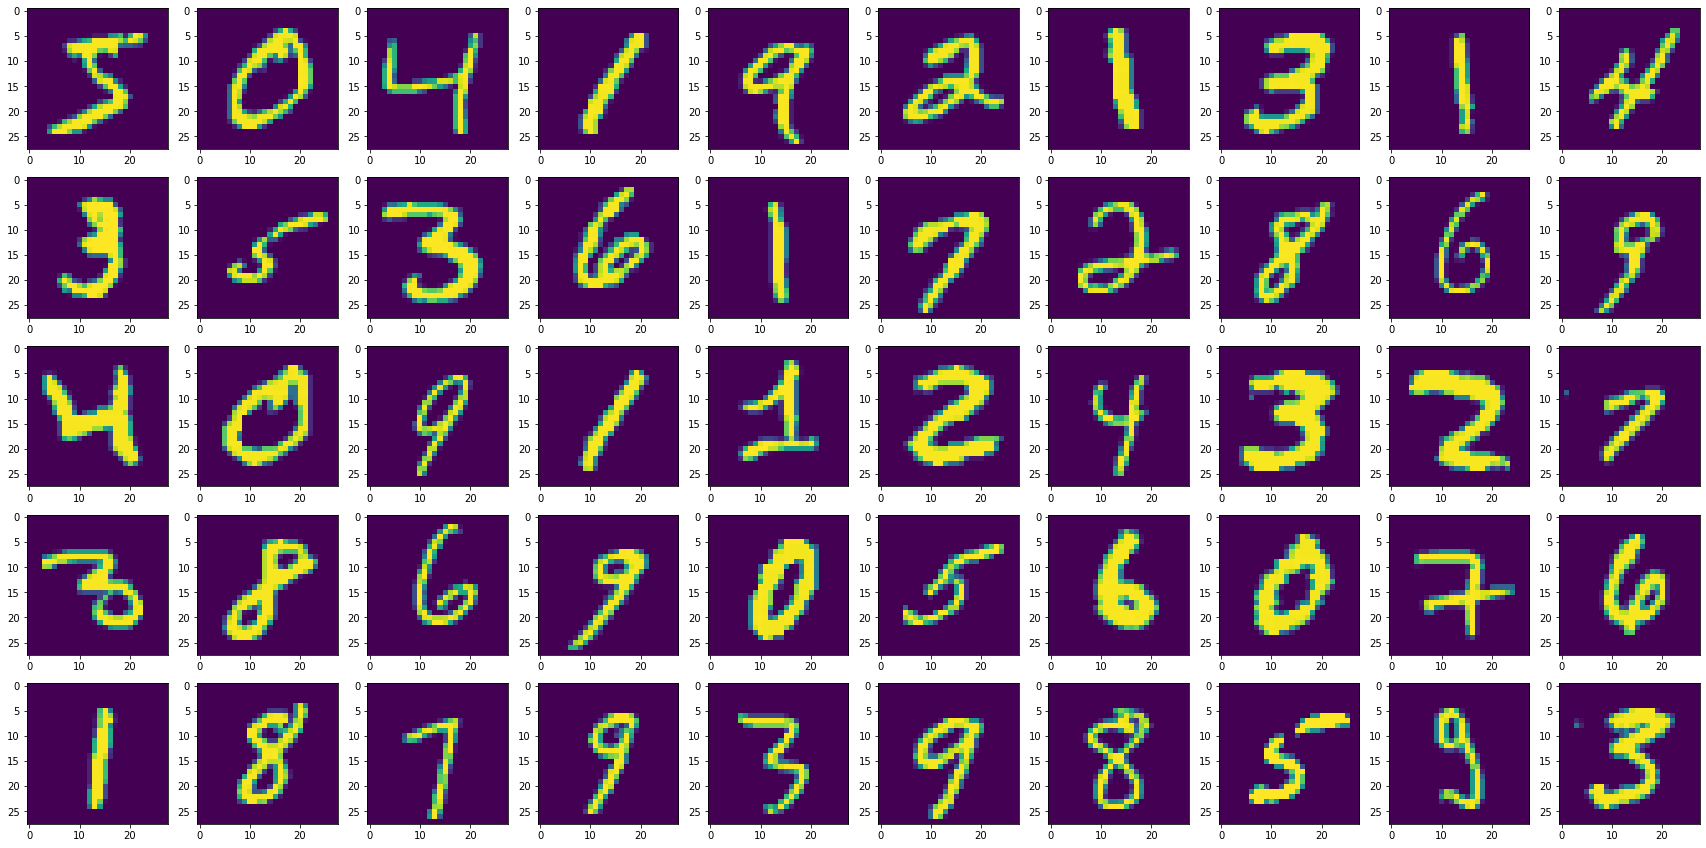

In [5]:
train_images_to_show=train_images[0:49] # 50 images to show
fig = plt.figure(figsize=(30, 15)) # width and hieght in inches
columns = 10
pictures_count = train_images_to_show.shape[0]
rows = np.ceil(pictures_count / columns)
for i in range(50):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(train_images[i])# an array of (28,28) shape  

There is an issue of **Mode Collaspse** concerned with GAN , to avoid any instance of it lets train our model to generate just a specific digit. 
In my case that is going to be **5**.

In [6]:
train_images=train_images[train_labels==5]

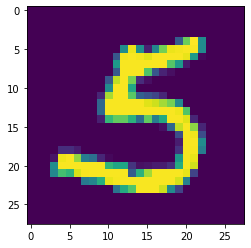

In [7]:
plt.imshow(train_images[random.randint(1,4251)])

In [8]:
train_images.shape

(5421, 28, 28)

In [9]:
train_images=train_images.reshape(5421,28,28,1) # add one more dimension to indicate a single channel 

In [11]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [12]:
latent_dim=100 # dimension of noise distribution which will be fed to the Generator to produce images

## Generator 

![image_1](https://lh3.googleusercontent.com/proxy/XmPbcYSNzaBqHs9eMRhDpZ8YgOXk-DtnrvZCDw5lLBBl0azrdSvV7Tr1UjU88EwCBYrTeXV8dbOEF-ITBa-oauPQHw)

In [13]:
def build_generator():
    model=tf.keras.Sequential()
    model.add(layers.Dense(128*7*7,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))
    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))## half padding is used. 
    assert model.output_shape == (None, 7, 7, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Random Noise Generation 

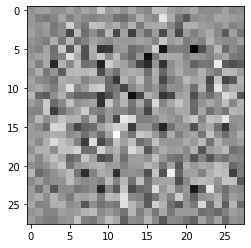

In [14]:
generator=build_generator()
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator 

Discriminator is a simple **CNN** that accepts inputs as image dimension both from **Generator and Train_Data** and penalizez the generator for creating fake data based on loss function given by **Ian Goodfellow**.

![image_2](https://images.squarespace-cdn.com/content/v1/5acd141d1137a6066ac14dbe/1523493050989-MJ1ETC2BAGAV2POWEWW2/ke17ZwdGBToddI8pDm48kO2lZq944C5Q5o9ZL4LXfvQUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYxCRW4BPu10St3TBAUQYVKccxvpO24GfTw40GA0EpjBhwc1qf-Cs2eKUPEC4dw6cFlAO5yXUL1_-J7hp019X7v0/DCGAN.png?format=2500w)

In [15]:
def build_discriminator():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0041449]], shape=(1, 1), dtype=float32)


## Loss Functions 

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

![image_3](https://cdn-images-1.medium.com/max/800/1*EJPT0utTkQ2qrHfjDID5RA.png)

![image_4](https://miro.medium.com/max/4688/1*FbQLpEVQKsMSK-c7_5KcWw.png)
**We maximmize loss for discriminator and minimize for Generator.**  

### The GoodFellow Approach for Minimizing Loss and Optimizing Algorithm

![image_5](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Summary-of-the-Generative-Adversarial-Network-Training-Algorithm-1024x669.png)

#### Loss for Discriminator
The Basic conclusion from the above series of formulas can be drawn that the while feeding the data to the discriminator from data set or real images it should be passed with label 1 for real iamges and 0 for fake images. 
- discriminator: maximize log D(x) + log(1 – D(G(z)))

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Now for generator since it wants to fool the discriminator it should get label 1 for its fake output. 
It means fake output corrosponds to true label for generator
- generator: minimize log(1 – D(G(z)))

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Parameters and Training

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 1 
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We train Discriminator and Generator **one by one and not together** . There for while training the generator use generator variables only and while for discriminator Discriminator only. 

In [22]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
# a small code to shuffle and divide our data into batches
BATCH_SIZE=256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(5421).batch(BATCH_SIZE)

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

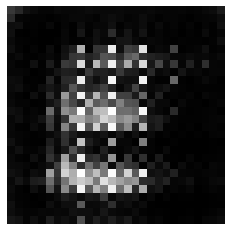

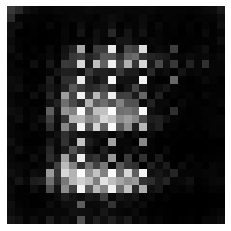

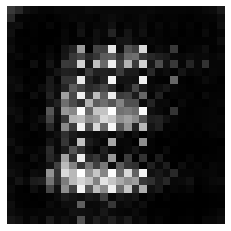

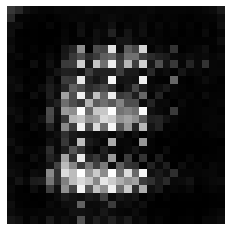

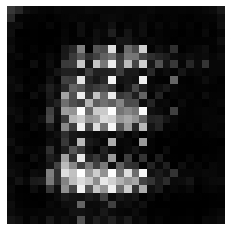

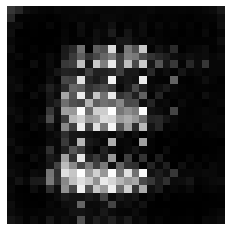

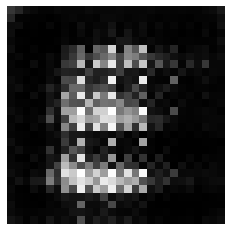

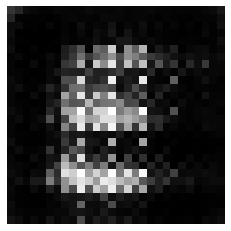

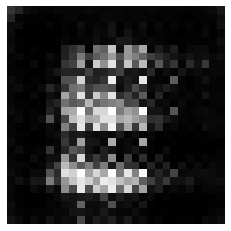

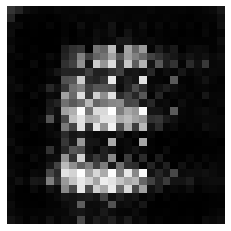

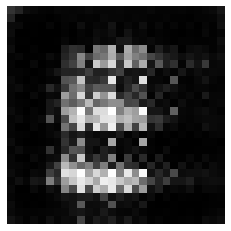

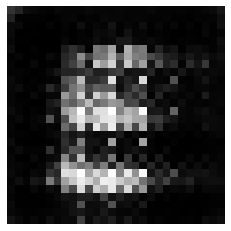

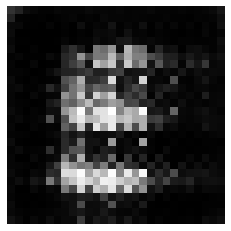

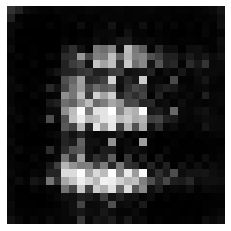

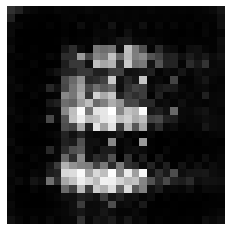

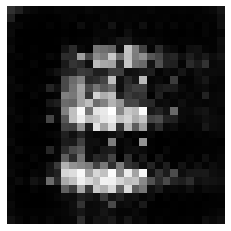

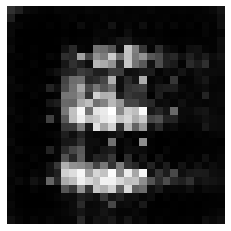

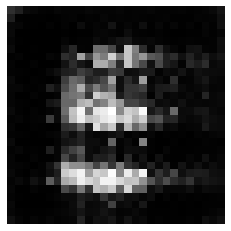

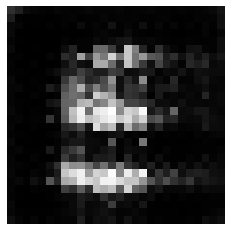

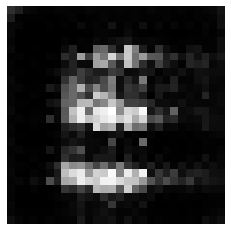

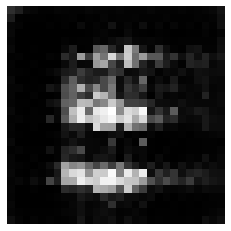

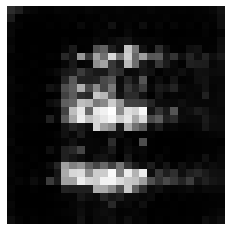

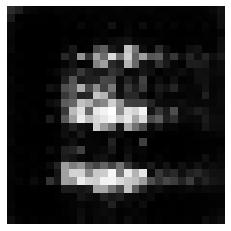

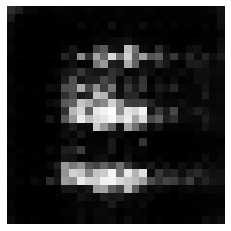

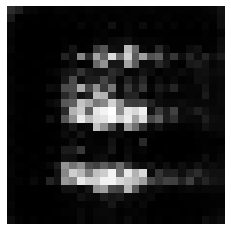

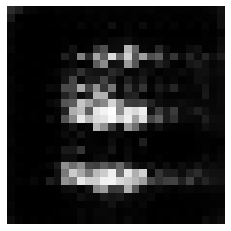

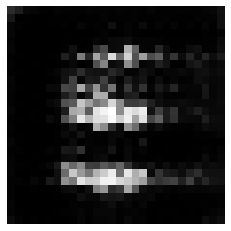

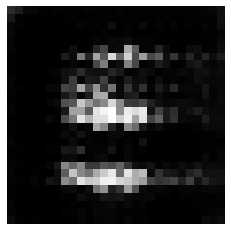

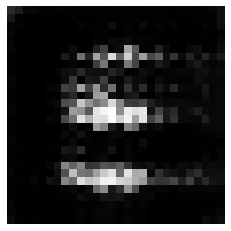

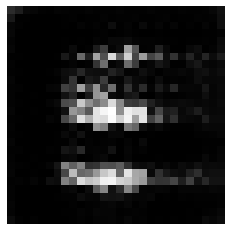

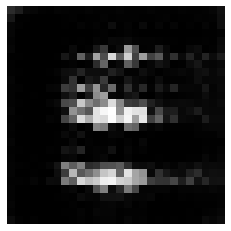

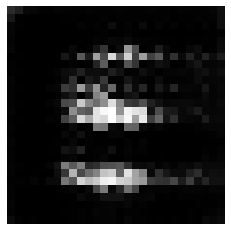

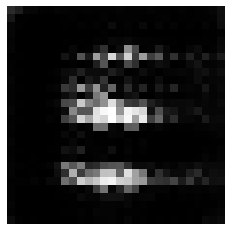

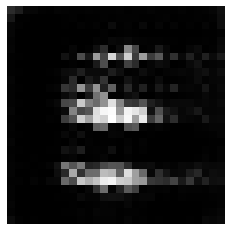

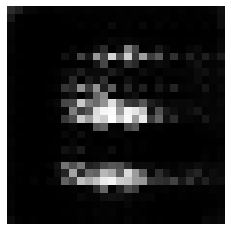

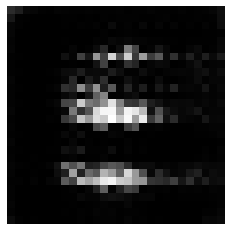

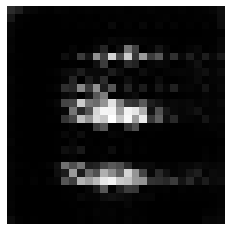

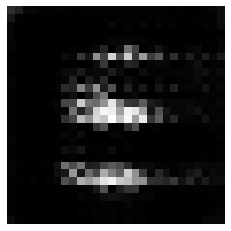

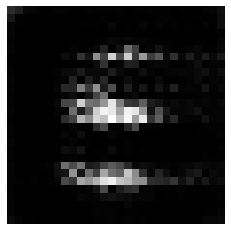

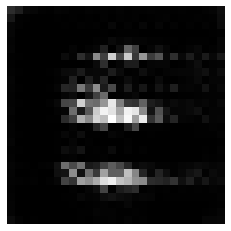

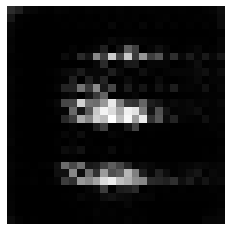

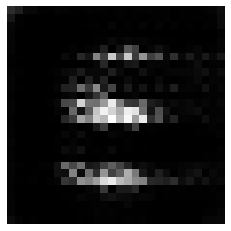

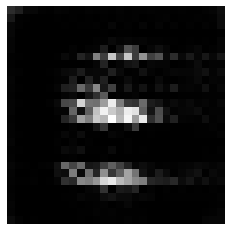

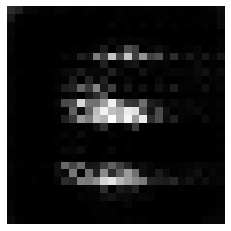

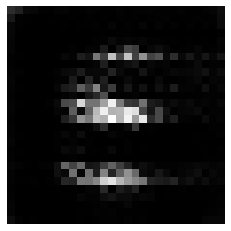

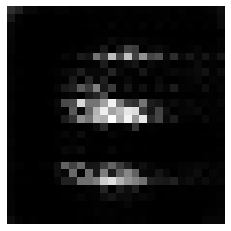

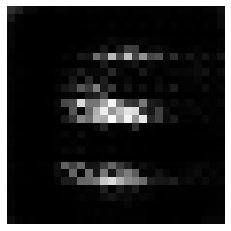

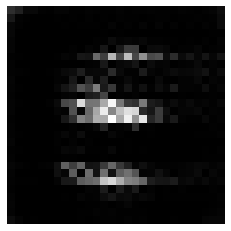

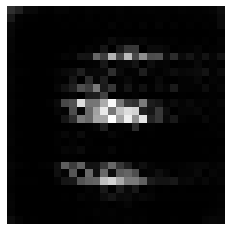

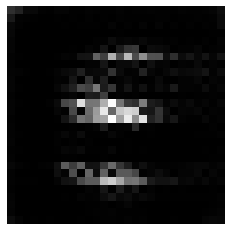

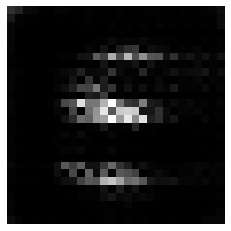

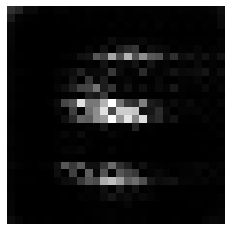

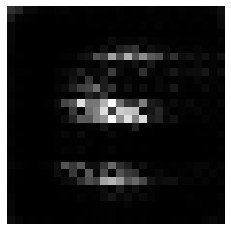

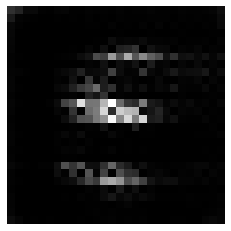

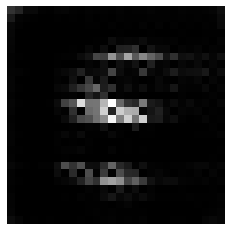

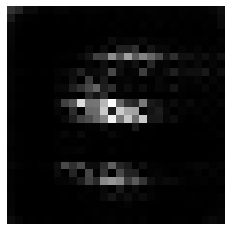

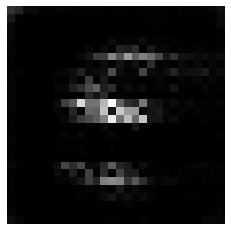

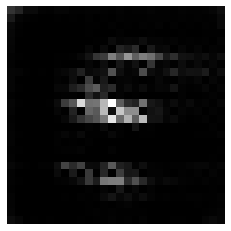

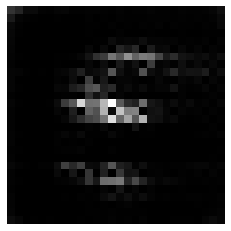

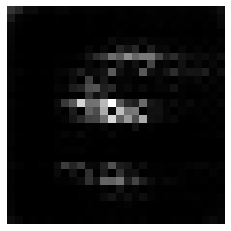

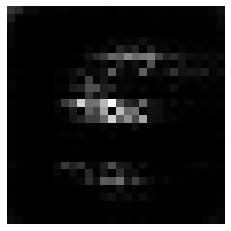

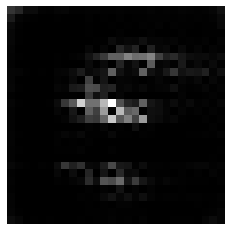

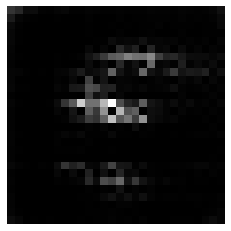

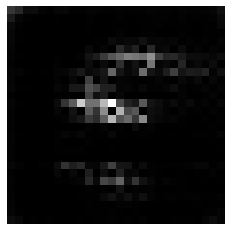

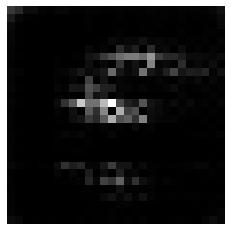

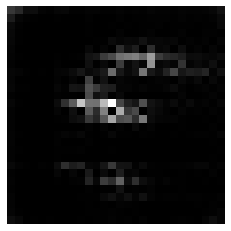

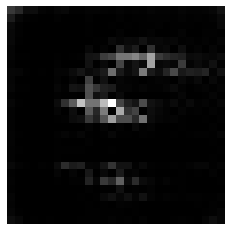

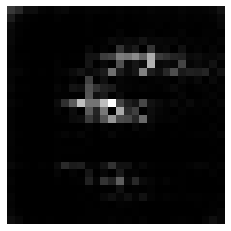

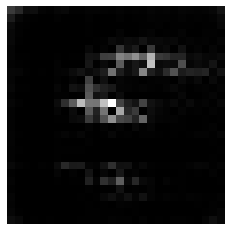

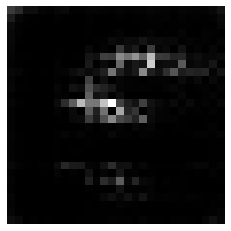

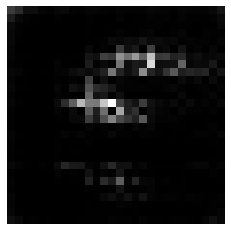

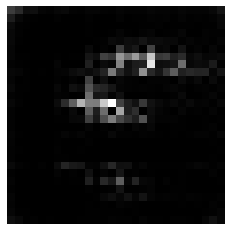

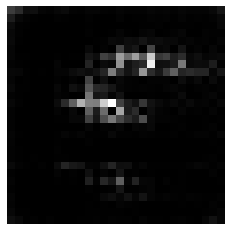

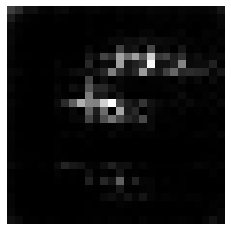

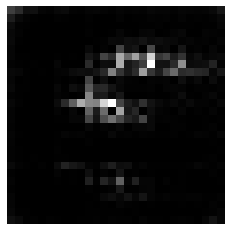

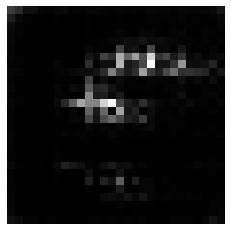

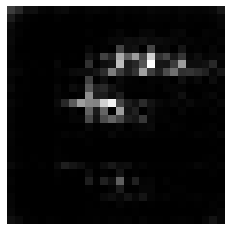

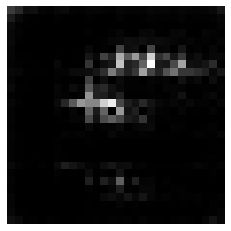

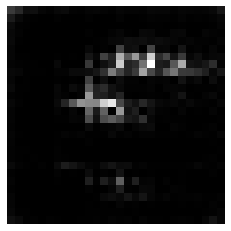

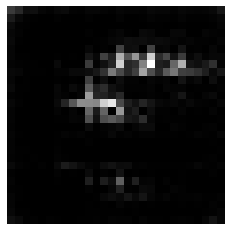

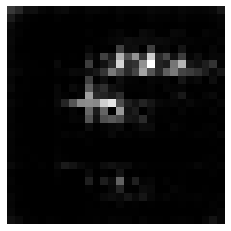

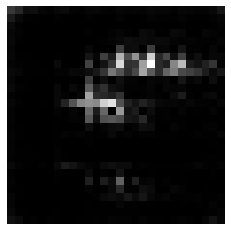

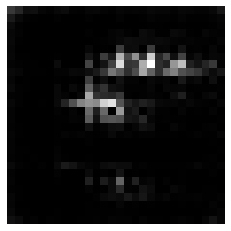

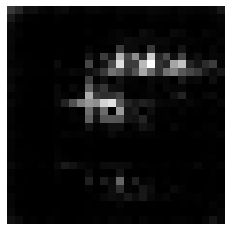

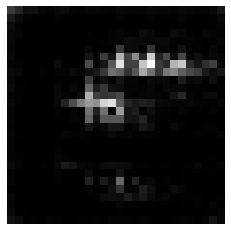

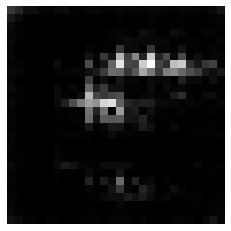

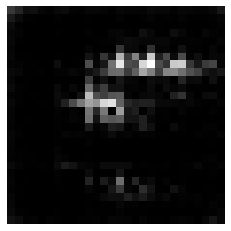

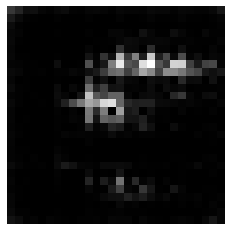

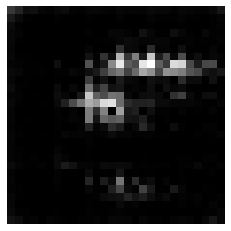

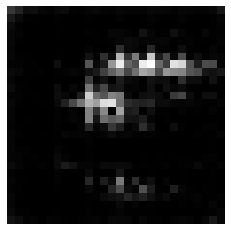

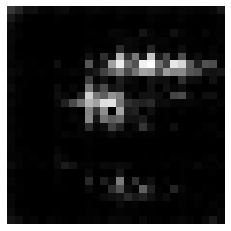

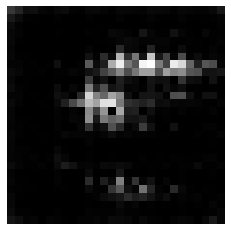

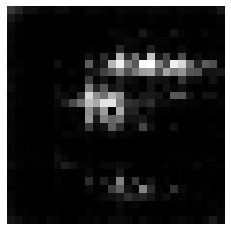

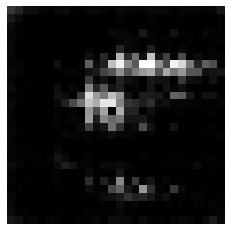

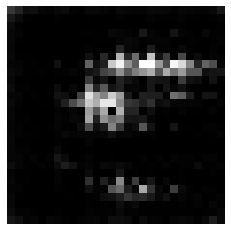

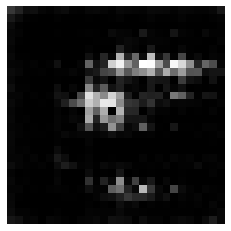

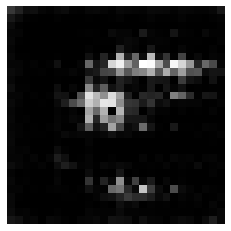

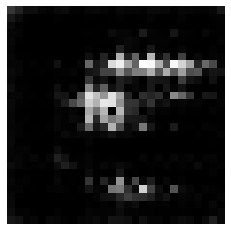

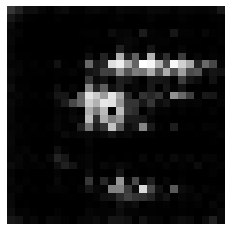

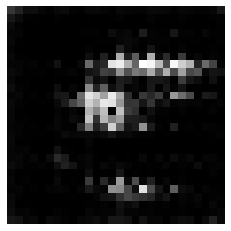

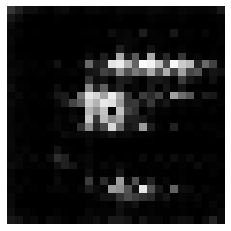

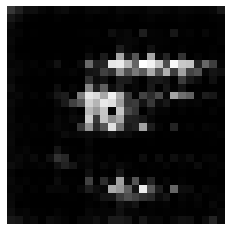

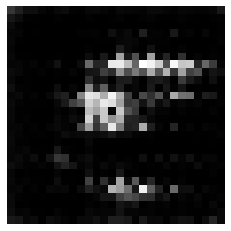

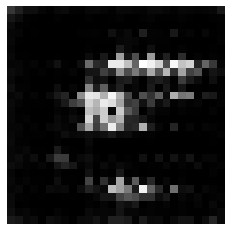

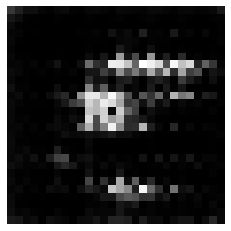

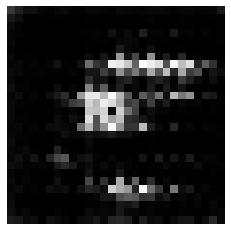

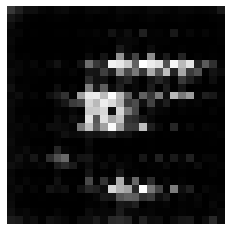

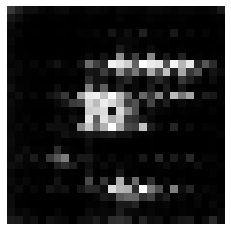

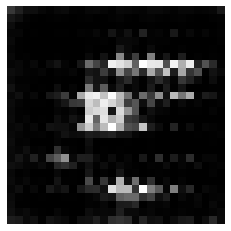

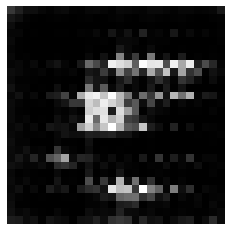

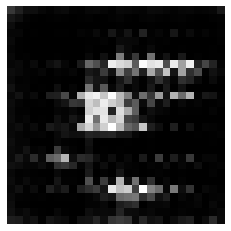

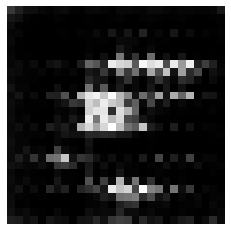

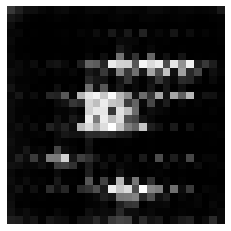

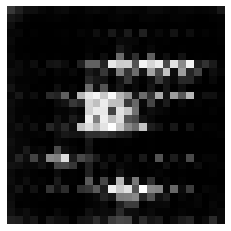

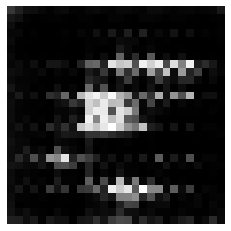

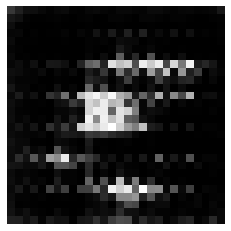

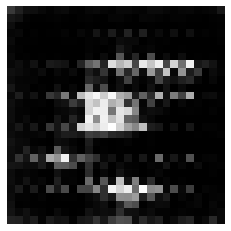

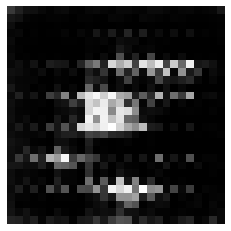

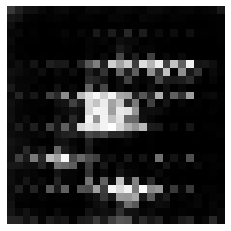

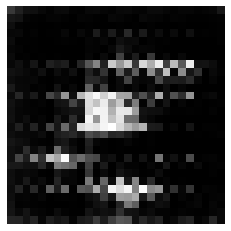

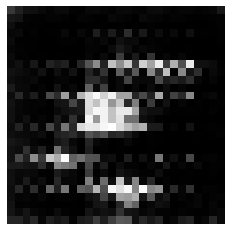

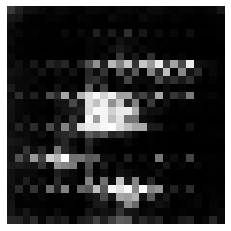

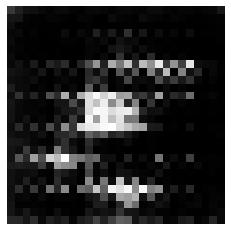

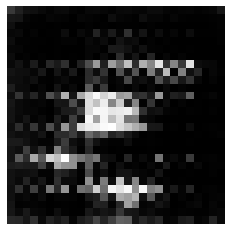

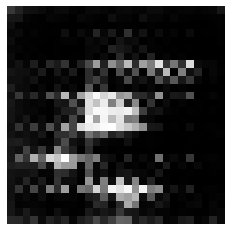

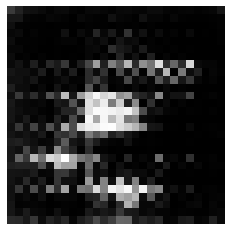

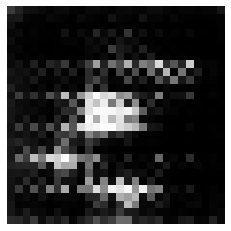

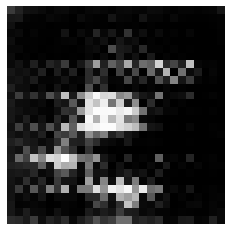

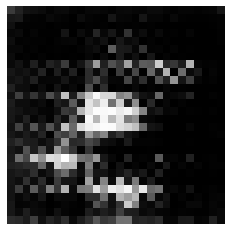

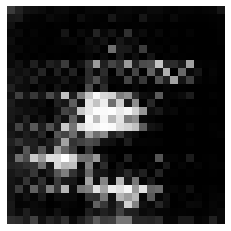

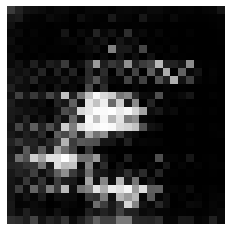

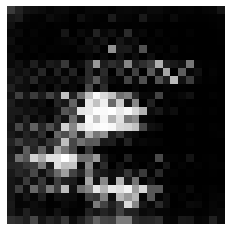

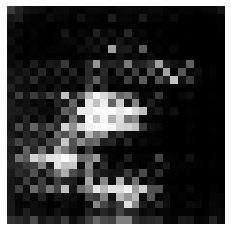

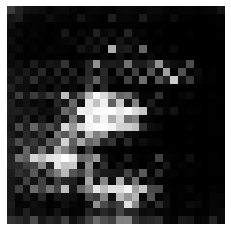

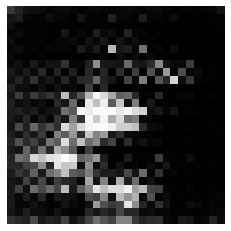

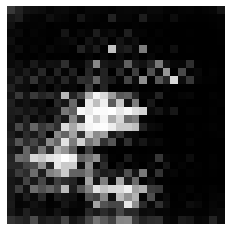

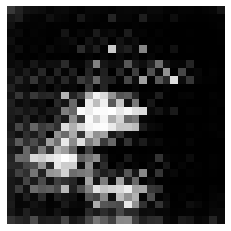

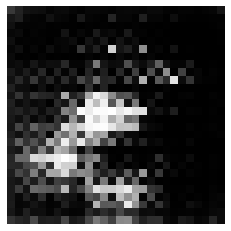

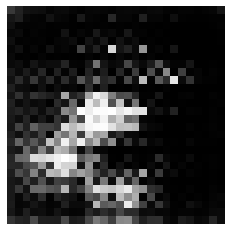

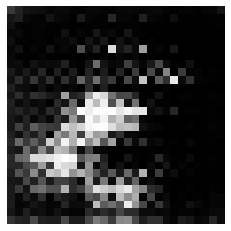

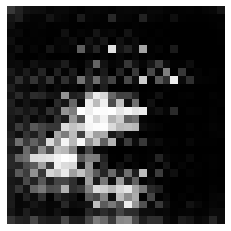

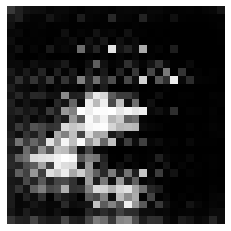

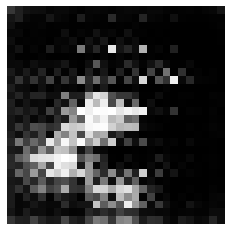

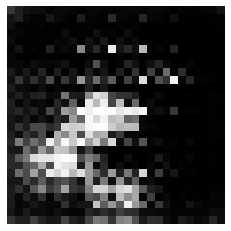

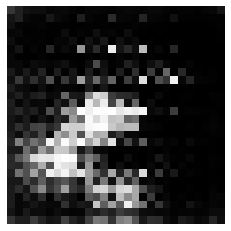

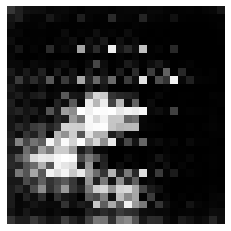

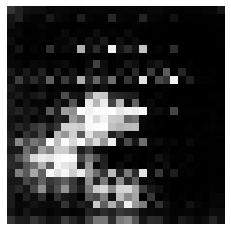

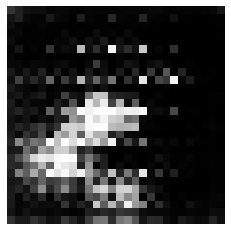

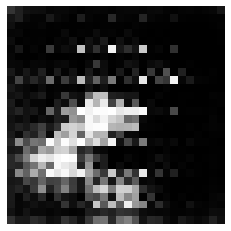

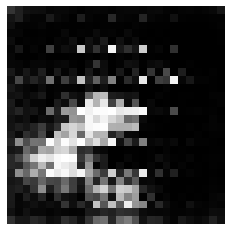

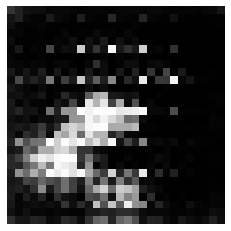

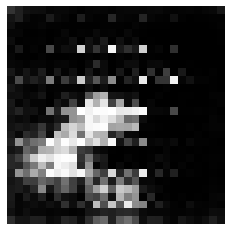

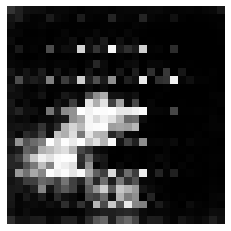

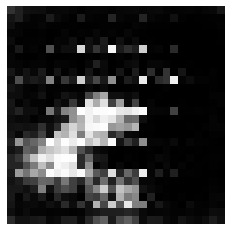

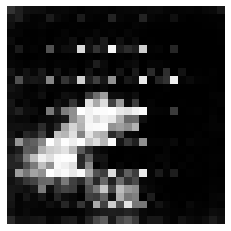

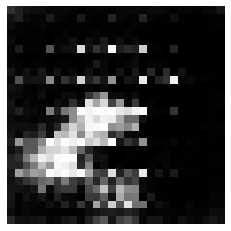

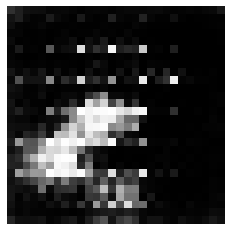

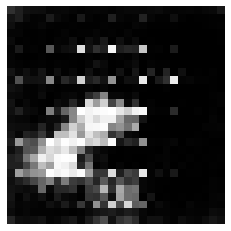

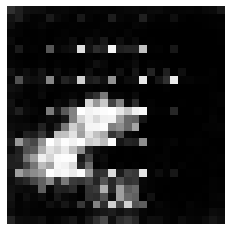

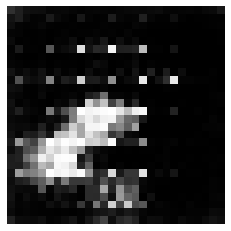

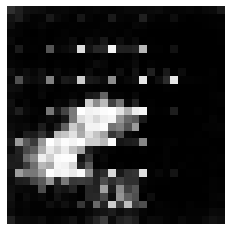

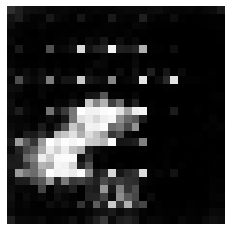

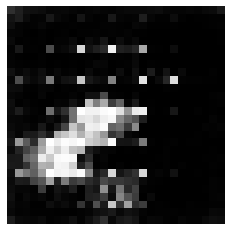

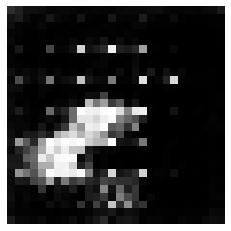

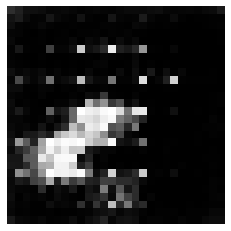

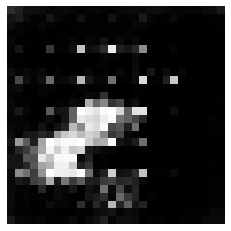

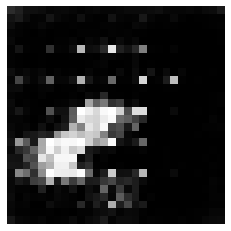

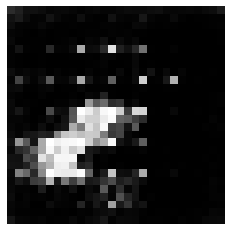

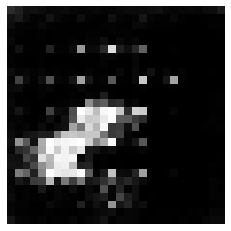

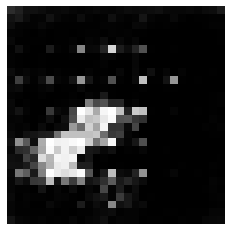

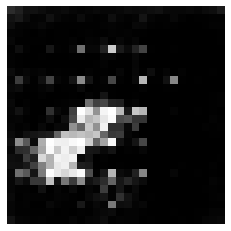

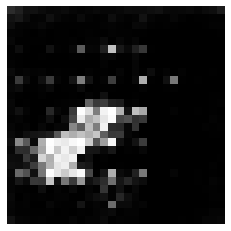

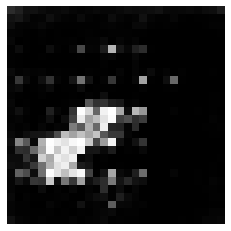

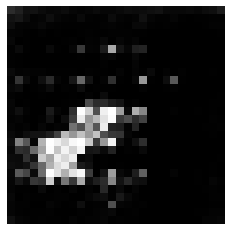

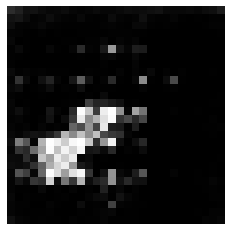

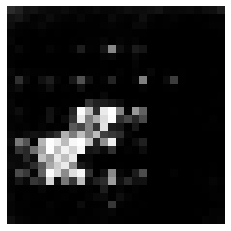

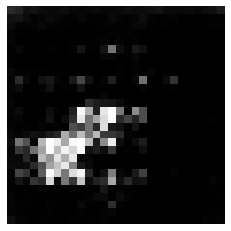

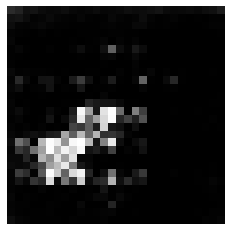

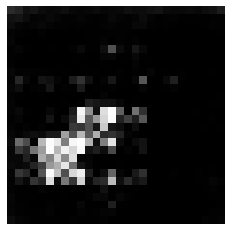

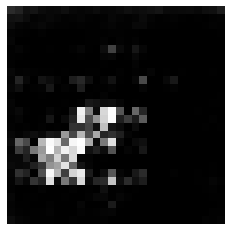

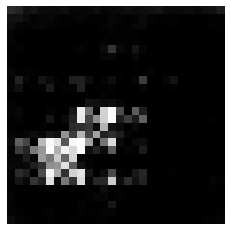

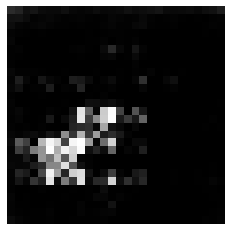

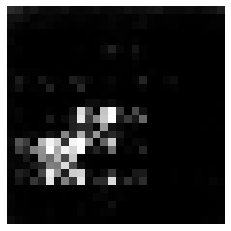

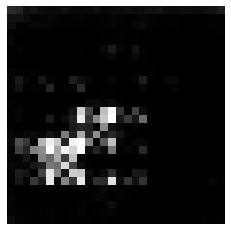

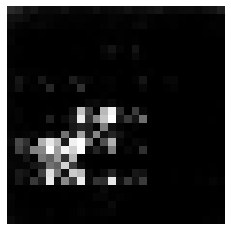

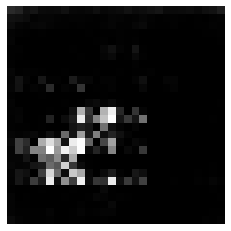

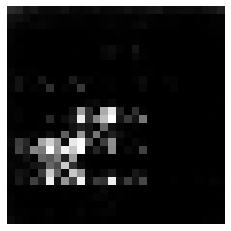

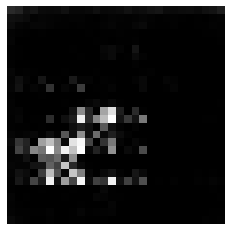

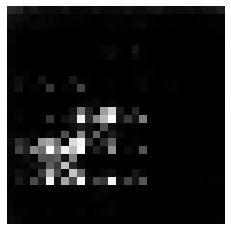

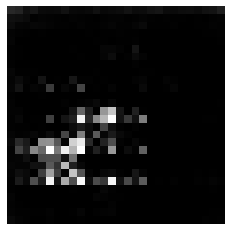

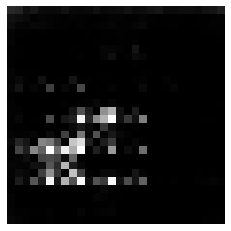

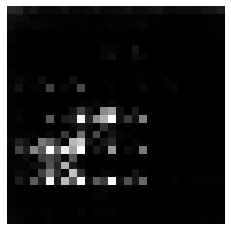

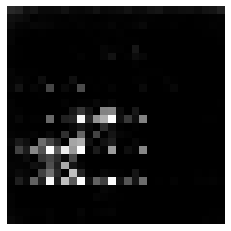

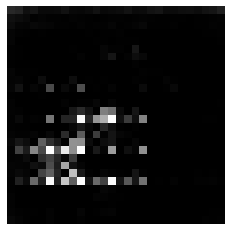

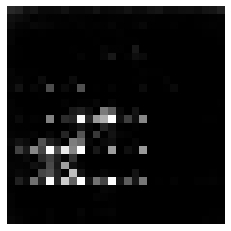

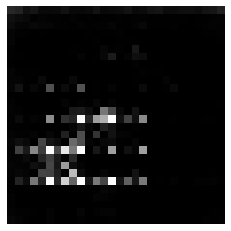

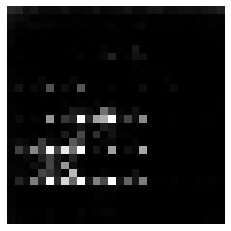

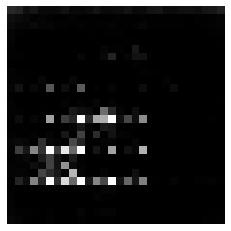

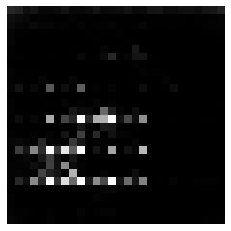

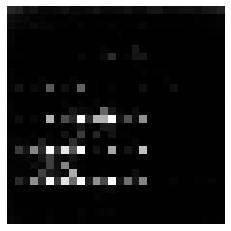

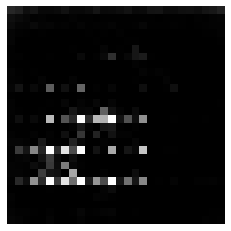

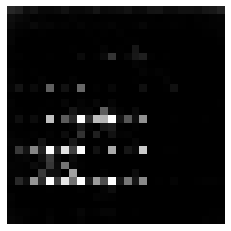

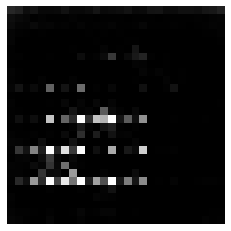

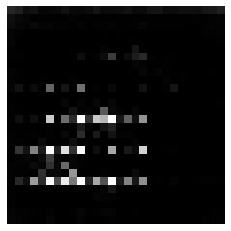

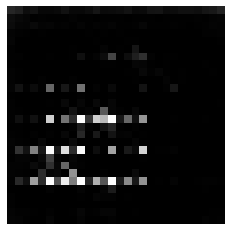

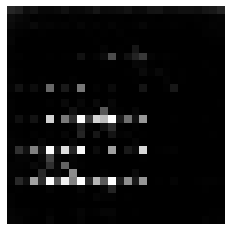

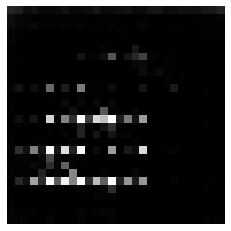

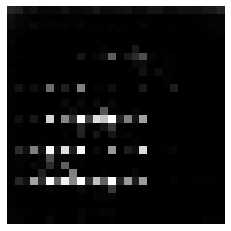

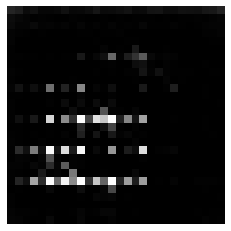

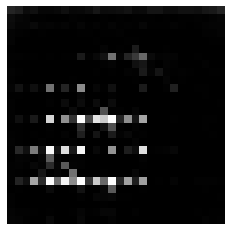

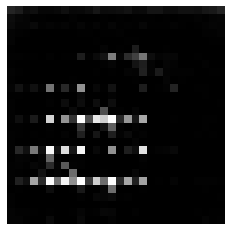

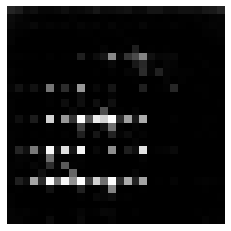

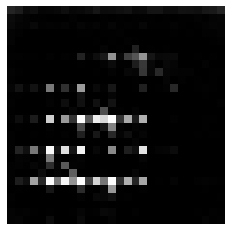

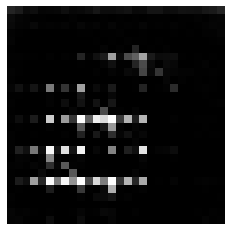

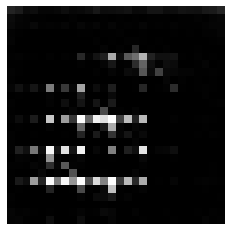

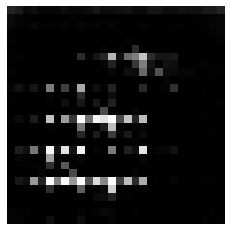

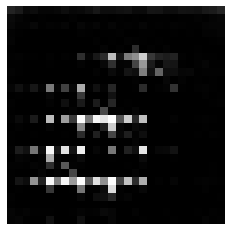

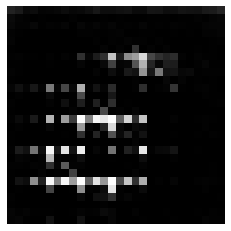

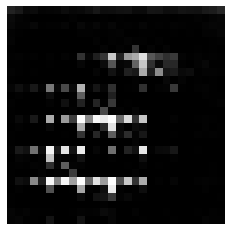

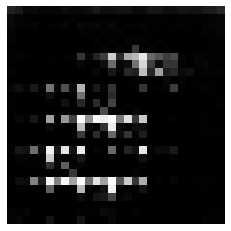

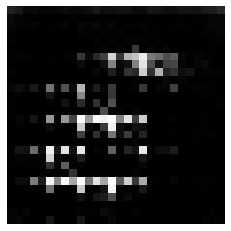

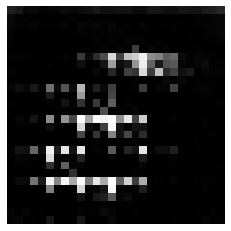

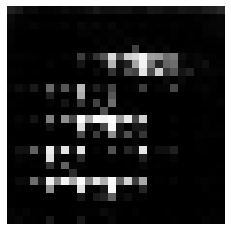

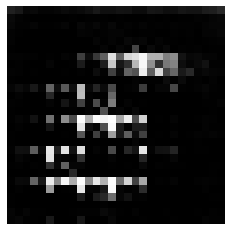

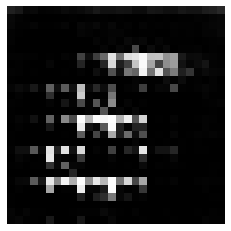

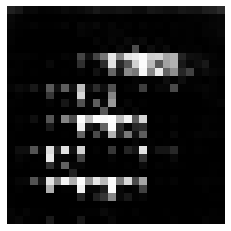

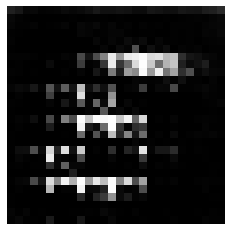

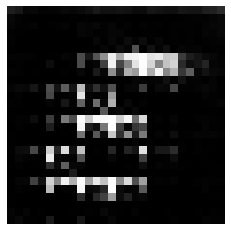

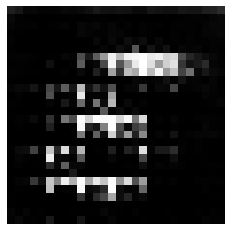

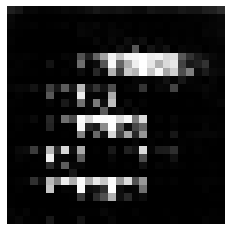

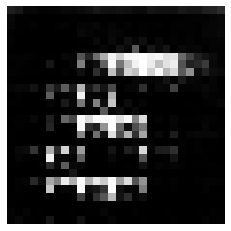

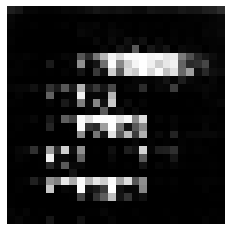

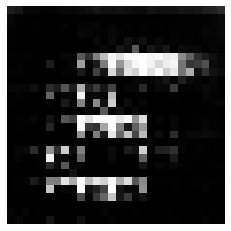

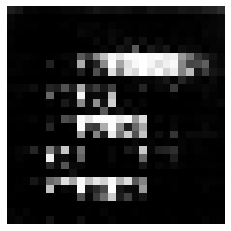

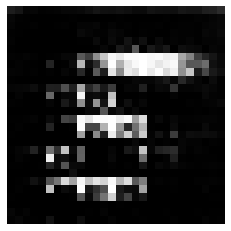

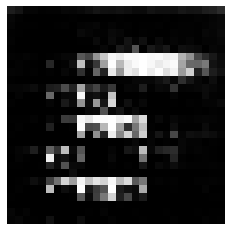

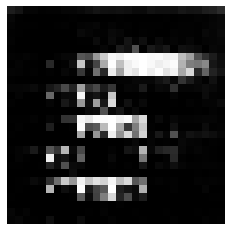

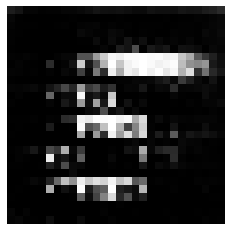

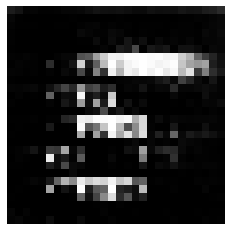

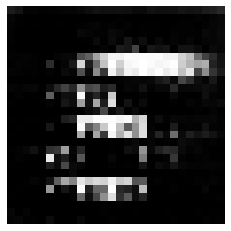

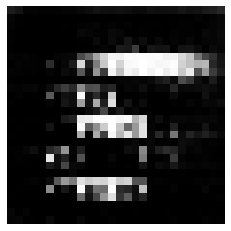

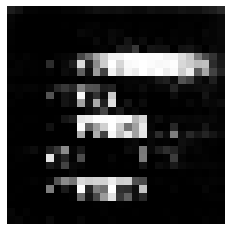

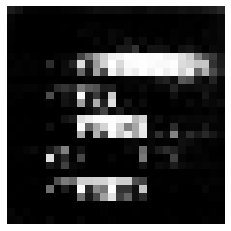

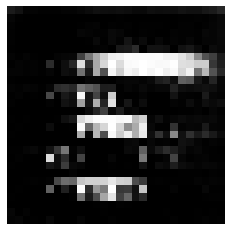

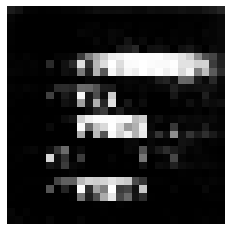

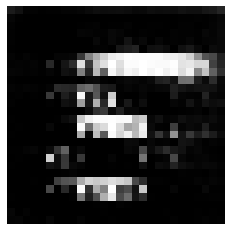

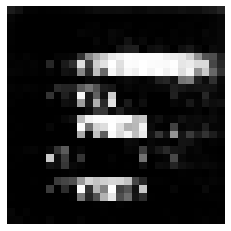

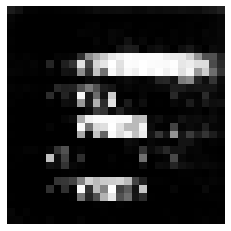

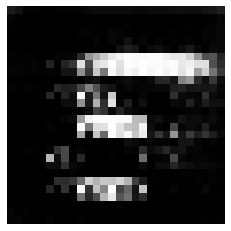

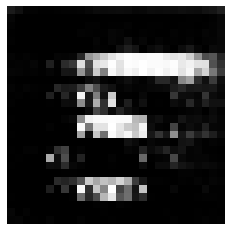

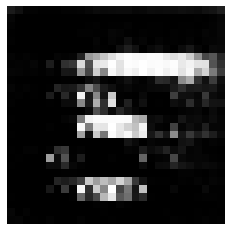

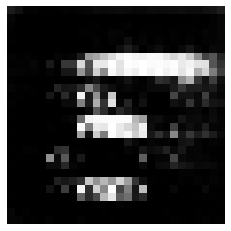

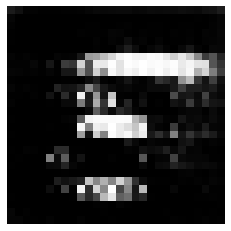

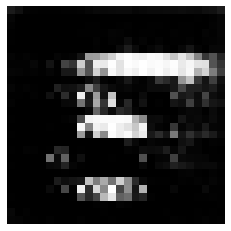

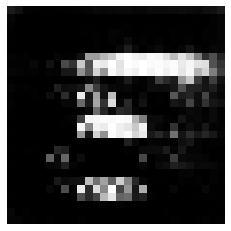

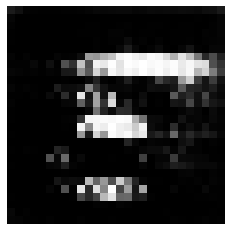

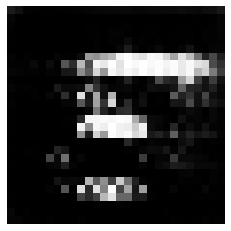

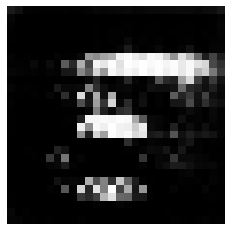

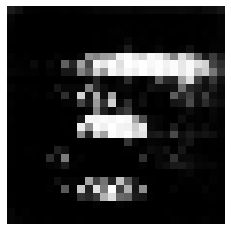

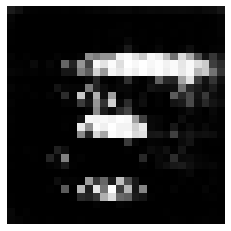

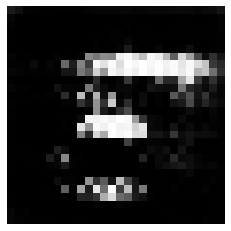

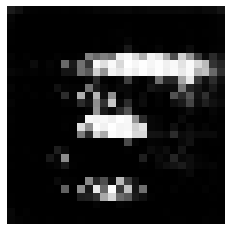

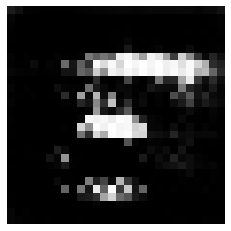

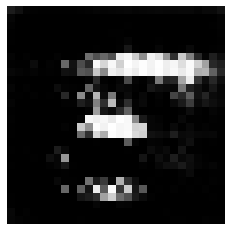

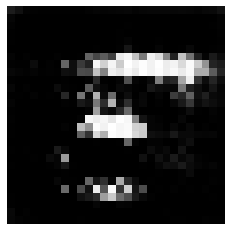

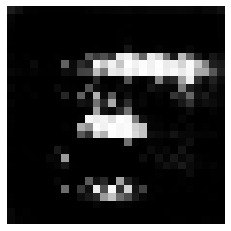

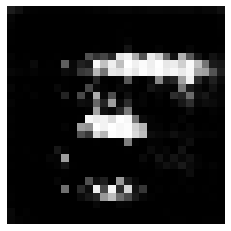

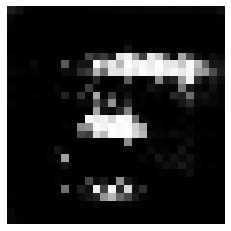

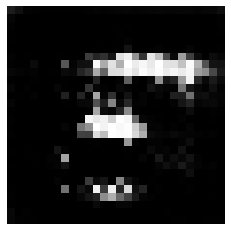

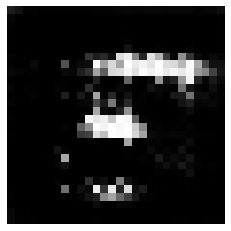

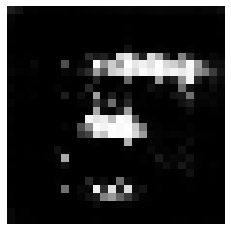

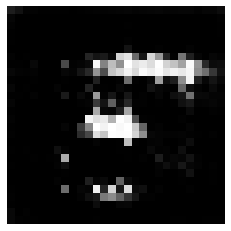

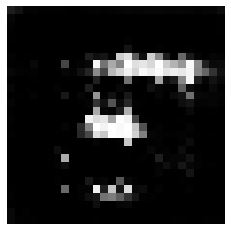

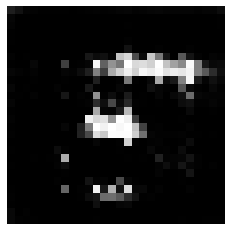

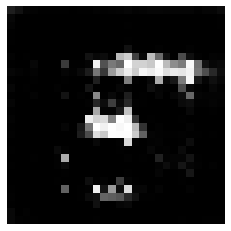

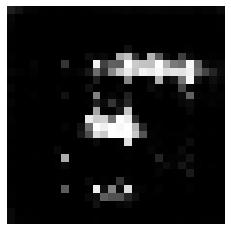

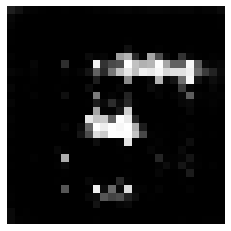

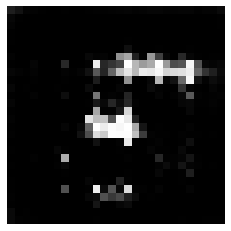

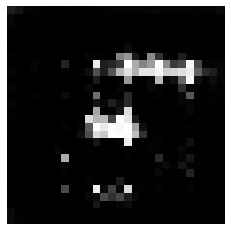

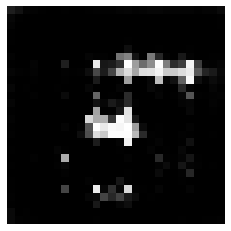

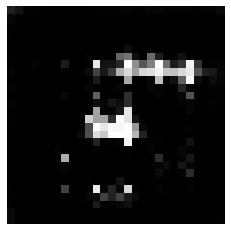

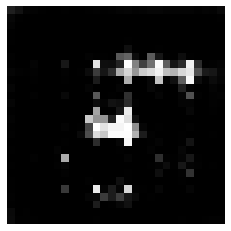

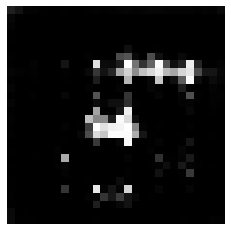

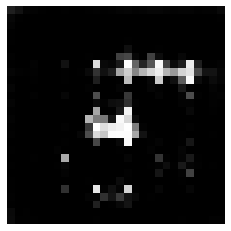

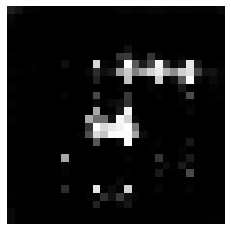

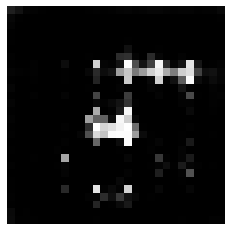

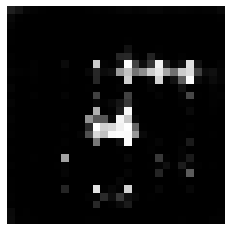

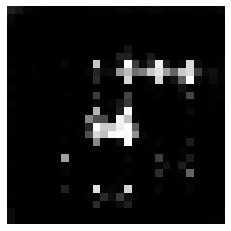

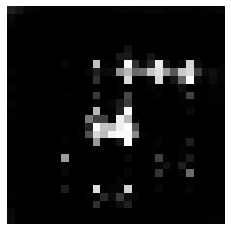

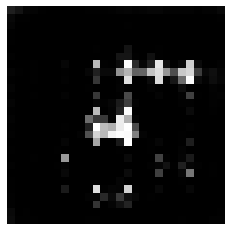

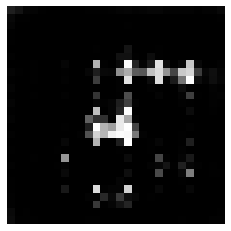

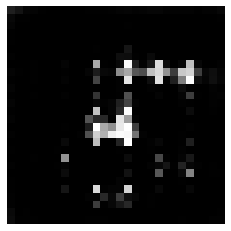

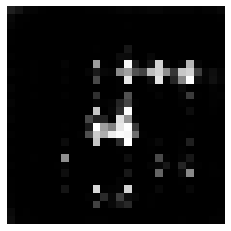

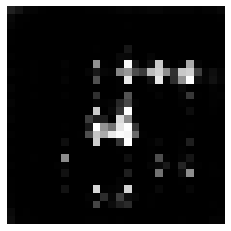

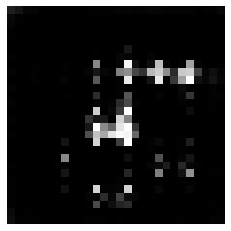

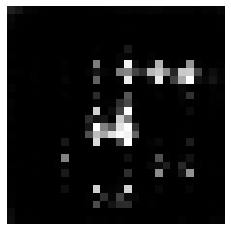

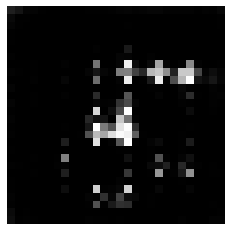

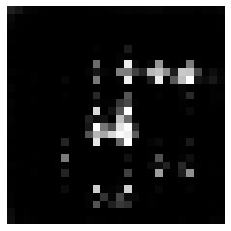

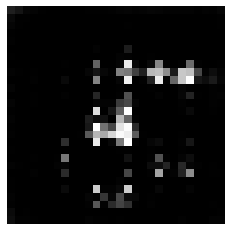

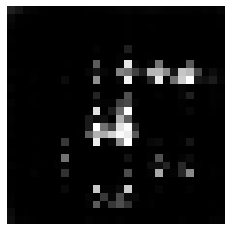

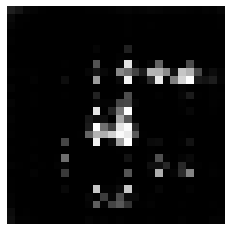

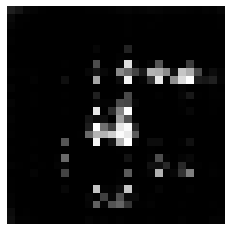

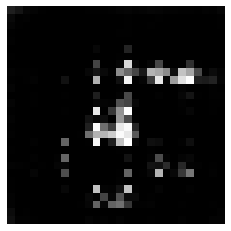

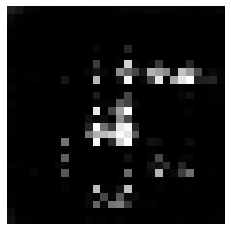

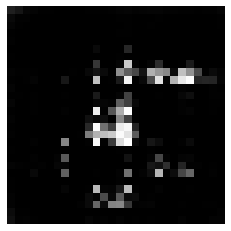

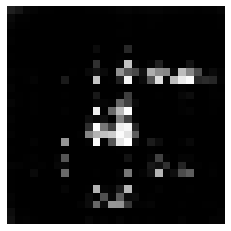

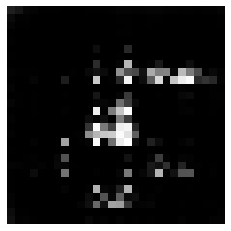

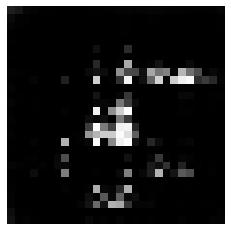

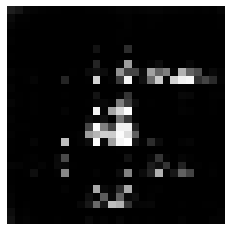

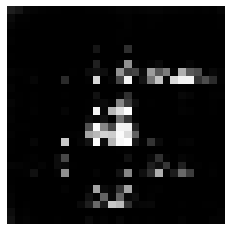

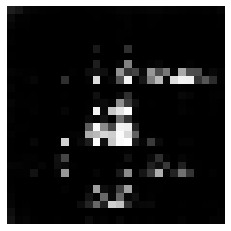

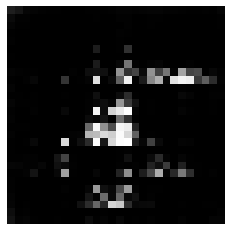

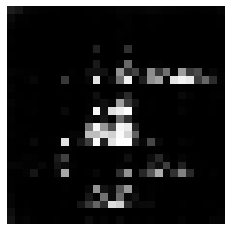

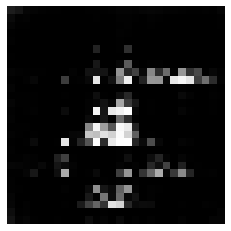

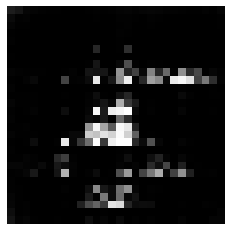

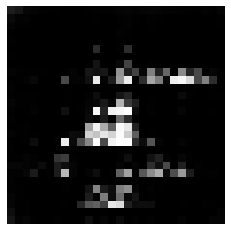

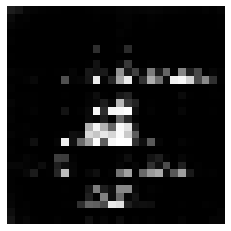

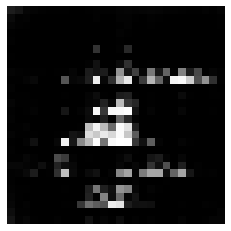

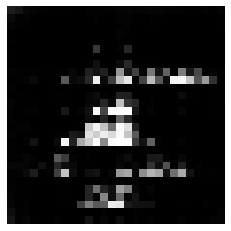

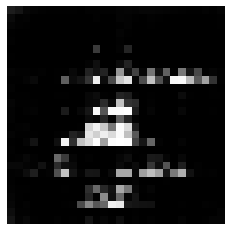

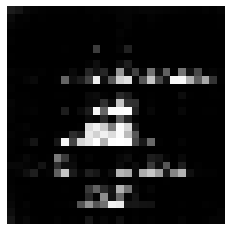

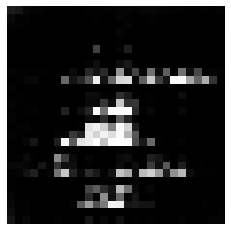

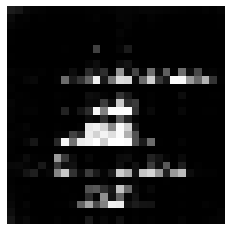

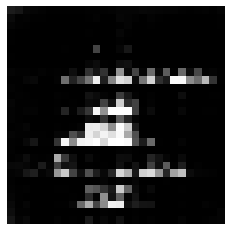

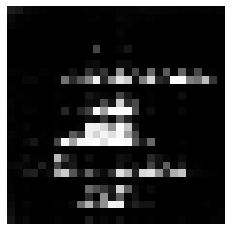

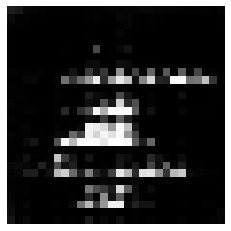

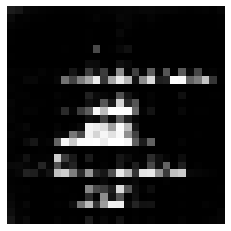

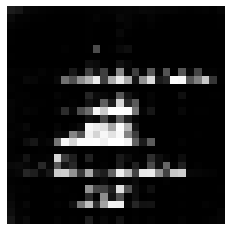

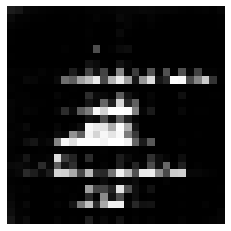

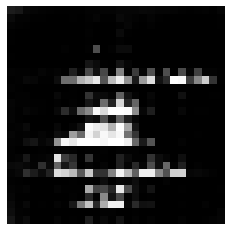

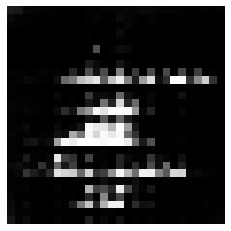

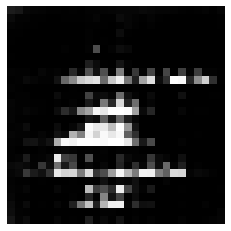

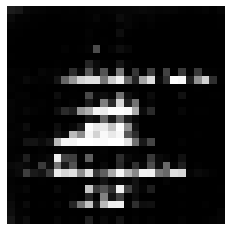

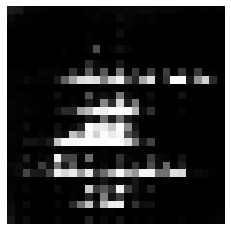

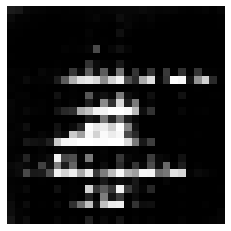

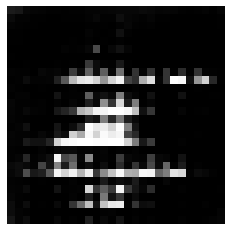

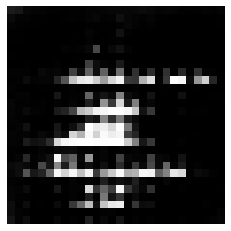

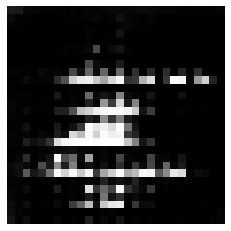

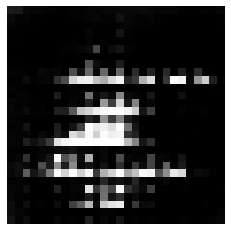

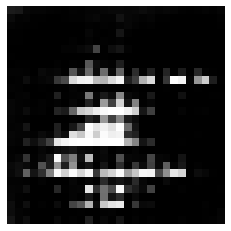

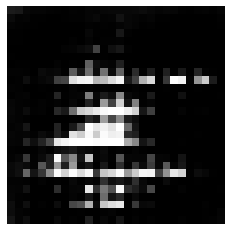

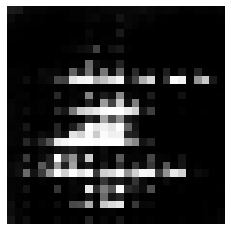

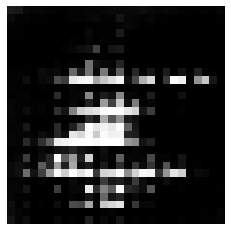

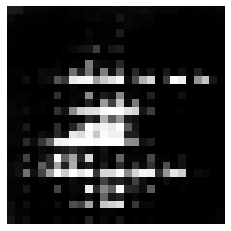

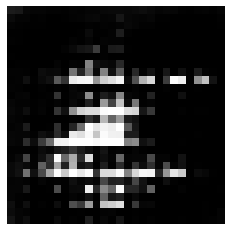

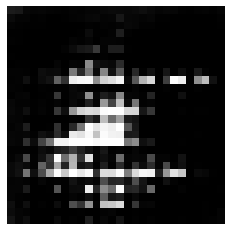

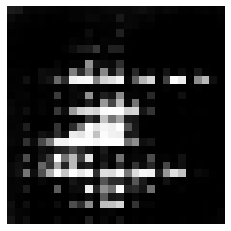

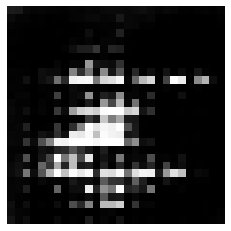

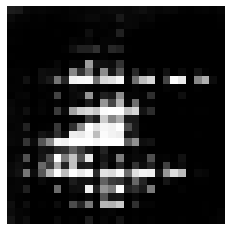

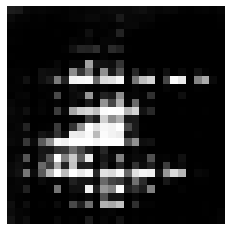

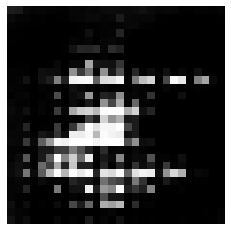

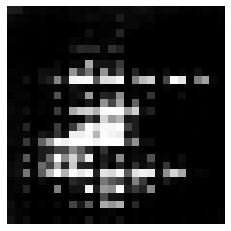

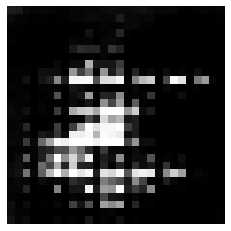

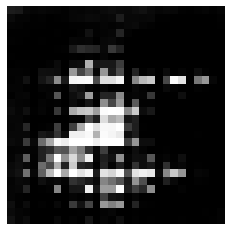

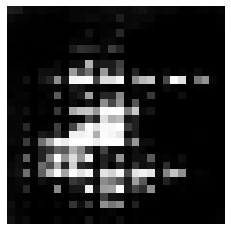

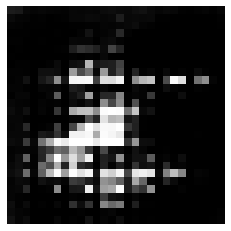

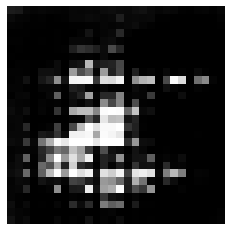

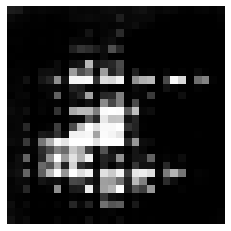

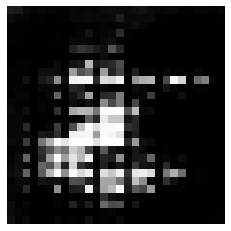

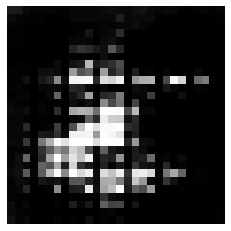

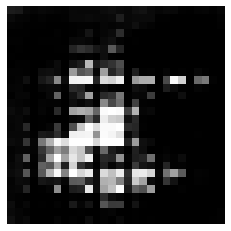

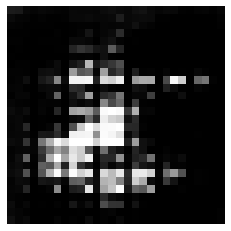

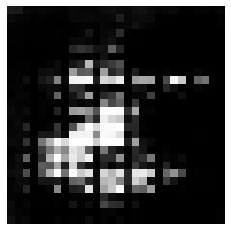

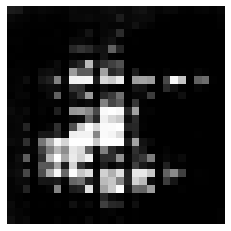

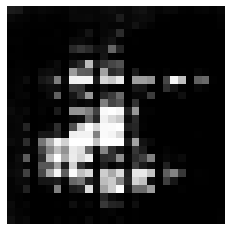

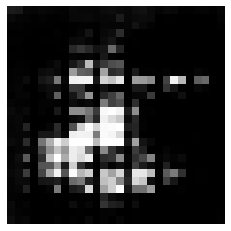

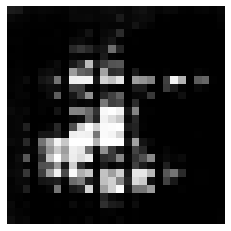

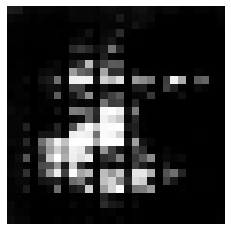

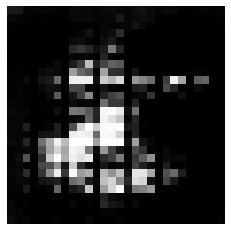

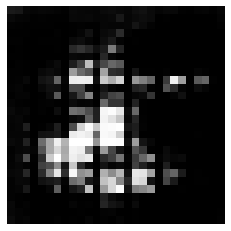

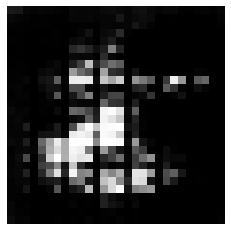

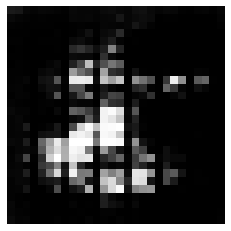

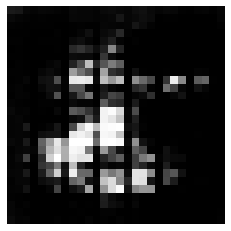

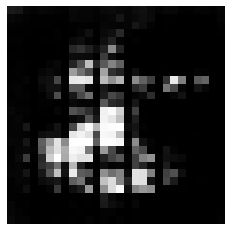

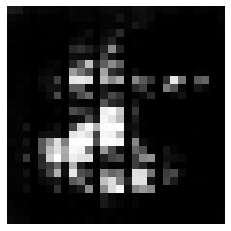

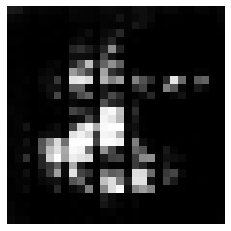

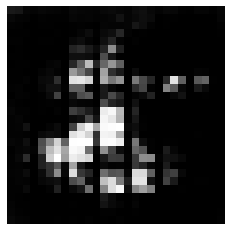

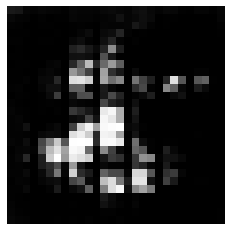

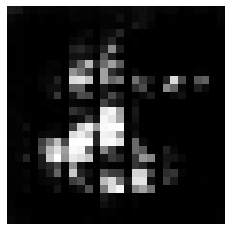

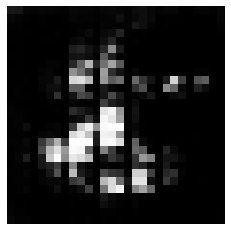

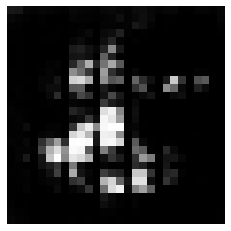

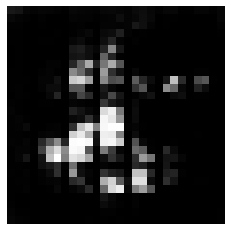

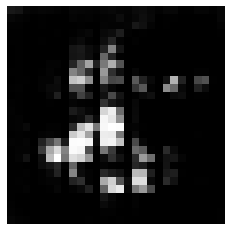

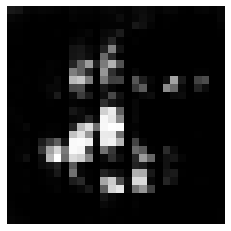

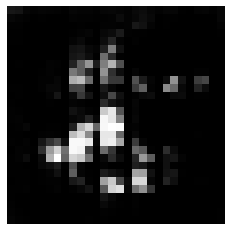

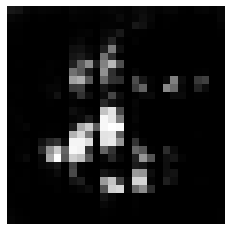

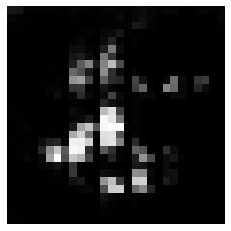

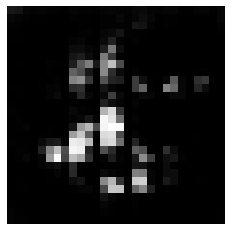

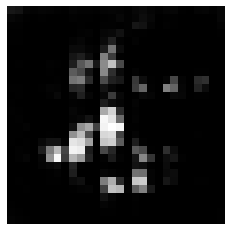

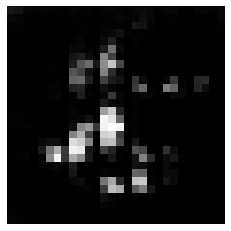

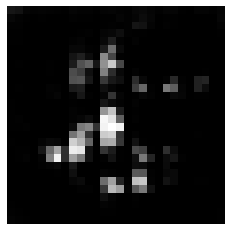

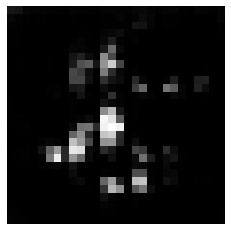

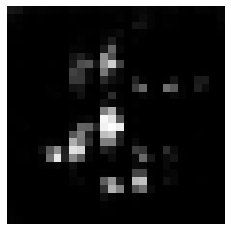

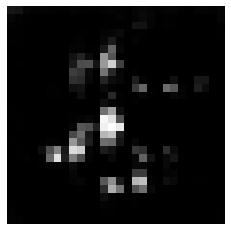

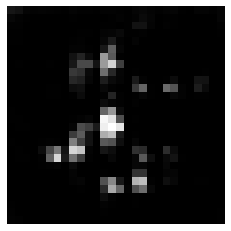

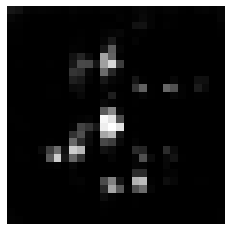

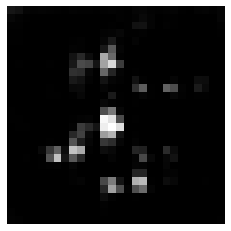

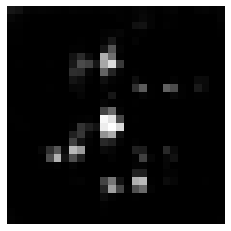

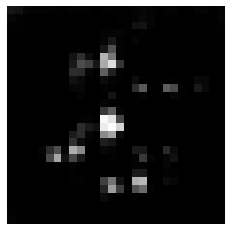

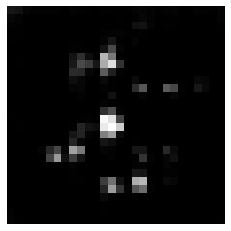

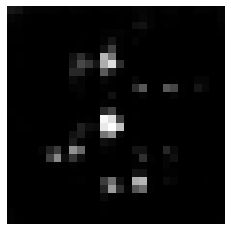

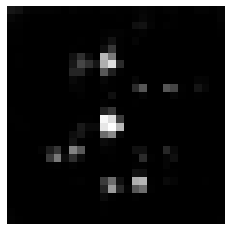

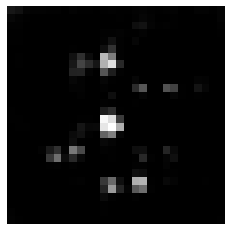

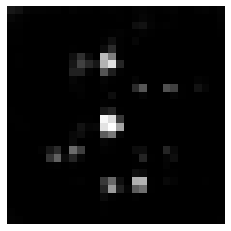

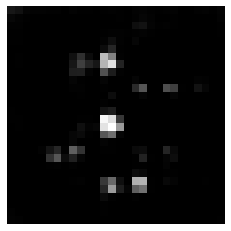

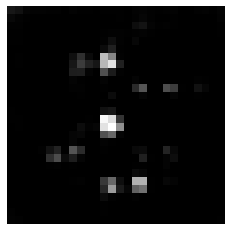

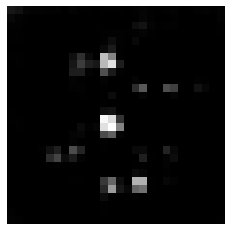

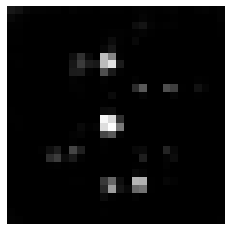

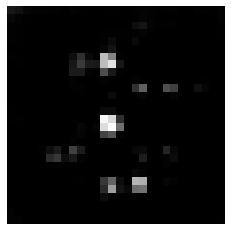

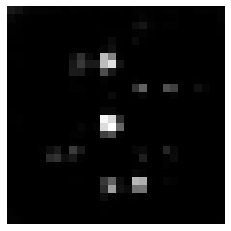

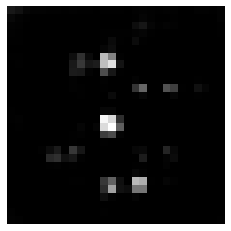

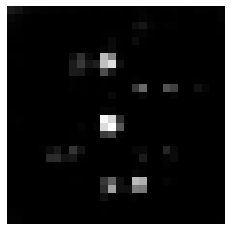

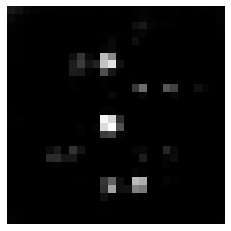

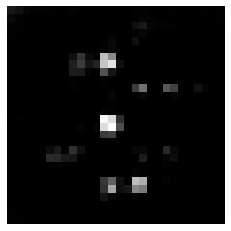

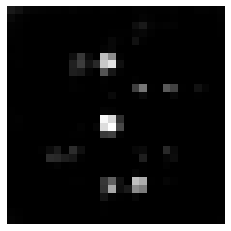

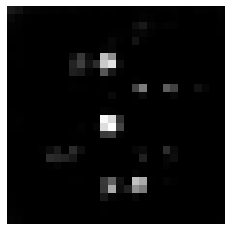

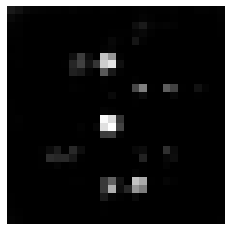

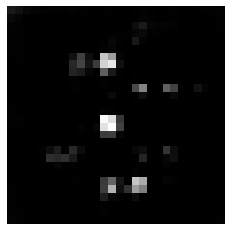

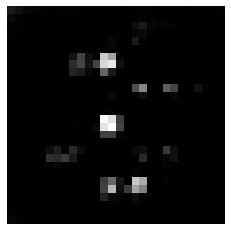

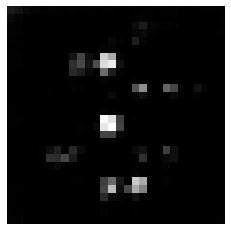

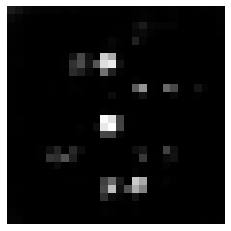

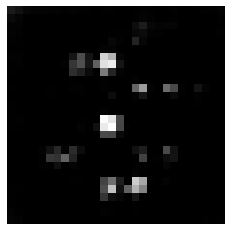

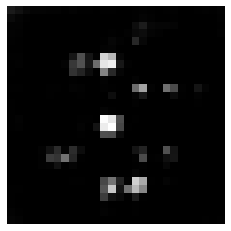

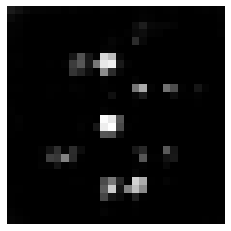

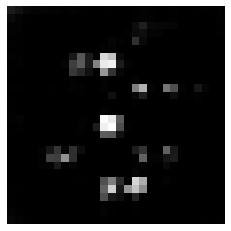

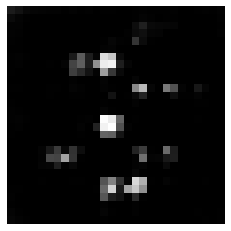

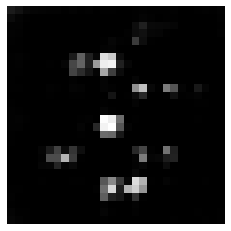

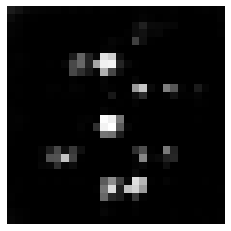

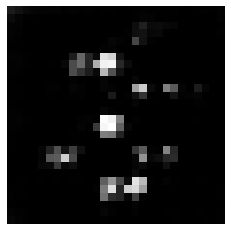

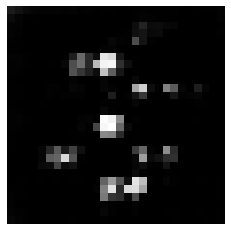

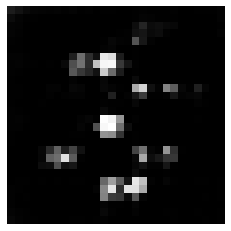

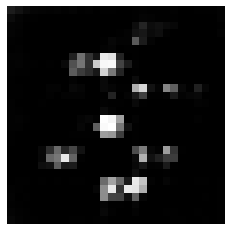

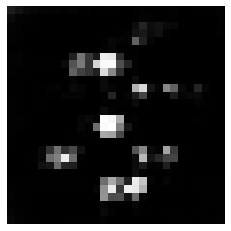

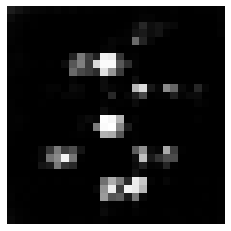

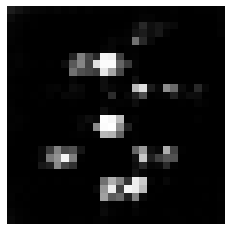

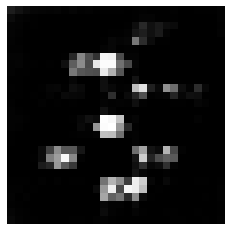

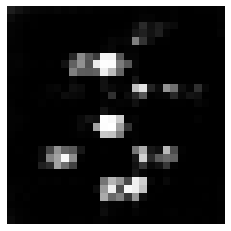

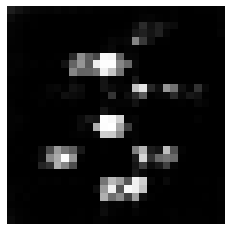

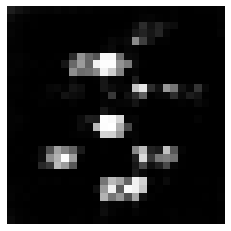

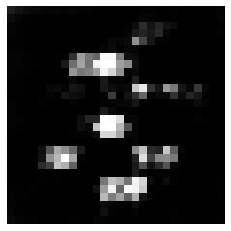

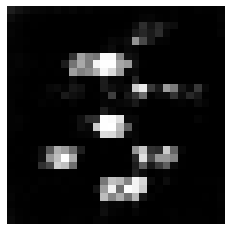

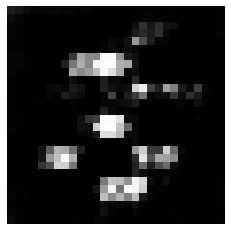

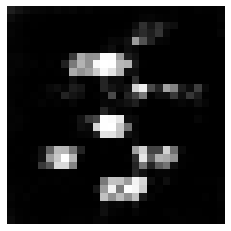

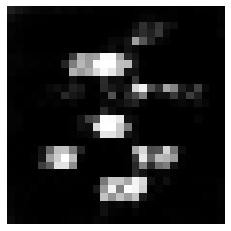

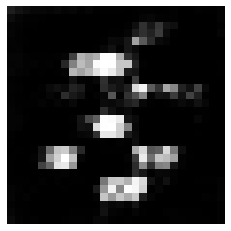

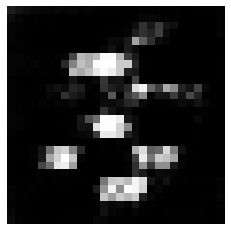

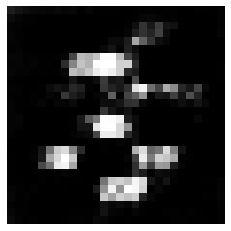

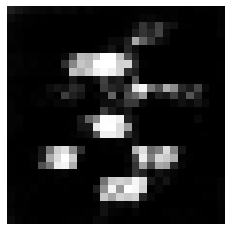

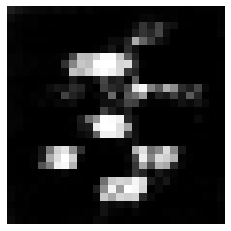

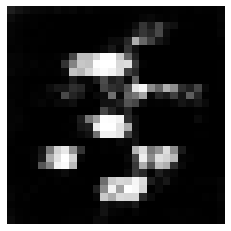

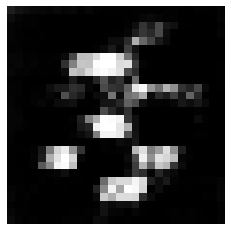

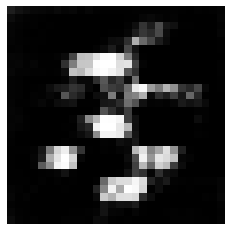

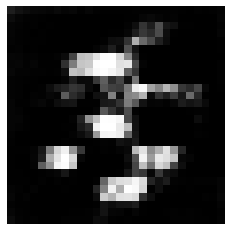

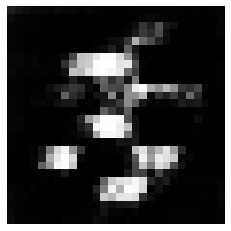

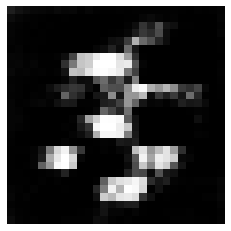

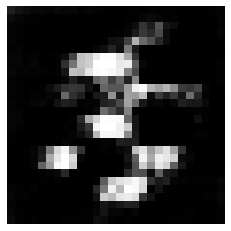

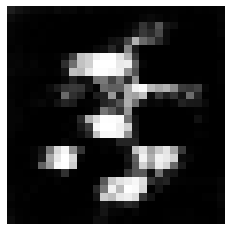

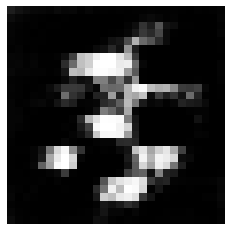

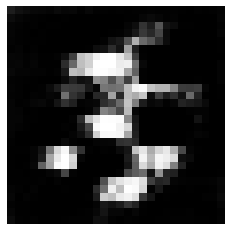

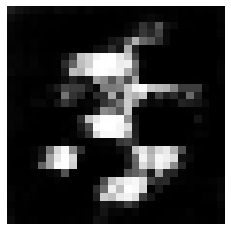

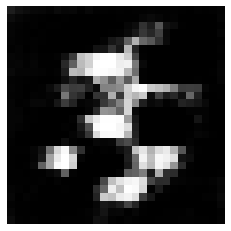

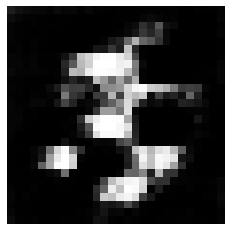

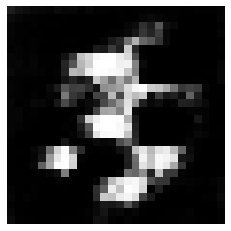

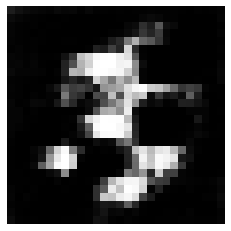

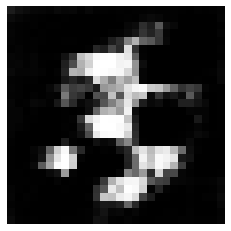

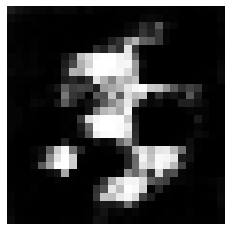

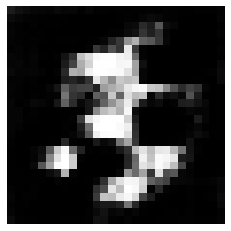

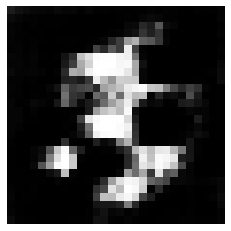

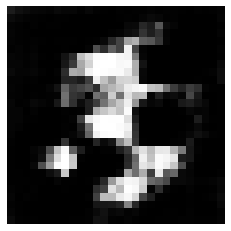

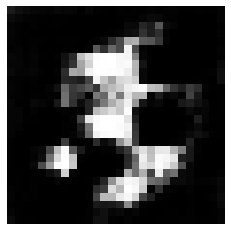

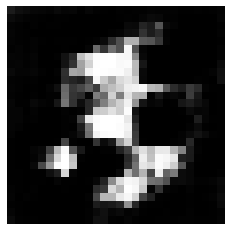

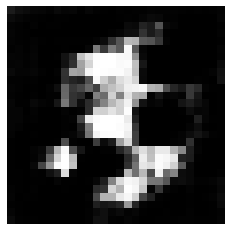

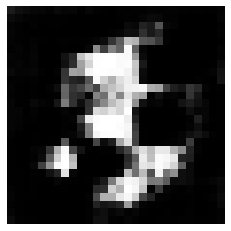

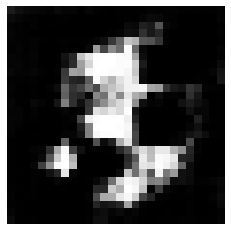

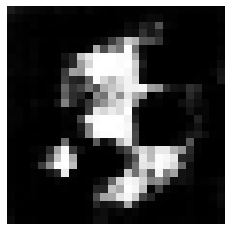

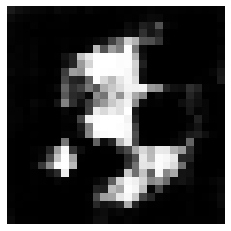

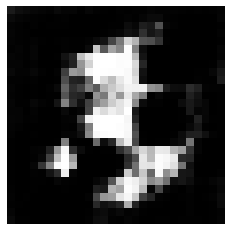

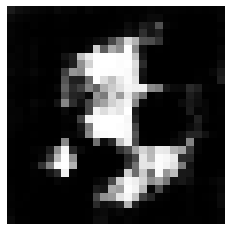

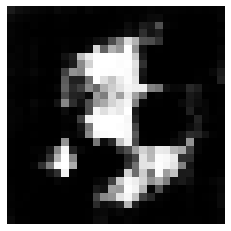

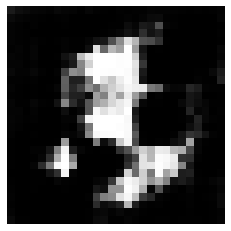

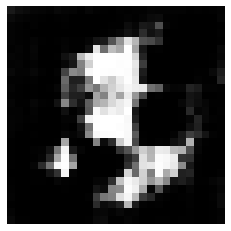

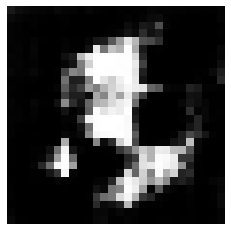

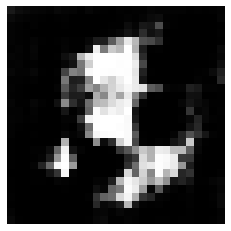

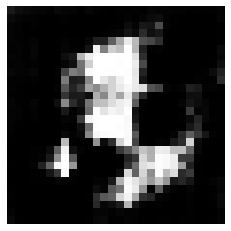

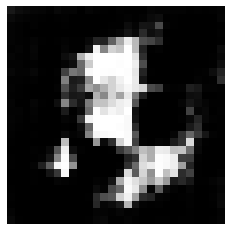

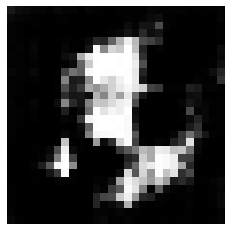

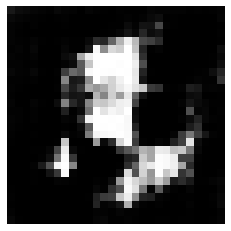

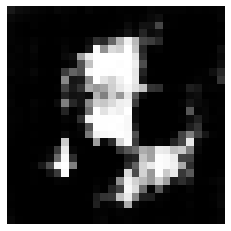

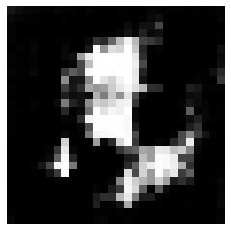

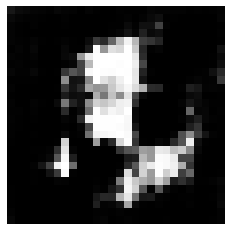

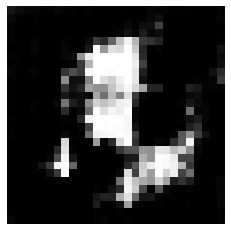

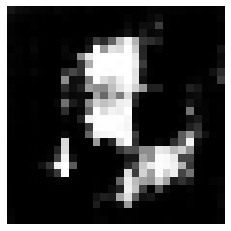

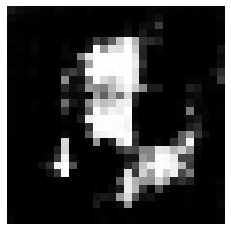

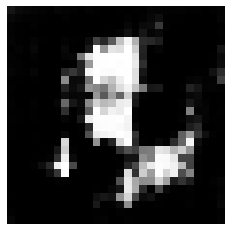

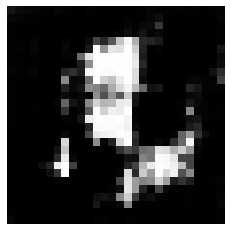

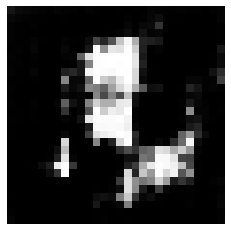

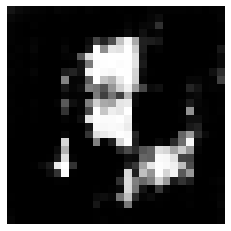

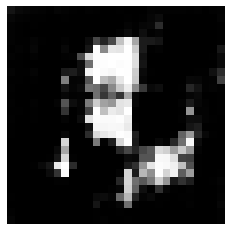

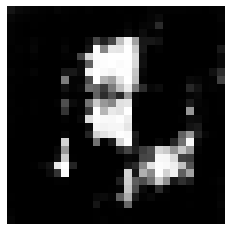

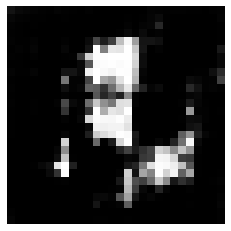

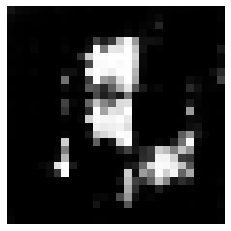

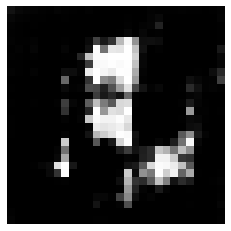

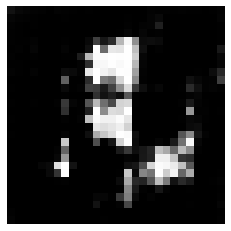

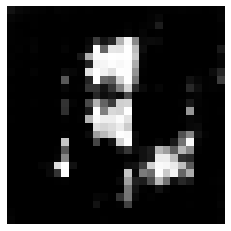

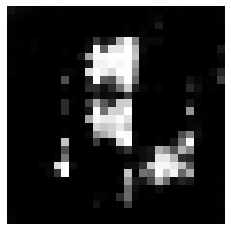

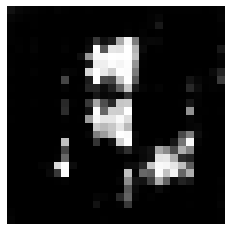

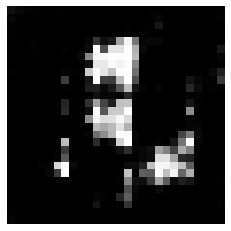

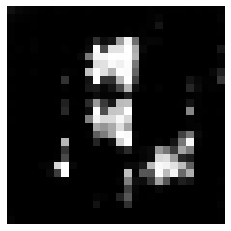

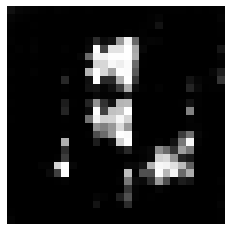

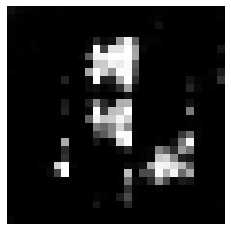

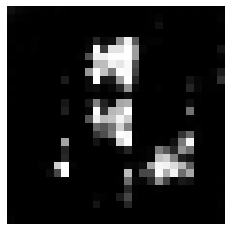

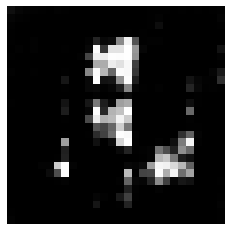

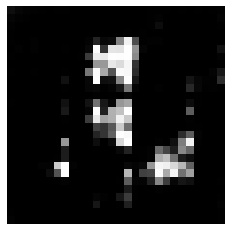

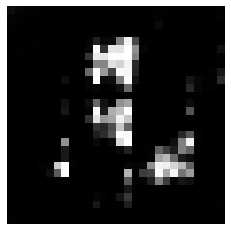

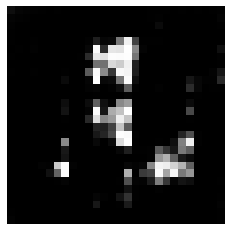

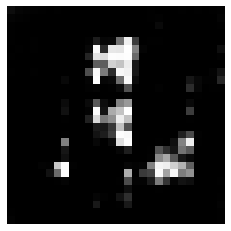

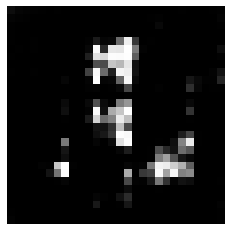

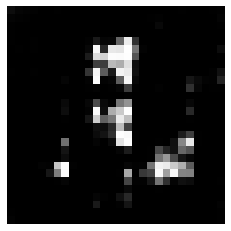

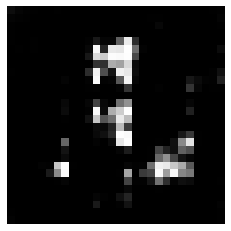

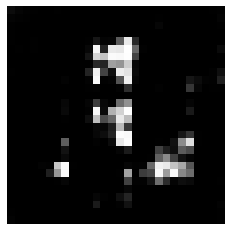

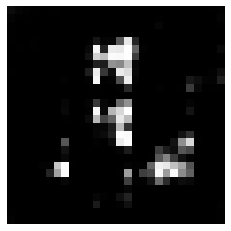

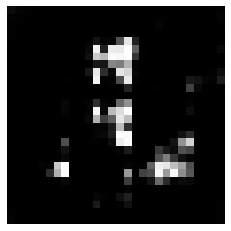

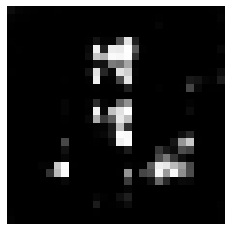

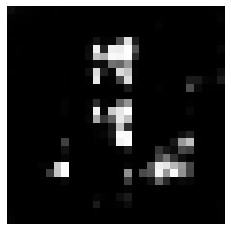

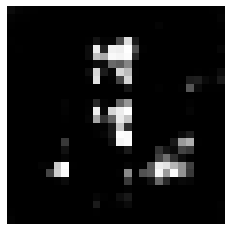

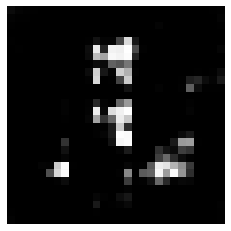

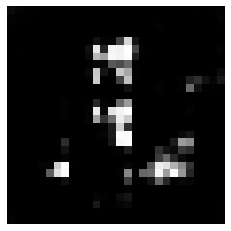

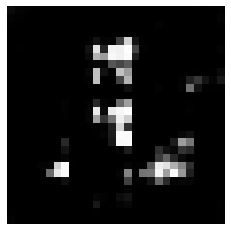

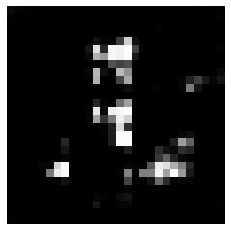

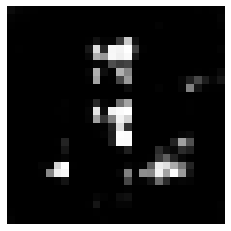

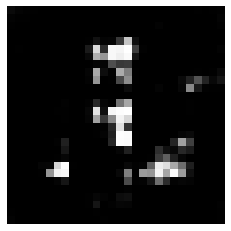

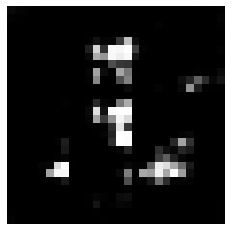

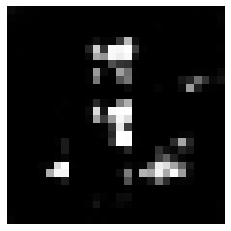

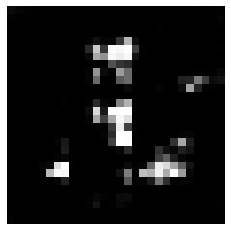

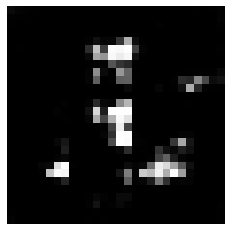

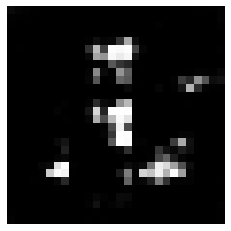

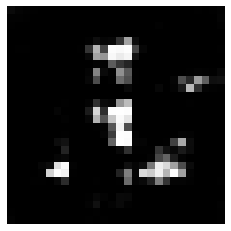

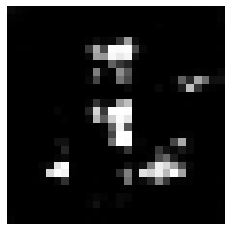

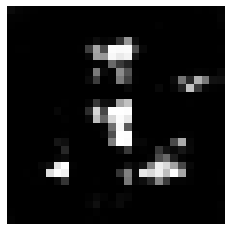

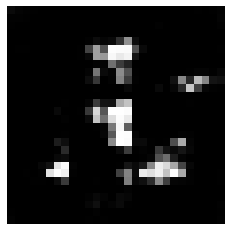

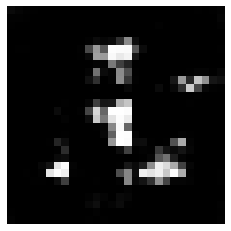

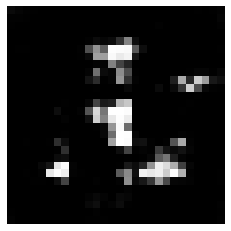

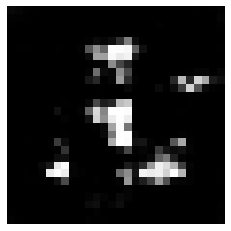

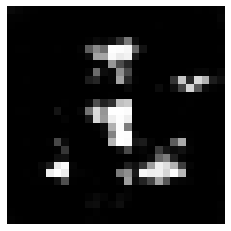

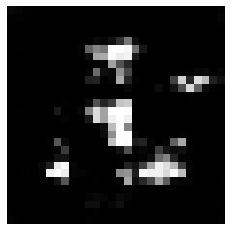

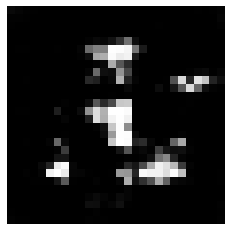

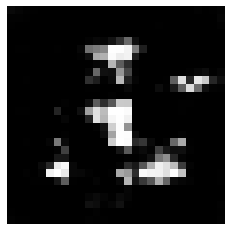

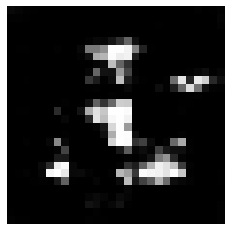

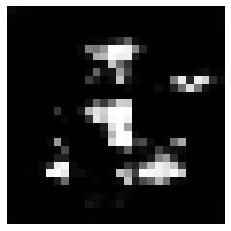

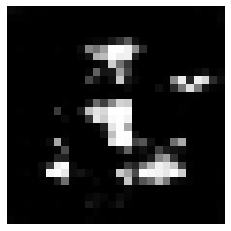

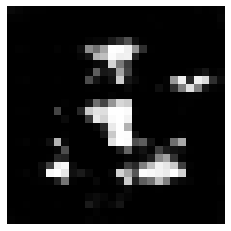

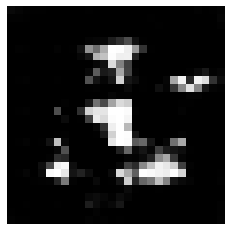

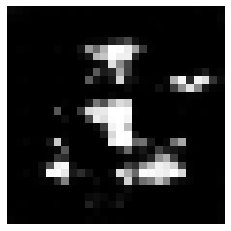

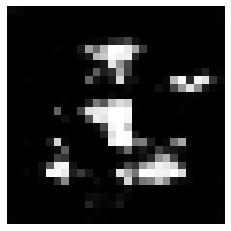

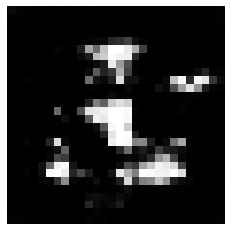

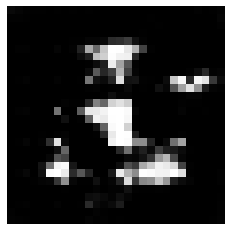

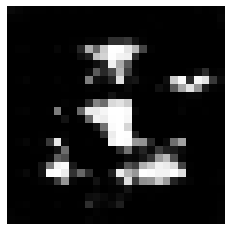

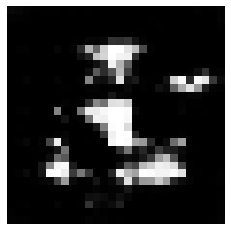

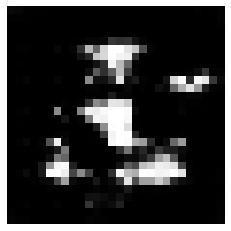

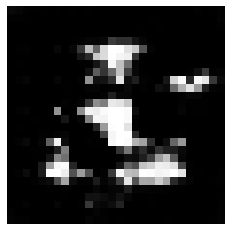

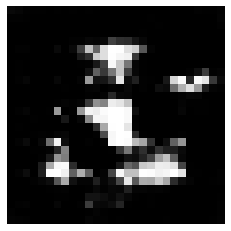

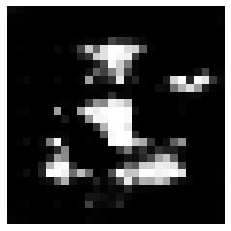

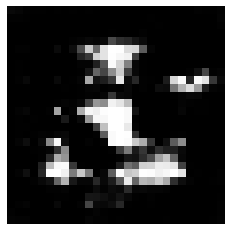

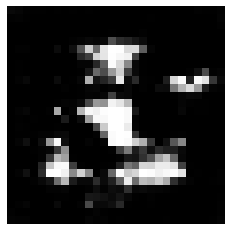

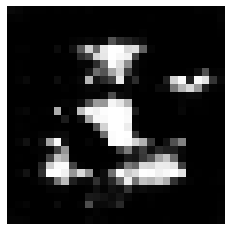

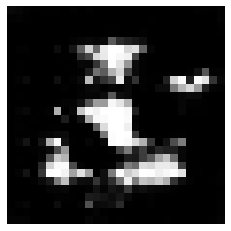

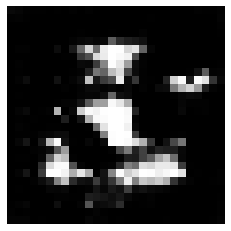

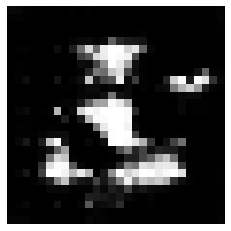

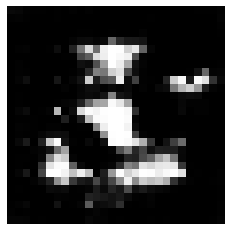

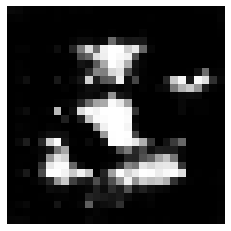

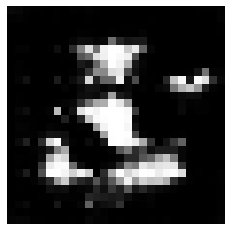

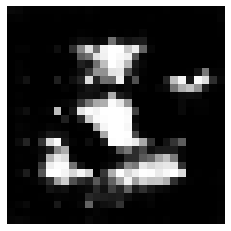

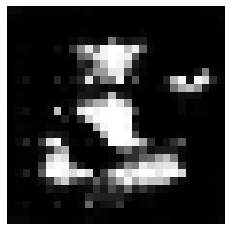

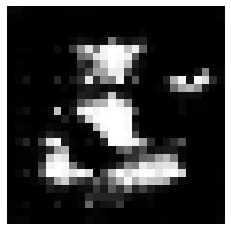

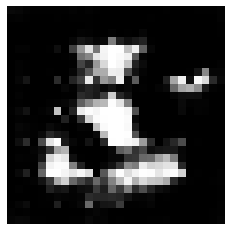

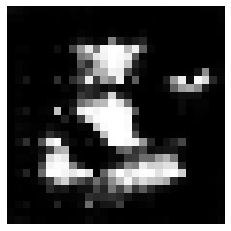

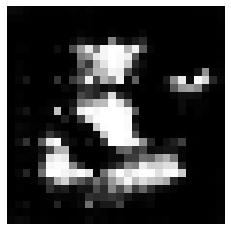

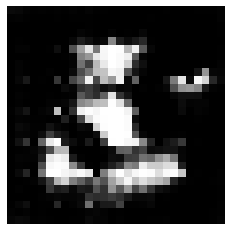

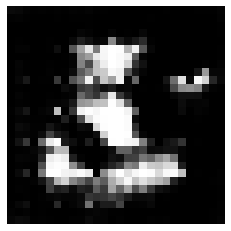

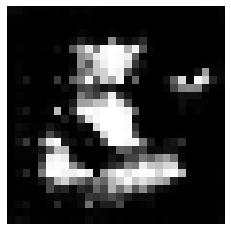

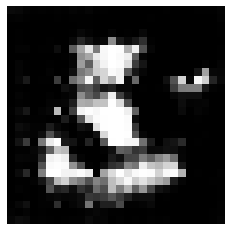

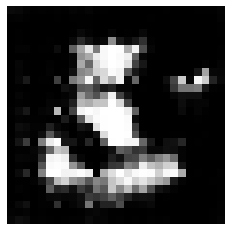

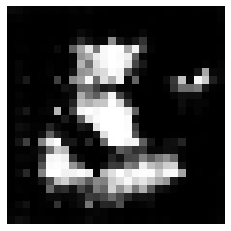

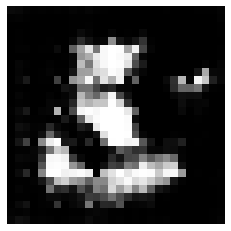

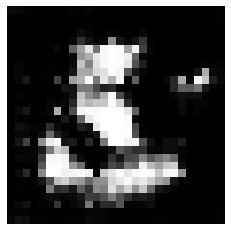

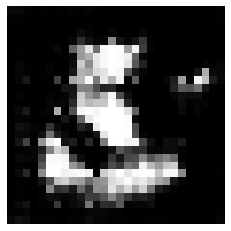

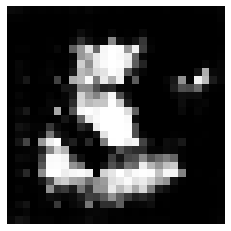

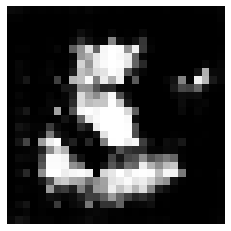

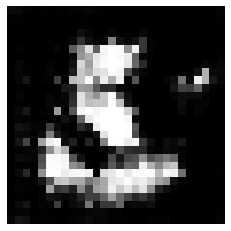

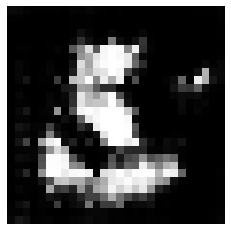

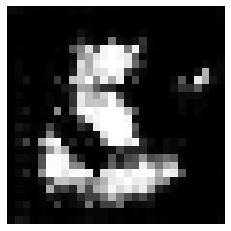

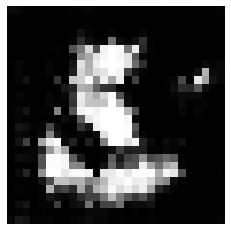

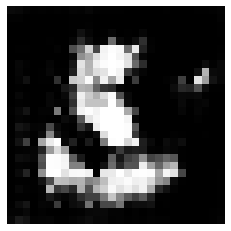

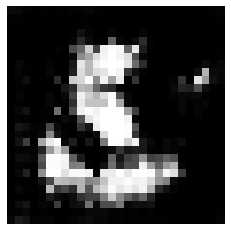

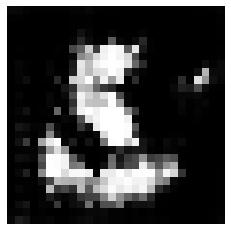

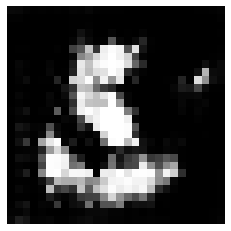

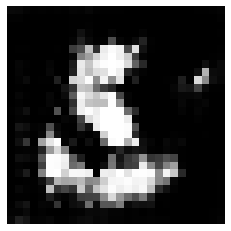

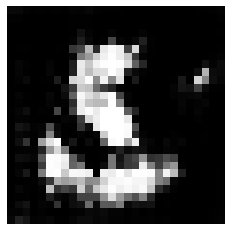

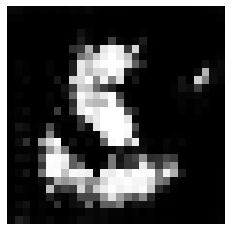

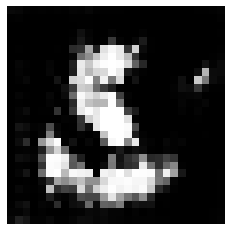

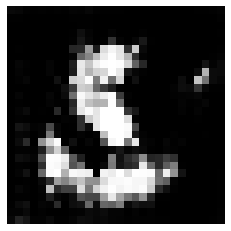

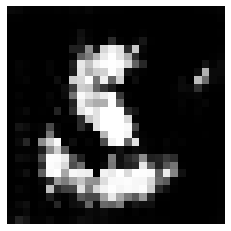

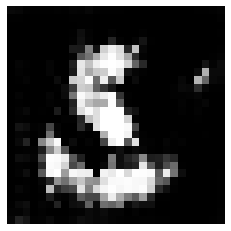

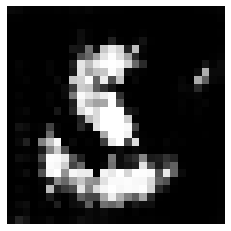

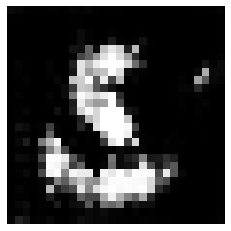

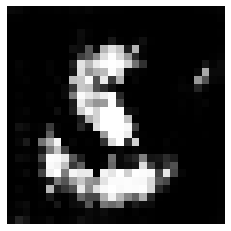

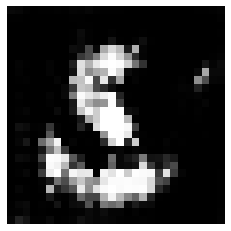

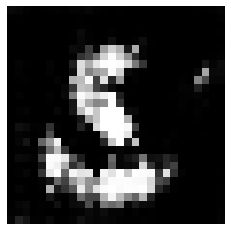

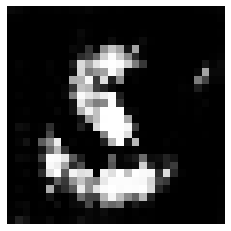

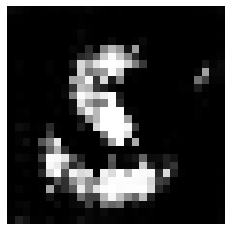

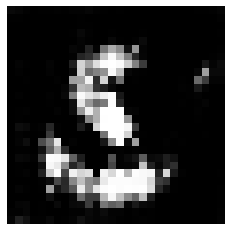

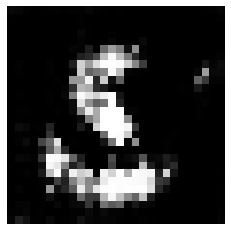

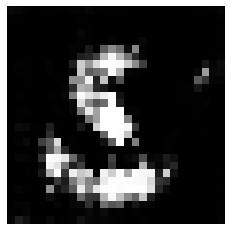

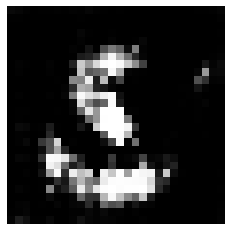

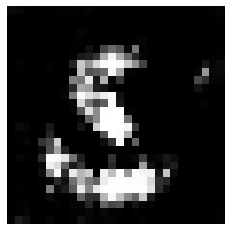

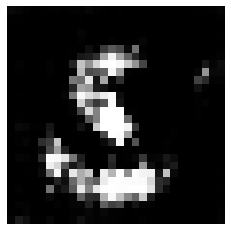

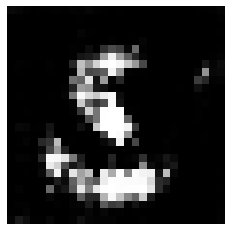

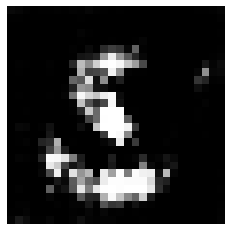

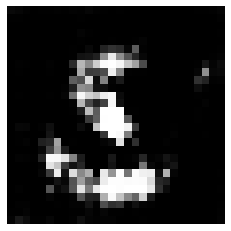

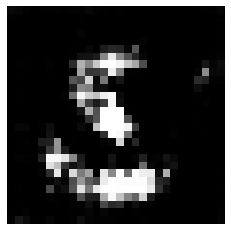

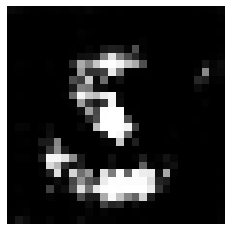

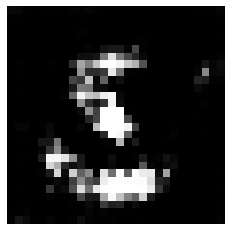

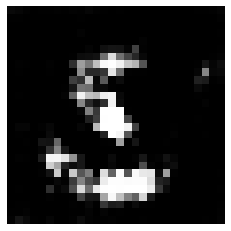

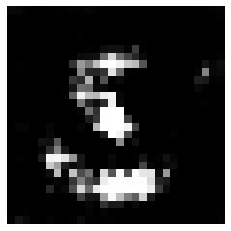

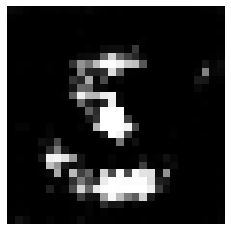

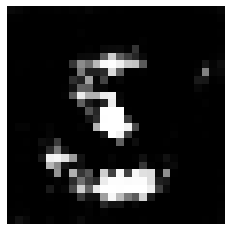

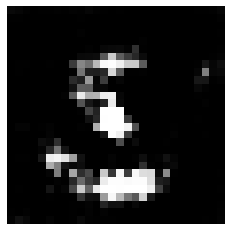

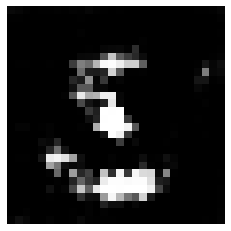

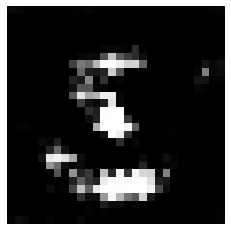

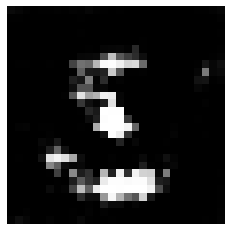

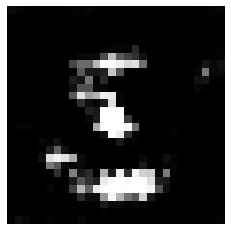

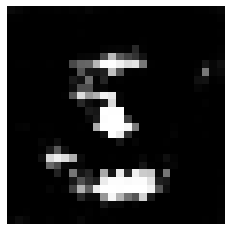

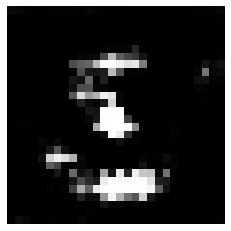

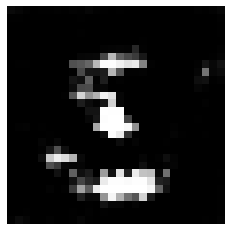

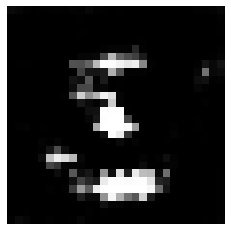

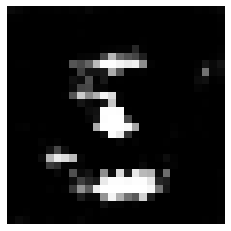

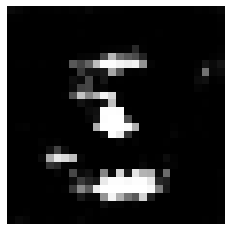

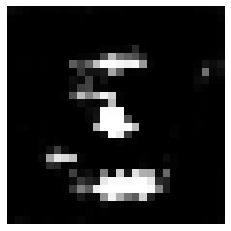

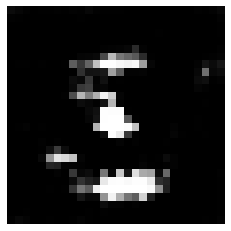

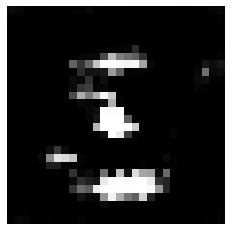

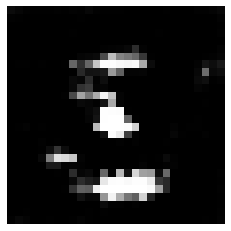

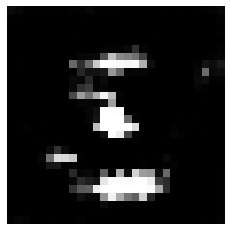

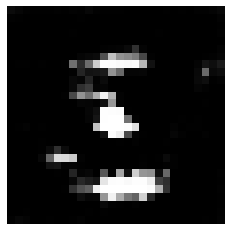

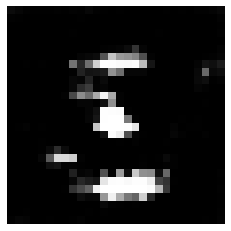

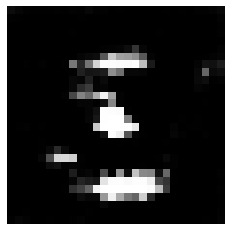

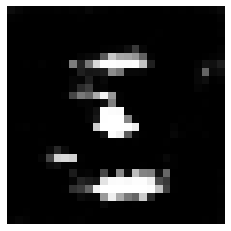

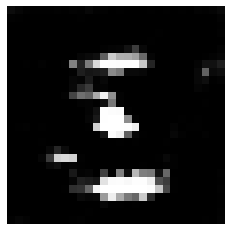

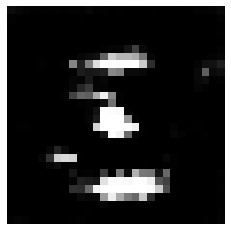

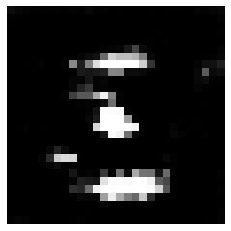

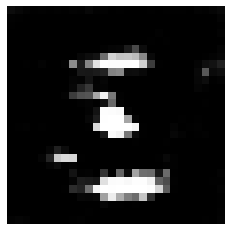

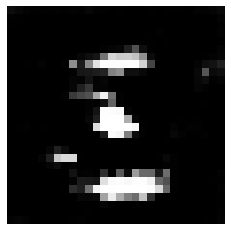

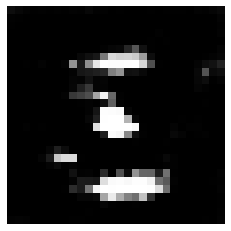

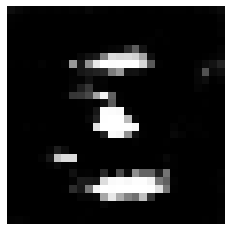

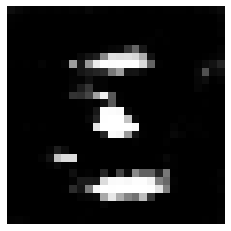

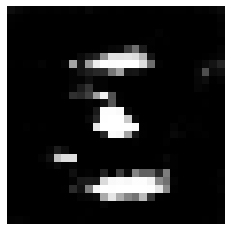

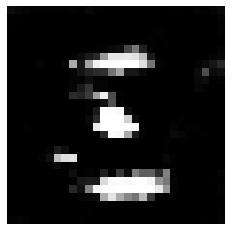

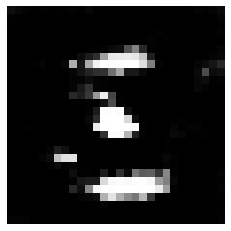

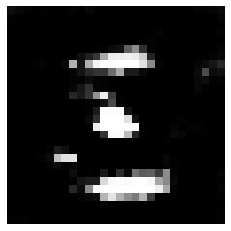

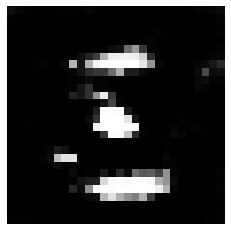

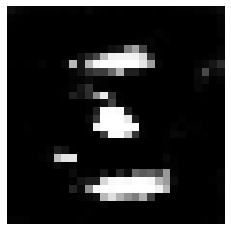

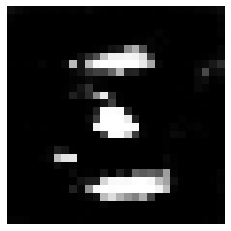

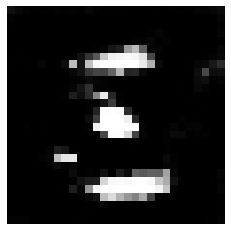

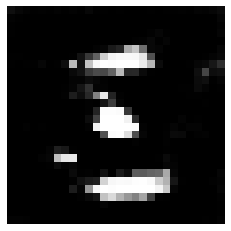

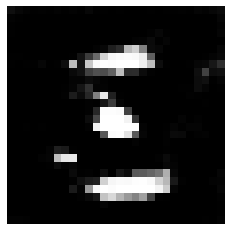

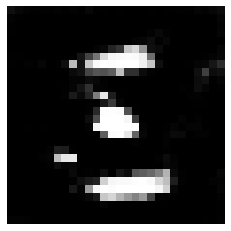

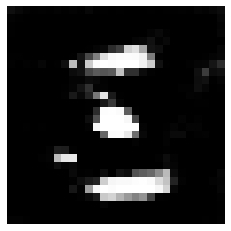

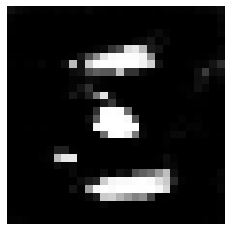

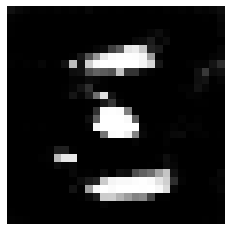

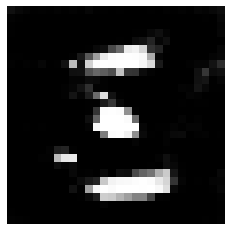

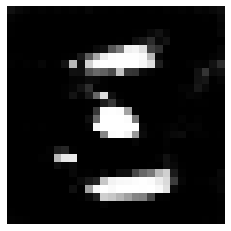

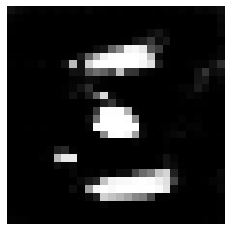

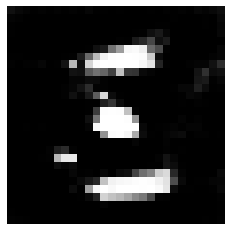

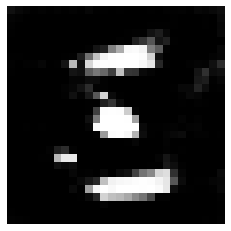

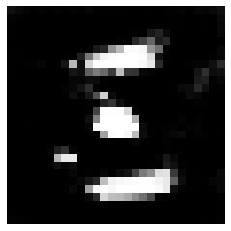

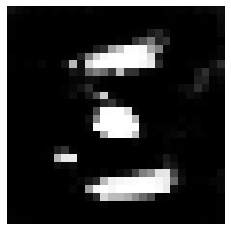

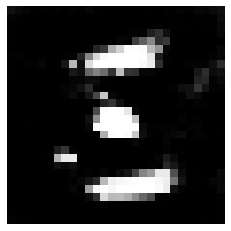

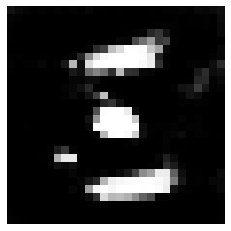

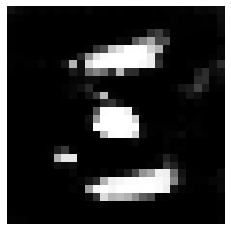

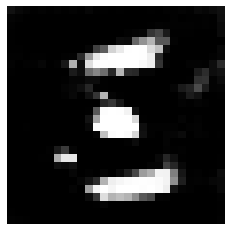

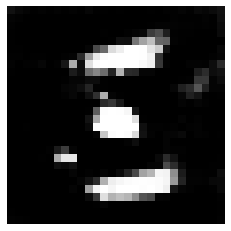

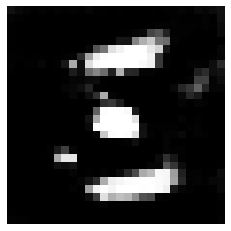

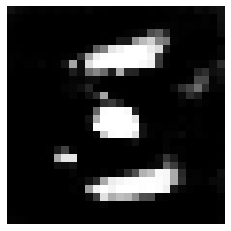

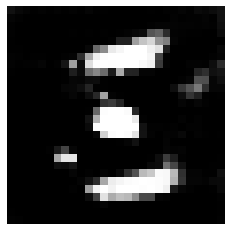

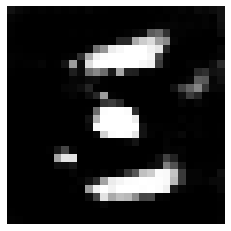

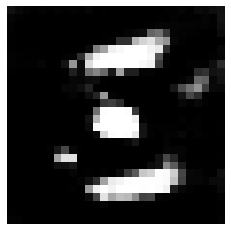

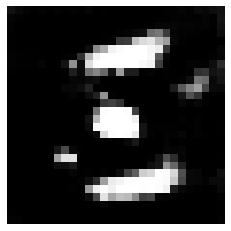

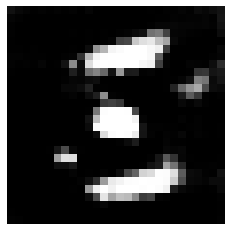

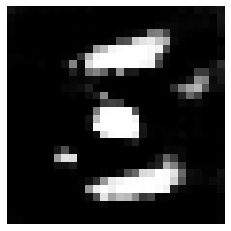

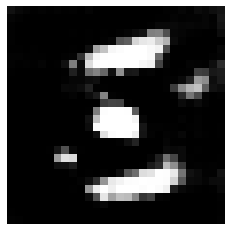

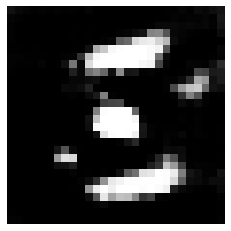

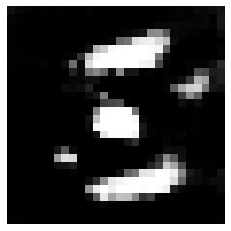

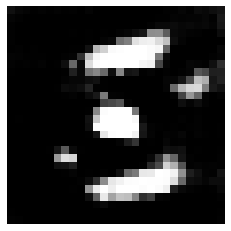

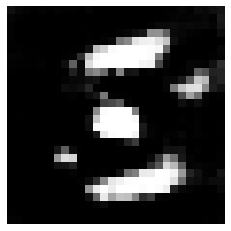

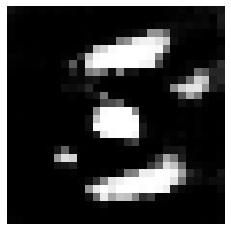

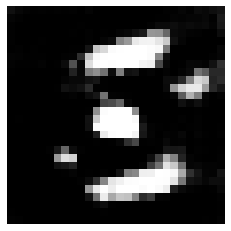

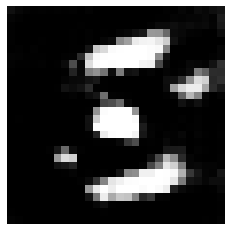

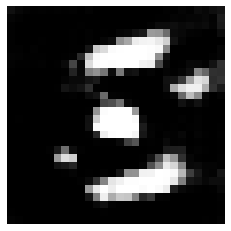

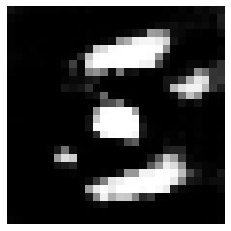

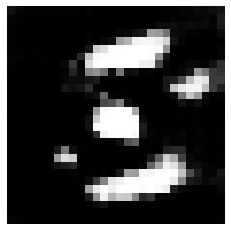

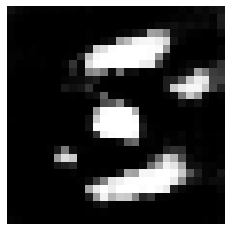

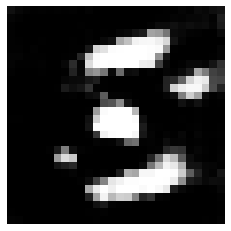

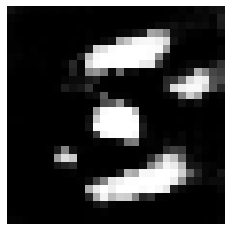

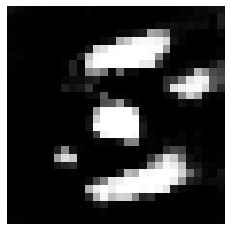

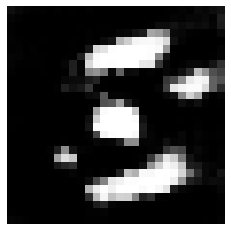

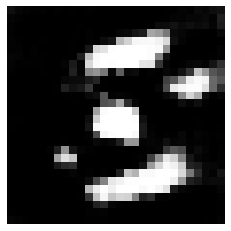

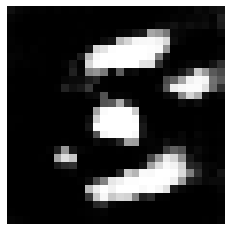

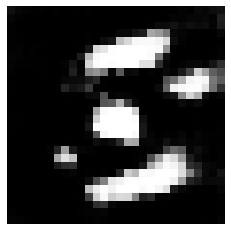

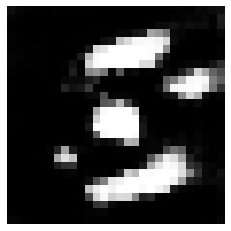

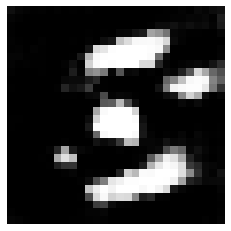

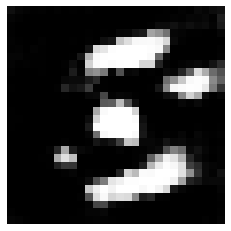

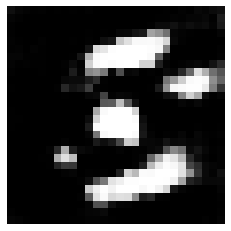

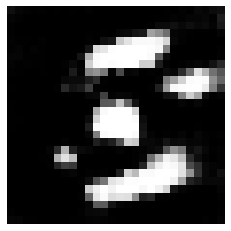

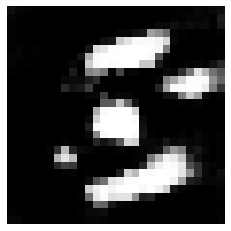

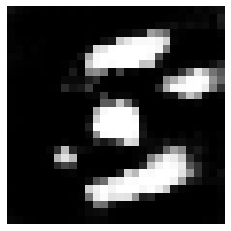

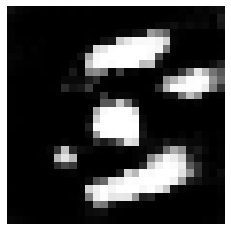

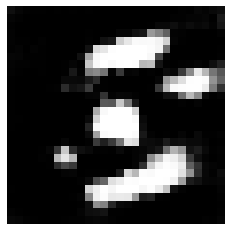

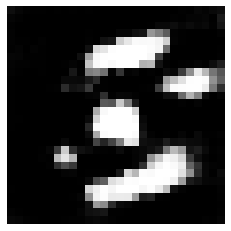

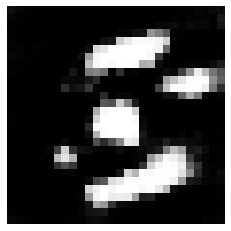

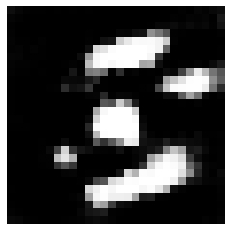

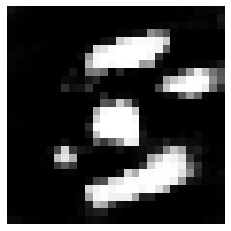

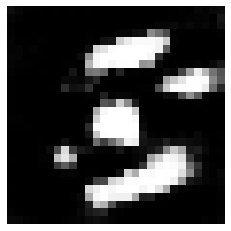

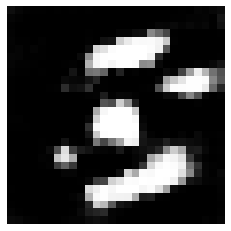

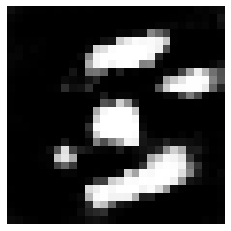

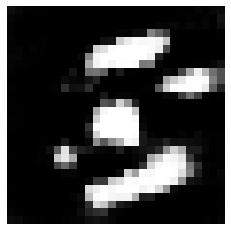

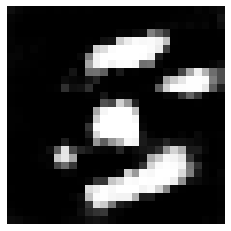

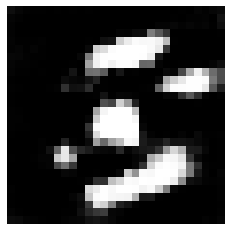

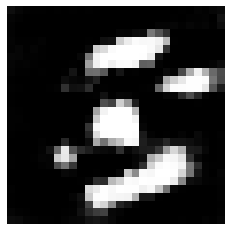

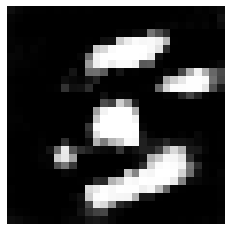

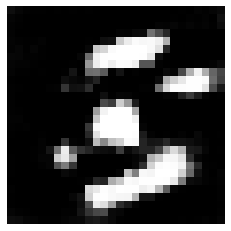

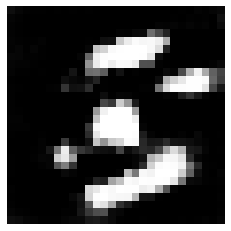

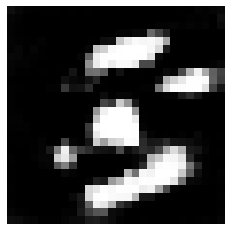

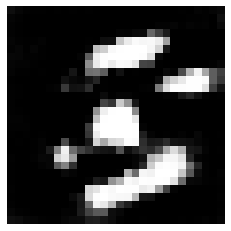

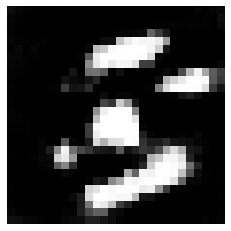

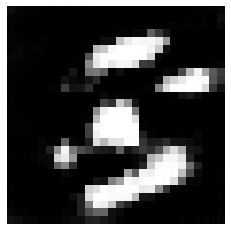

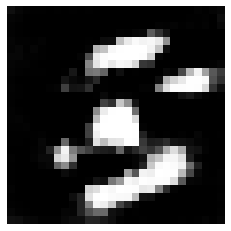

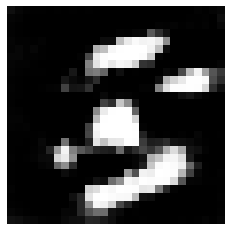

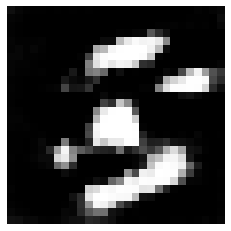

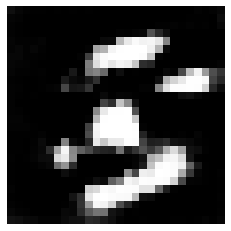

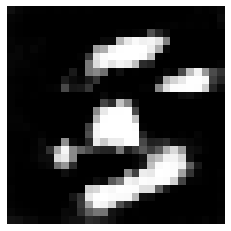

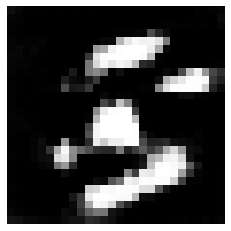

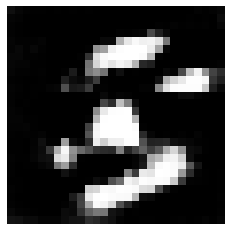

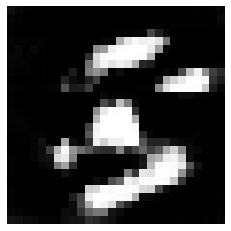

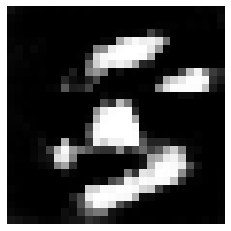

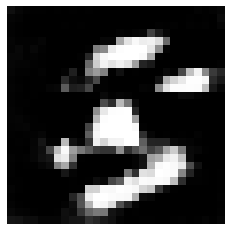

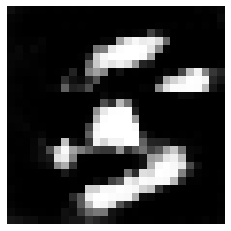

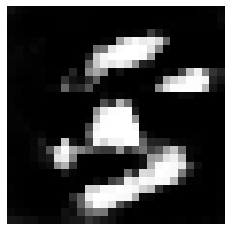

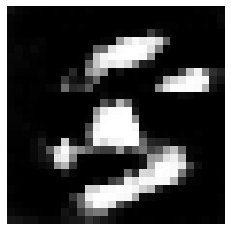

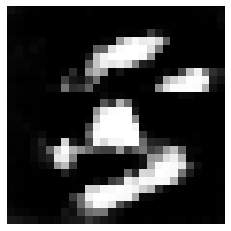

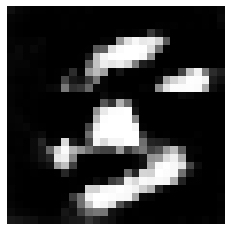

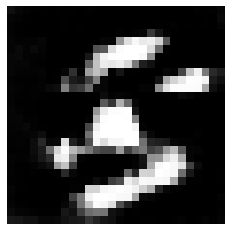

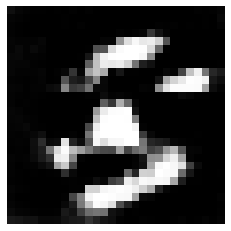

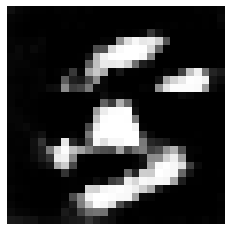

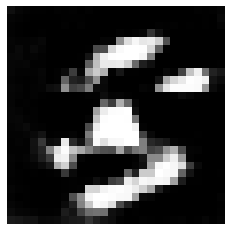

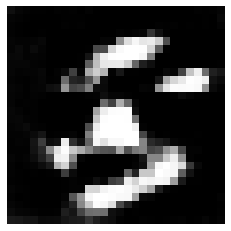

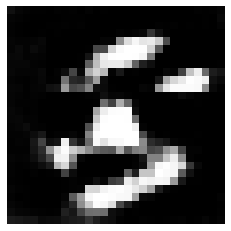

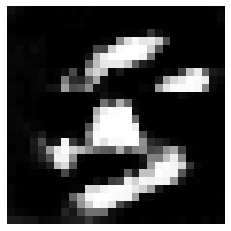

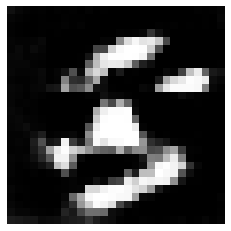

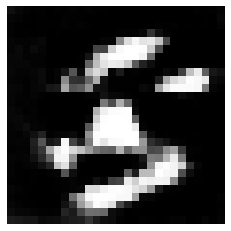

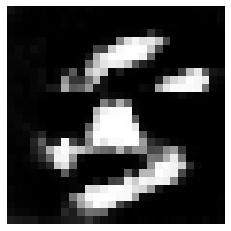

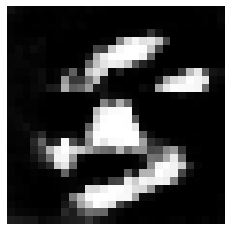

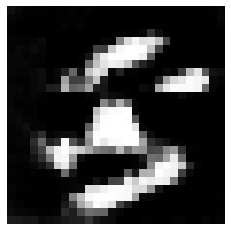

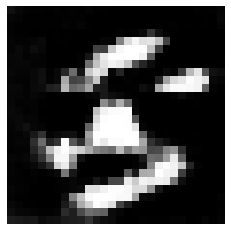

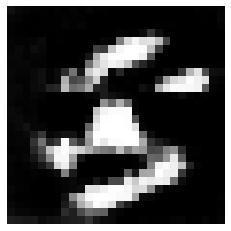

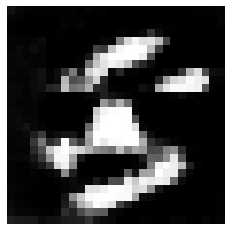

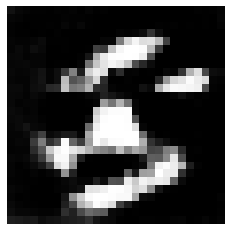

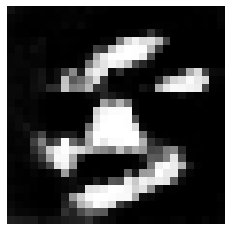

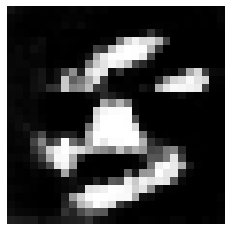

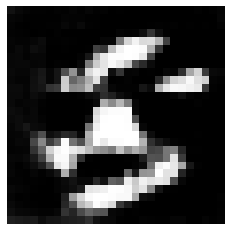

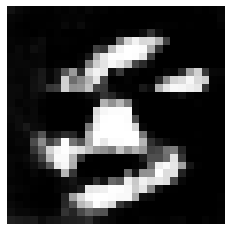

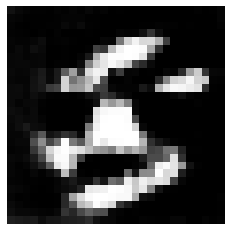

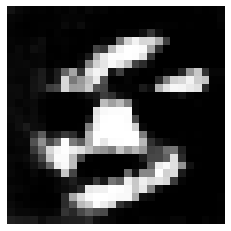

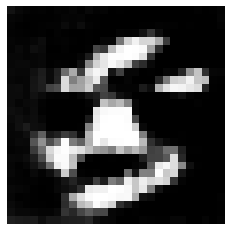

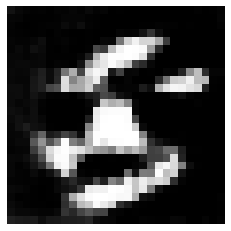

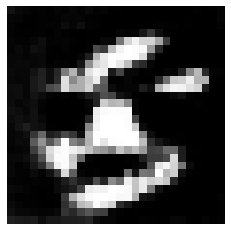

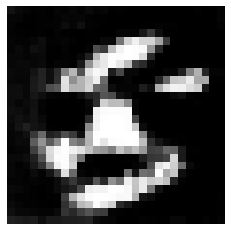

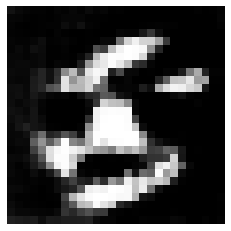

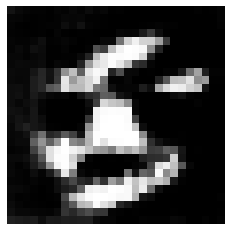

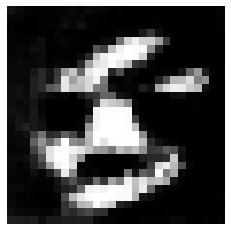

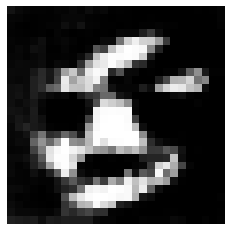

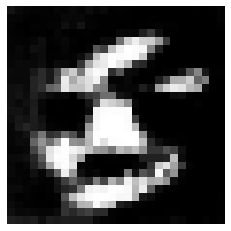

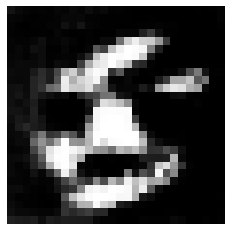

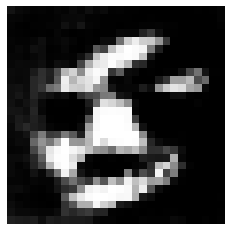

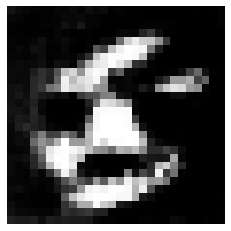

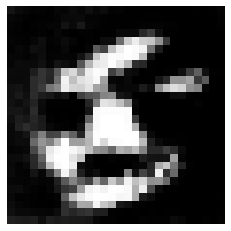

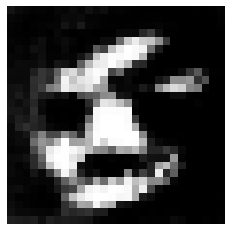

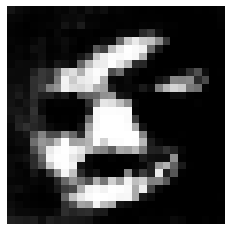

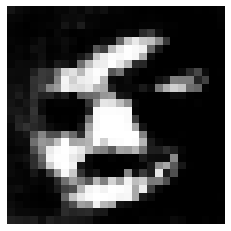

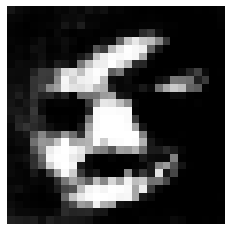

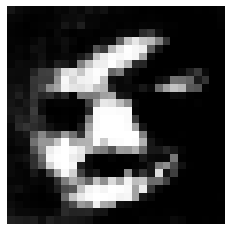

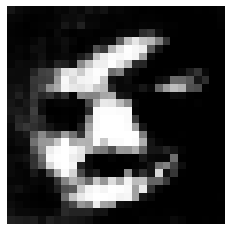

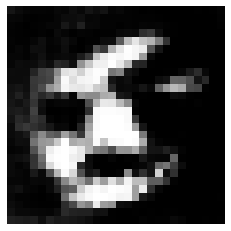

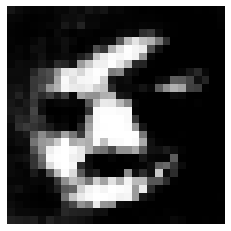

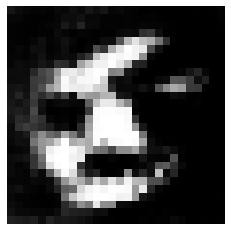

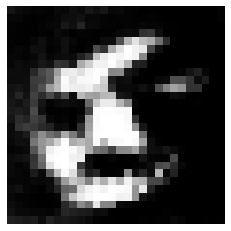

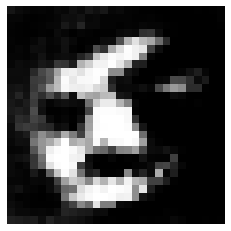

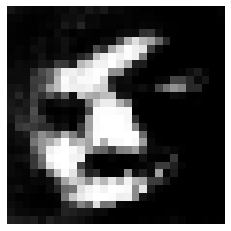

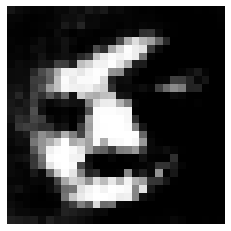

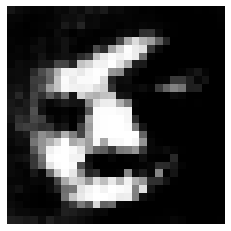

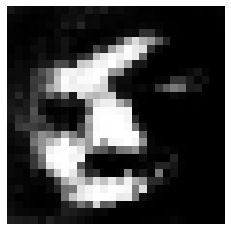

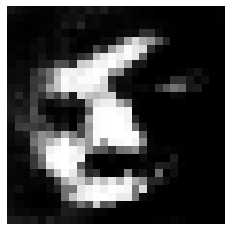

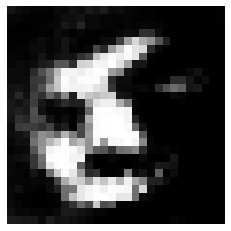

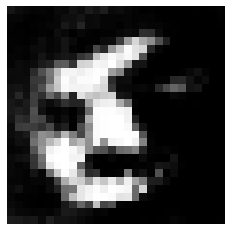

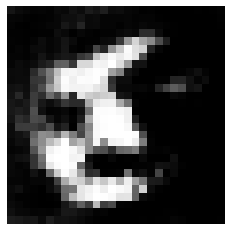

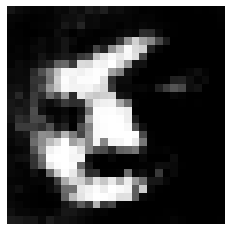

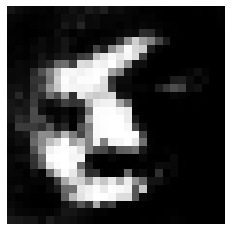

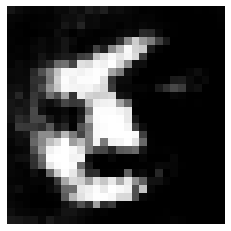

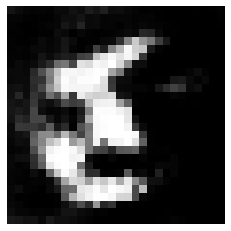

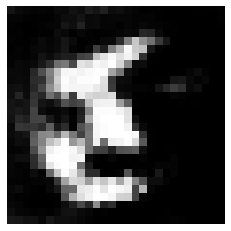

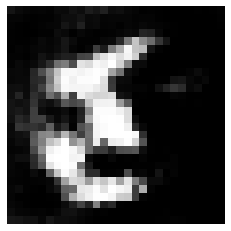

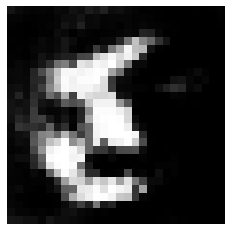

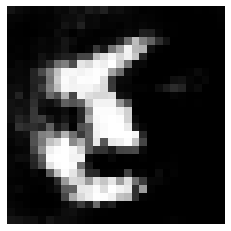

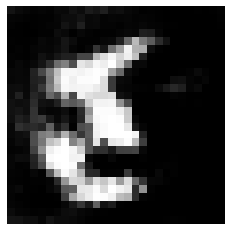

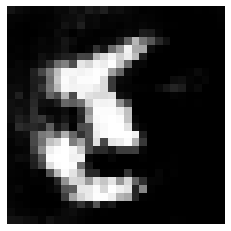

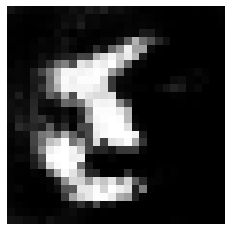

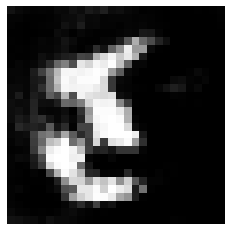

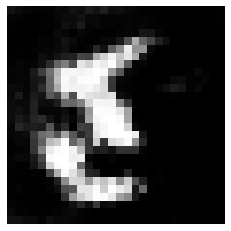

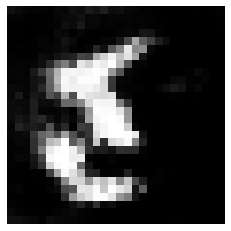

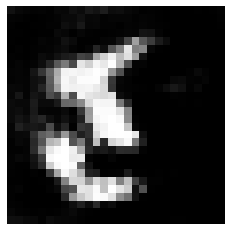

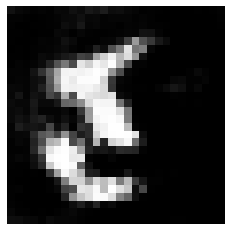

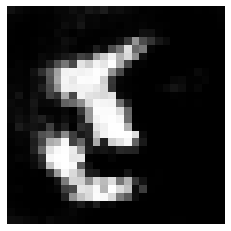

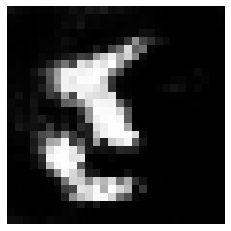

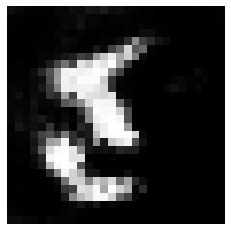

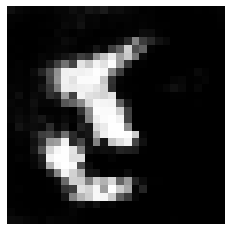

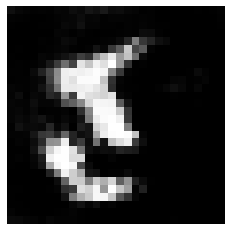

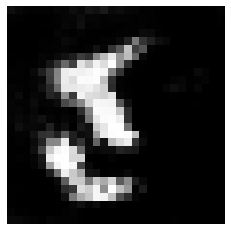

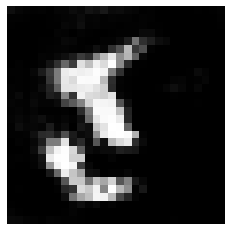

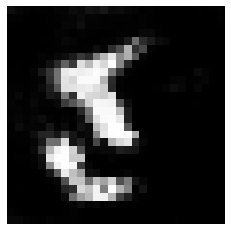

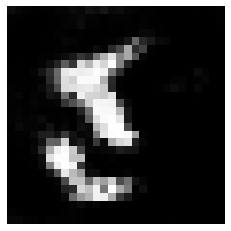

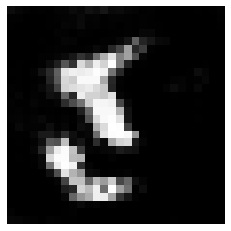

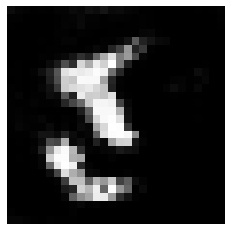

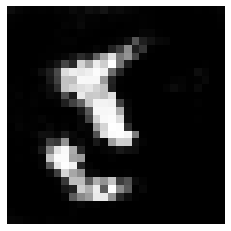

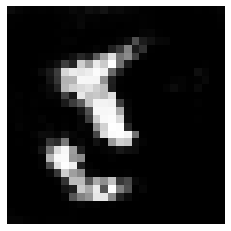

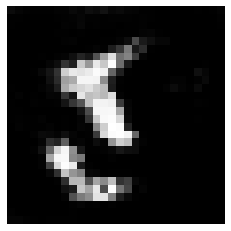

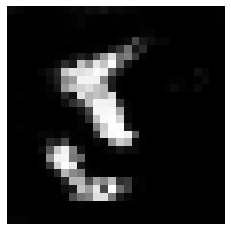

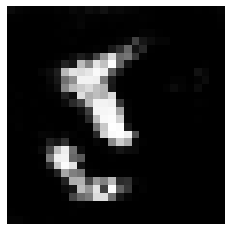

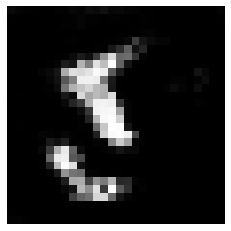

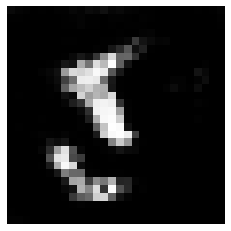

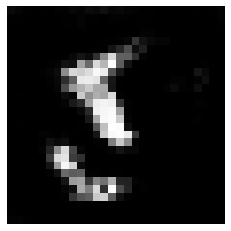

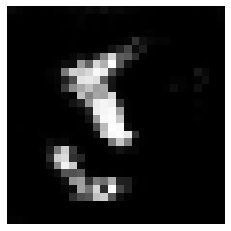

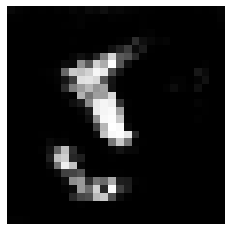

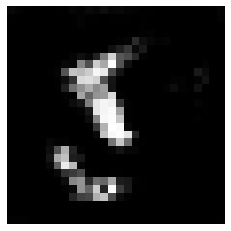

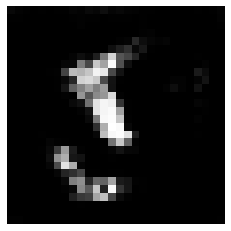

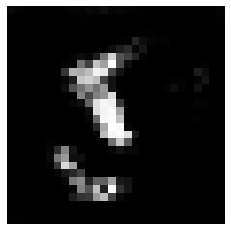

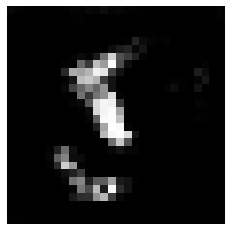

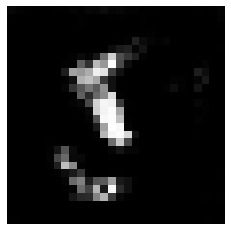

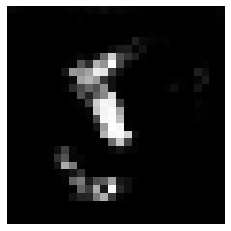

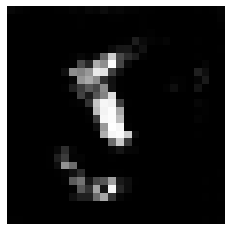

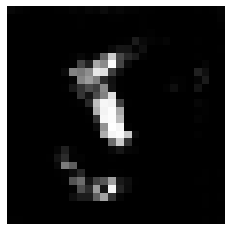

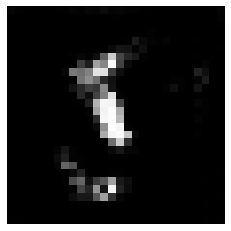

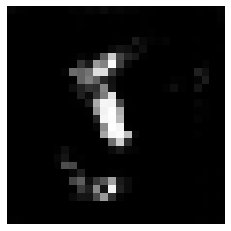

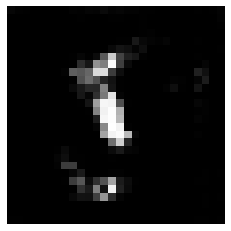

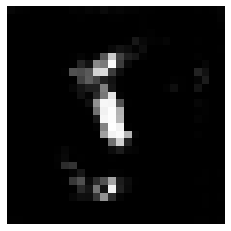

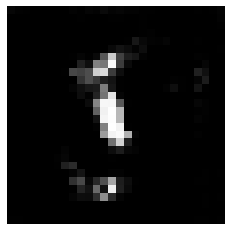

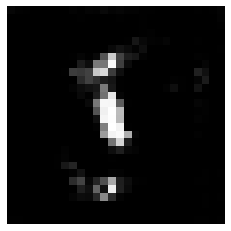

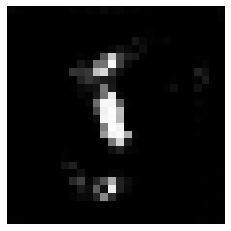

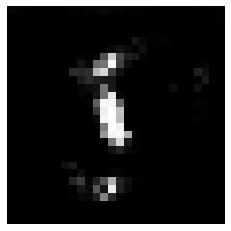

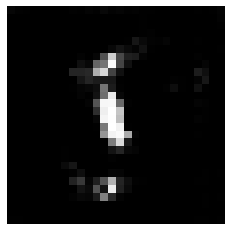

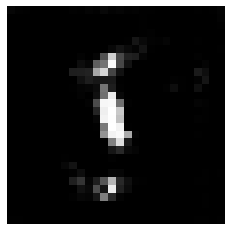

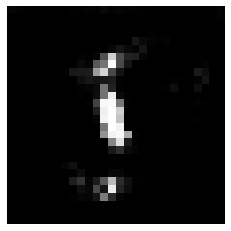

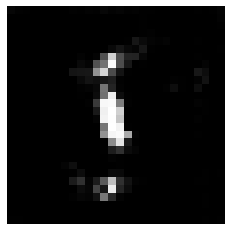

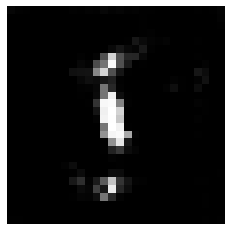

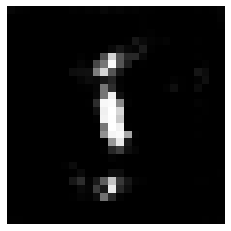

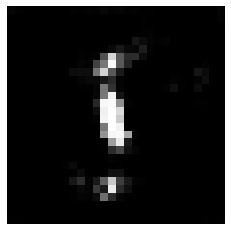

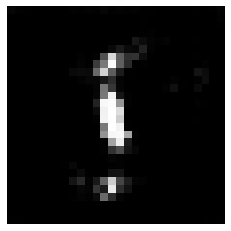

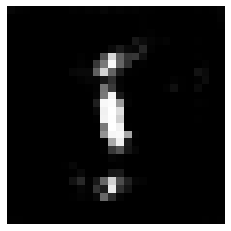

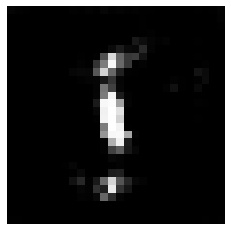

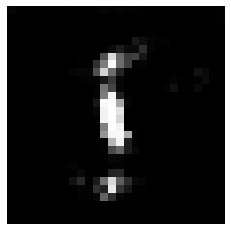

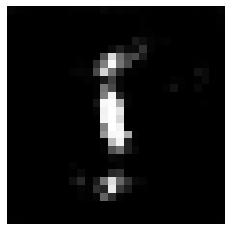

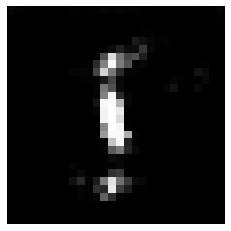

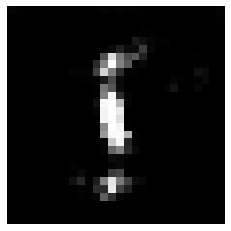

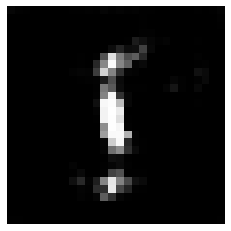

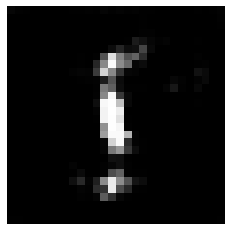

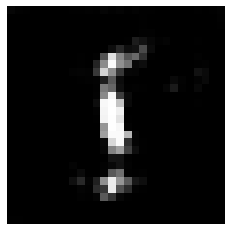

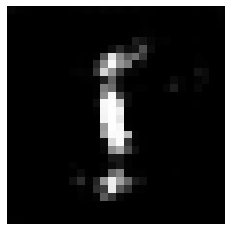

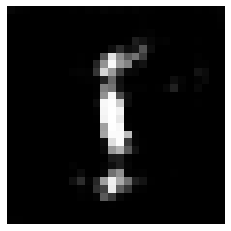

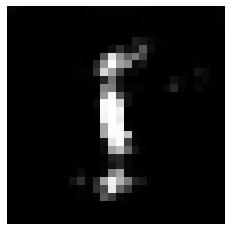

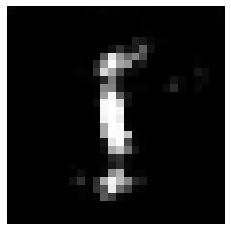

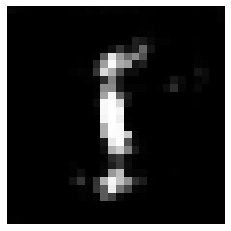

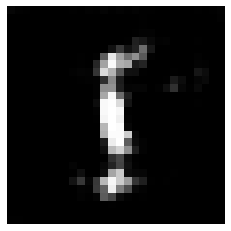

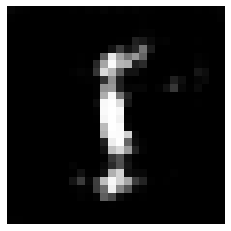

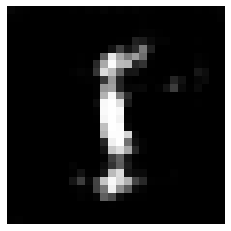

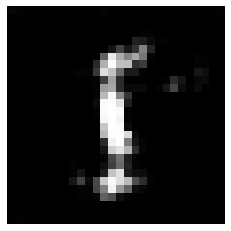

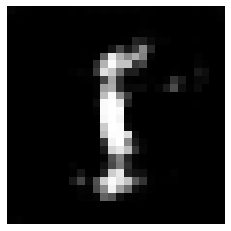

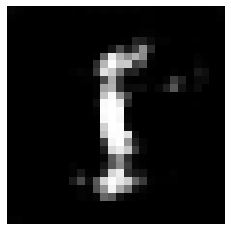

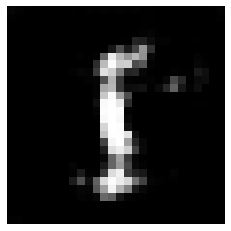

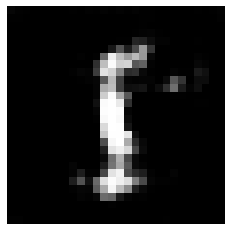

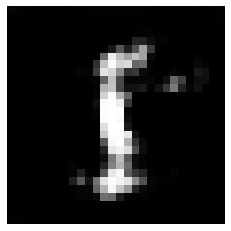

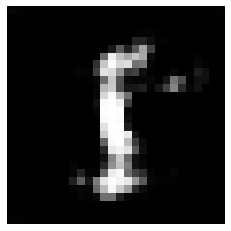

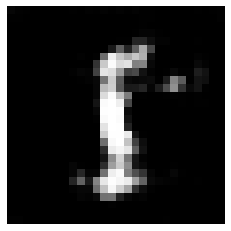

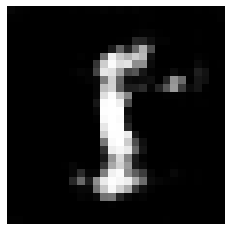

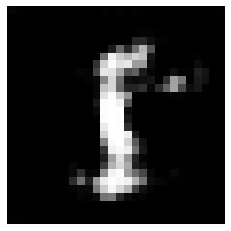

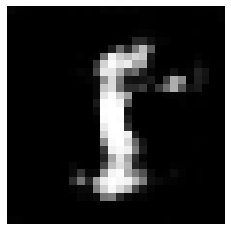

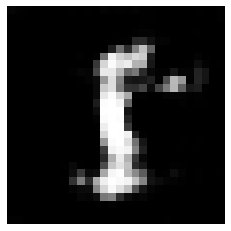

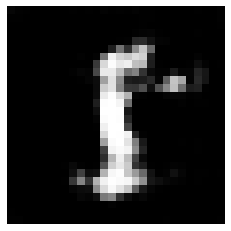

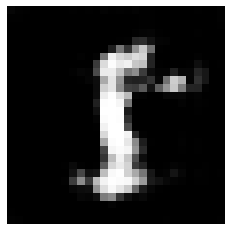

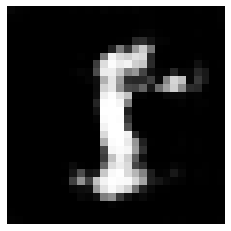

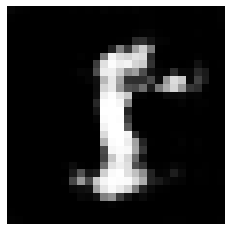

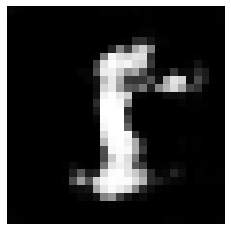

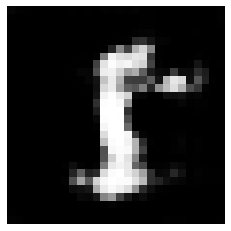

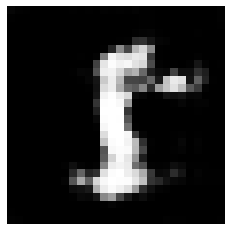

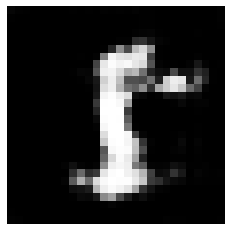

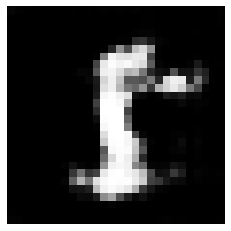

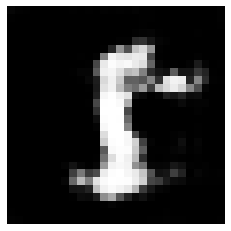

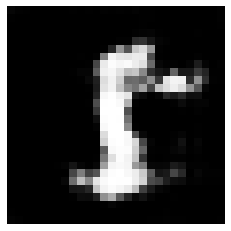

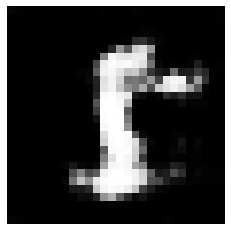

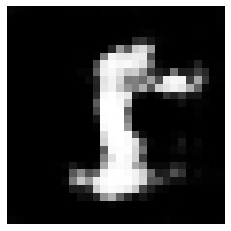

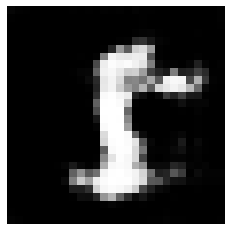

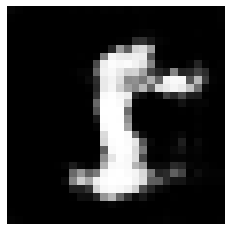

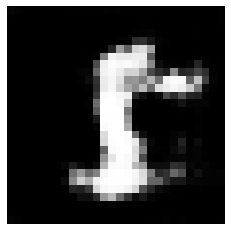

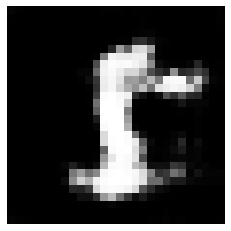

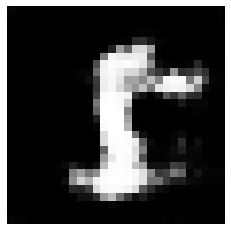

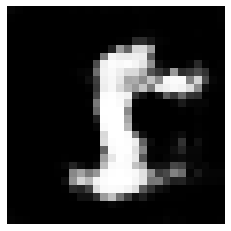

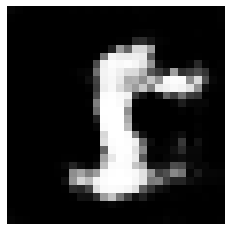

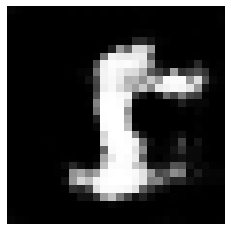

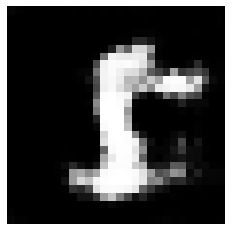

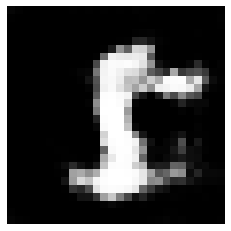

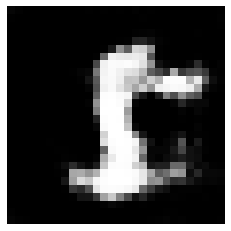

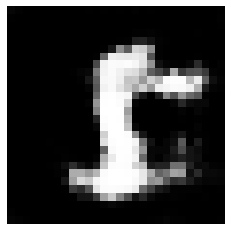

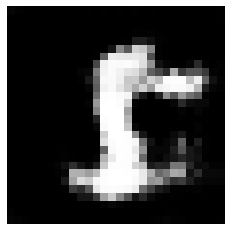

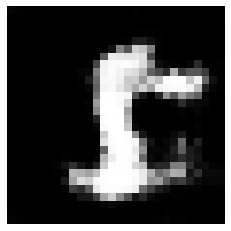

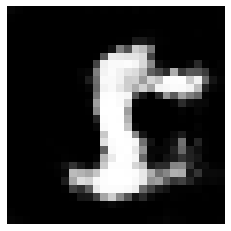

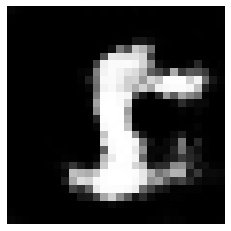

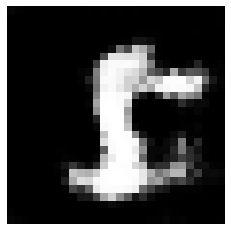

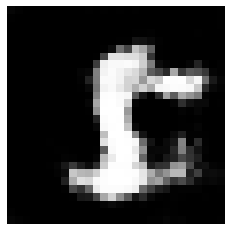

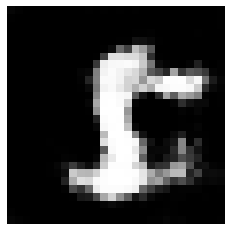

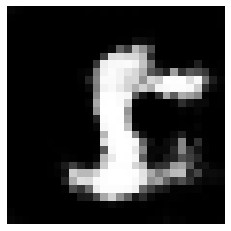

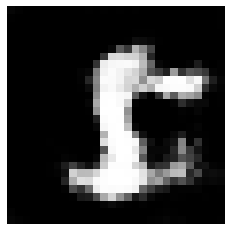

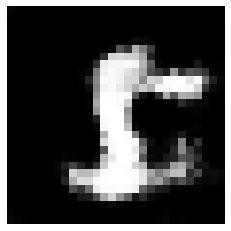

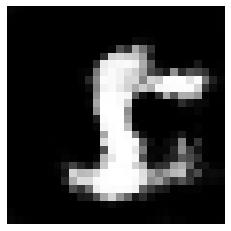

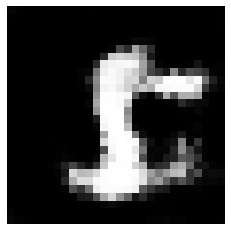

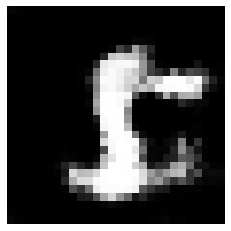

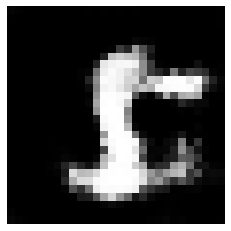

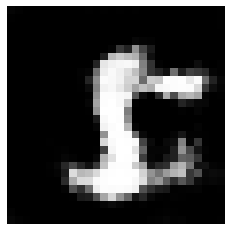

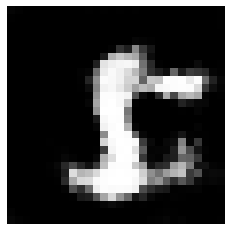

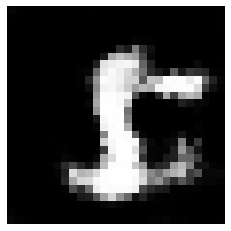

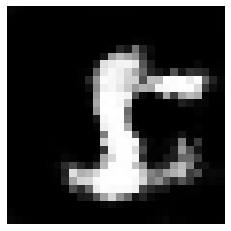

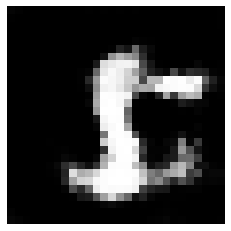

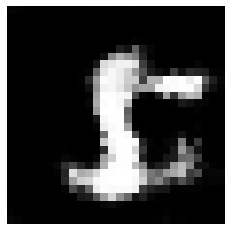

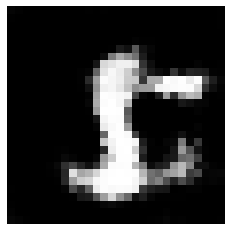

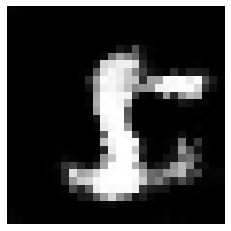

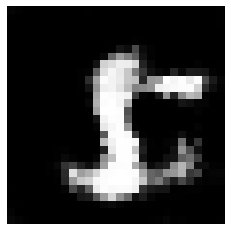

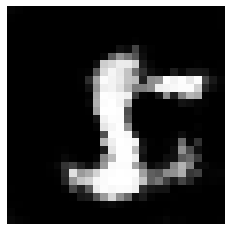

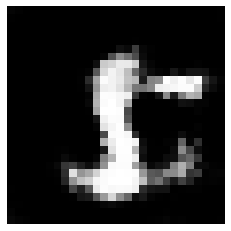

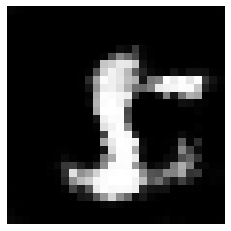

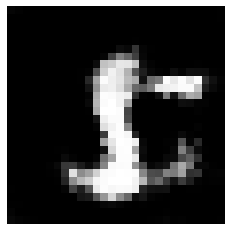

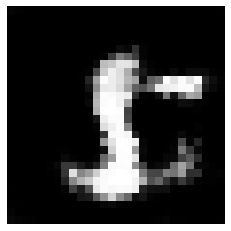

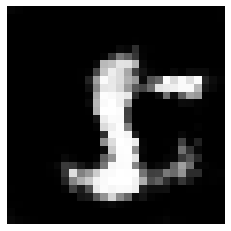

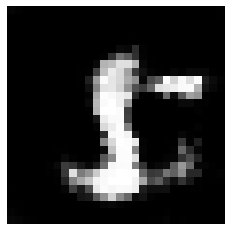

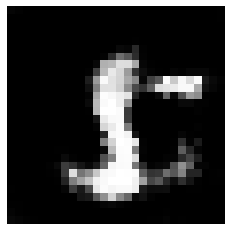

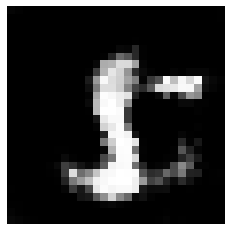

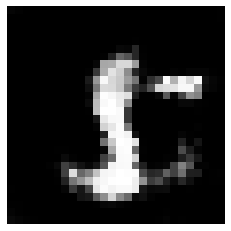

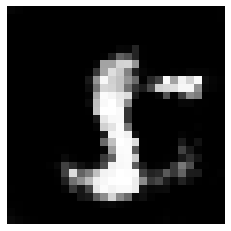

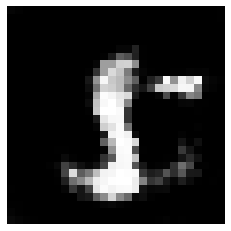

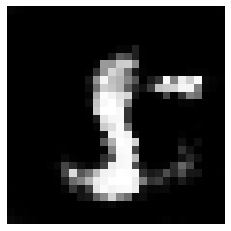

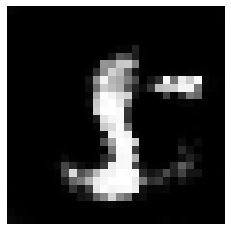

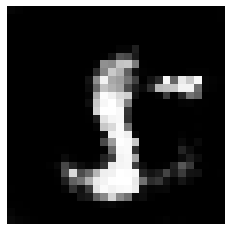

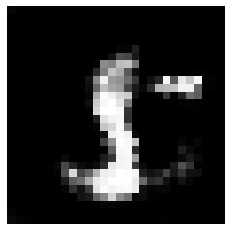

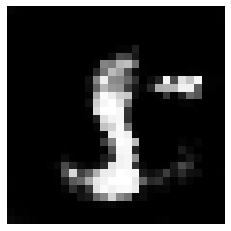

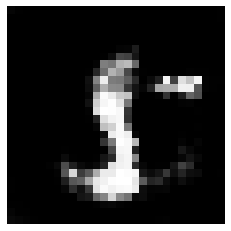

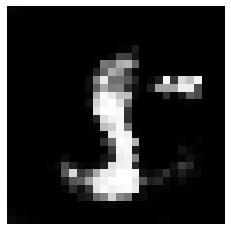

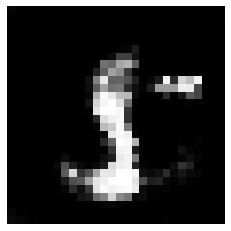

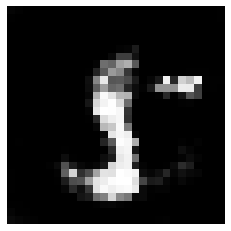

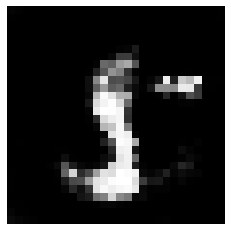

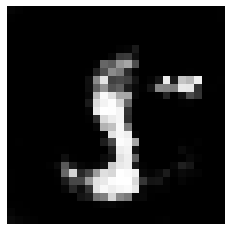

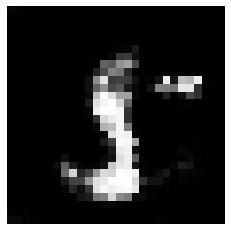

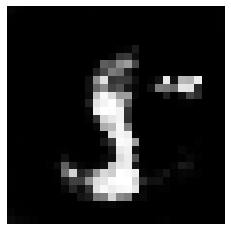

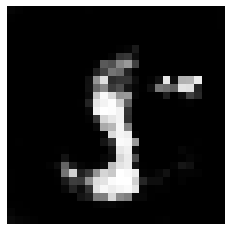

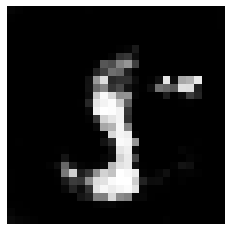

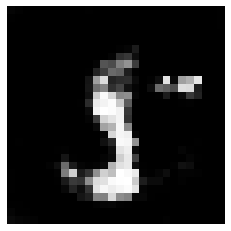

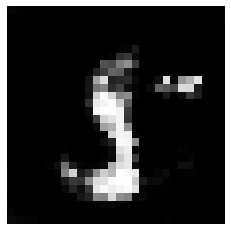

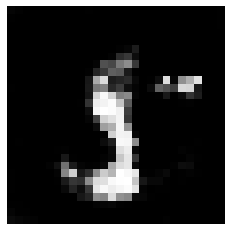

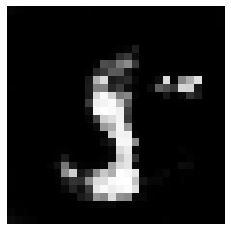

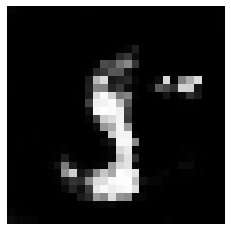

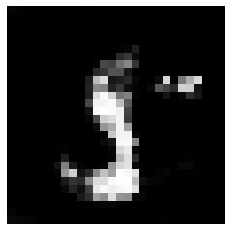

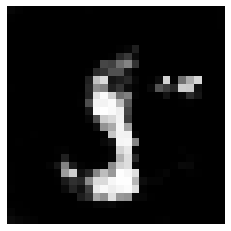

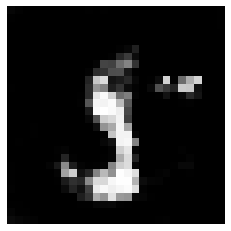

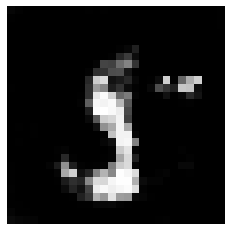

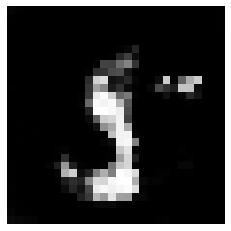

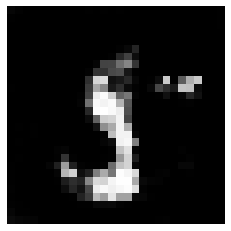

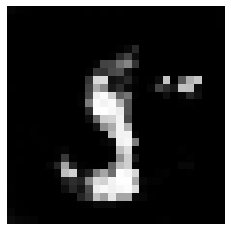

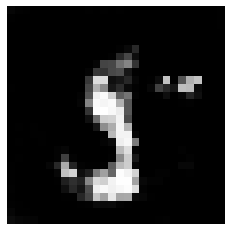

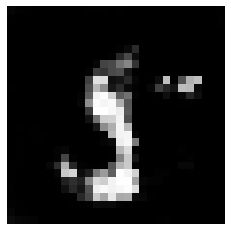

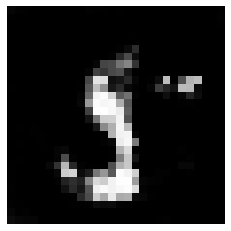

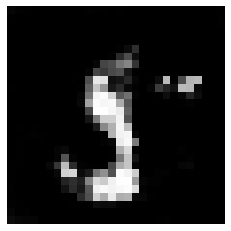

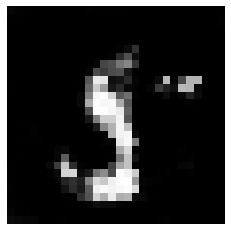

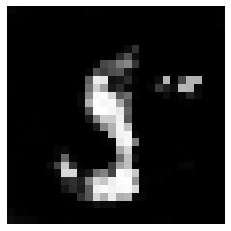

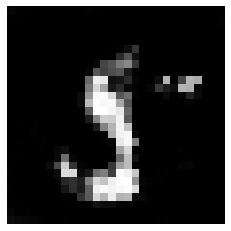

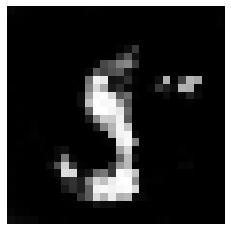

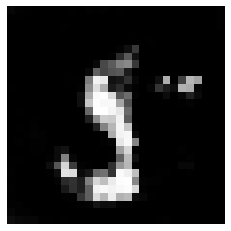

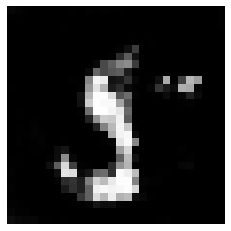

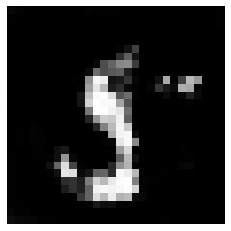

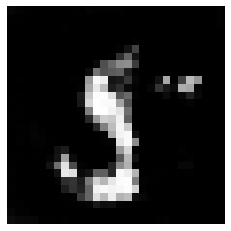

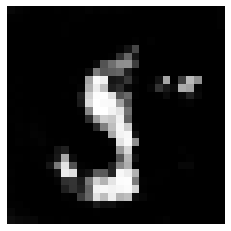

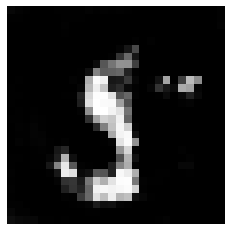

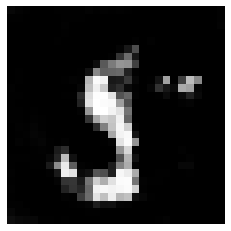

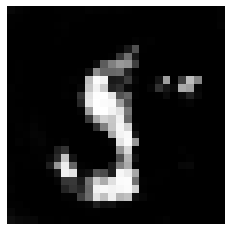

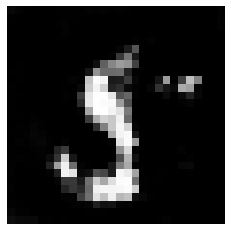

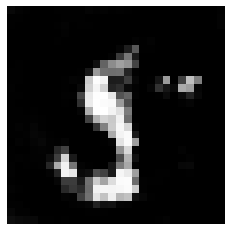

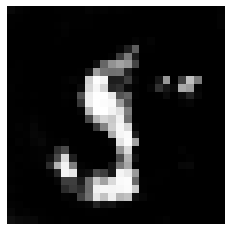

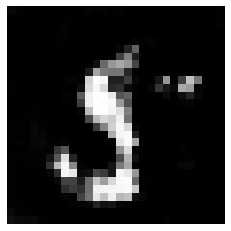

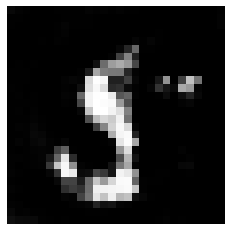

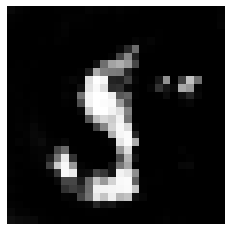

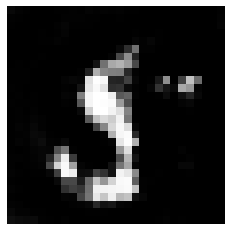

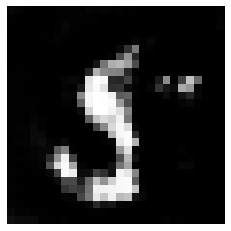

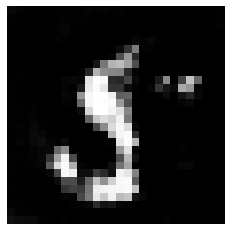

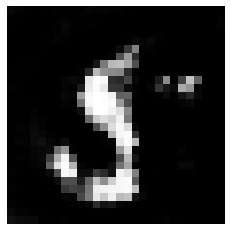

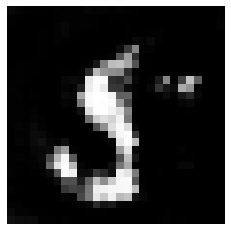

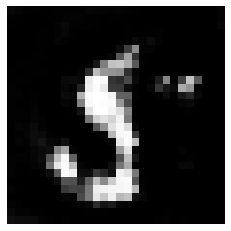

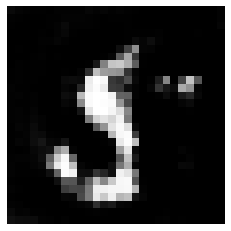

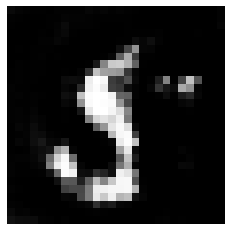

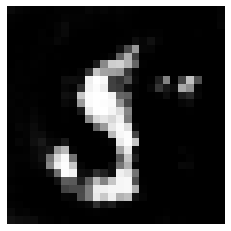

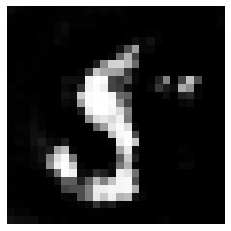

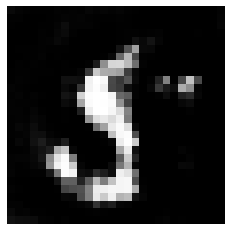

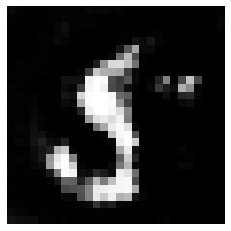

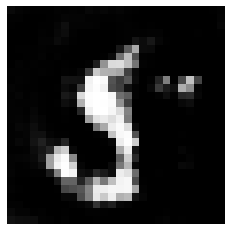

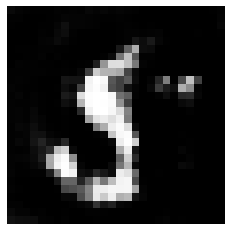

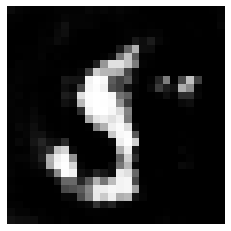

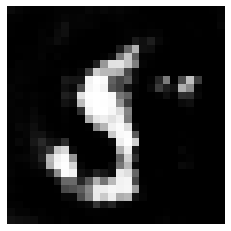

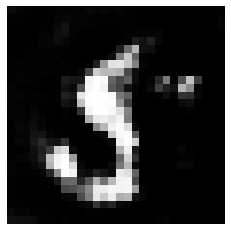

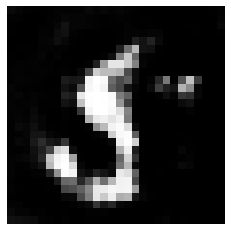

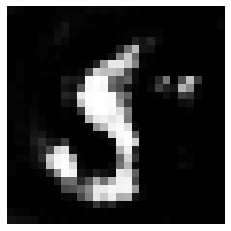

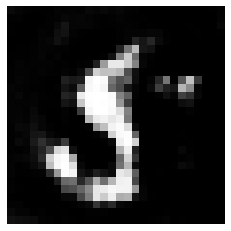

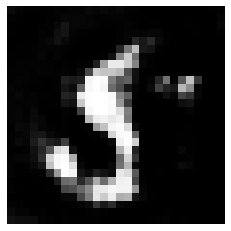

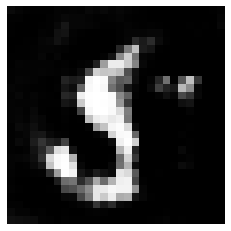

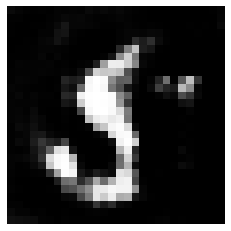

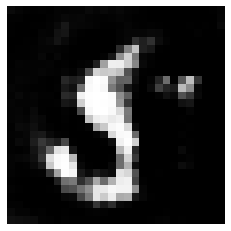

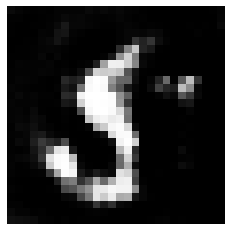

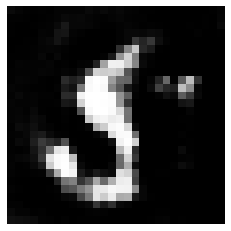

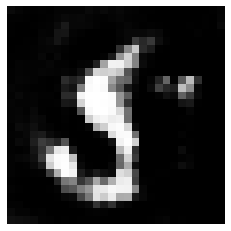

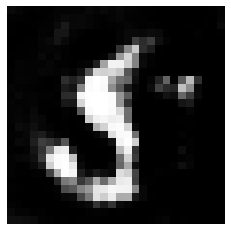

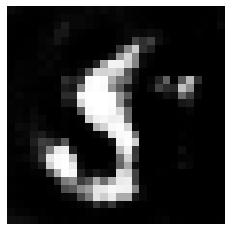

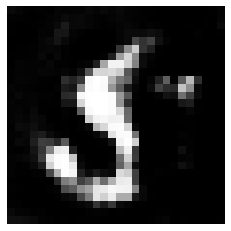

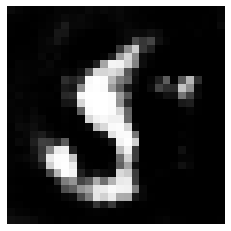

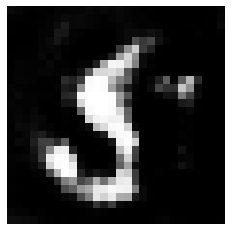

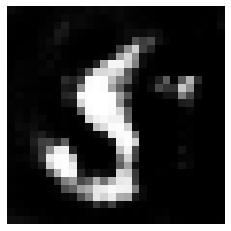

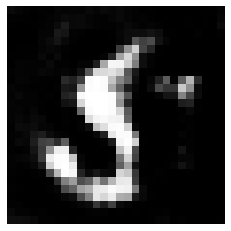

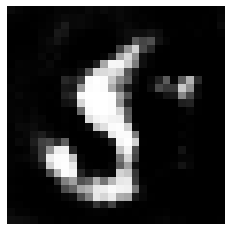

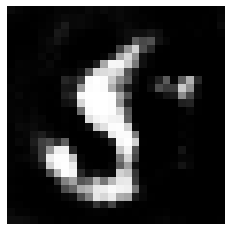

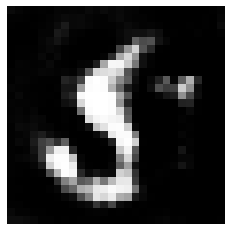

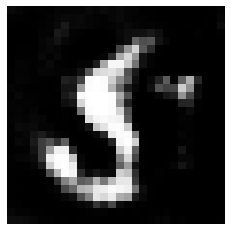

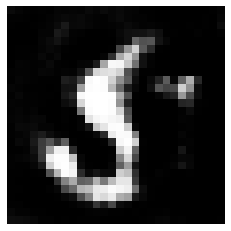

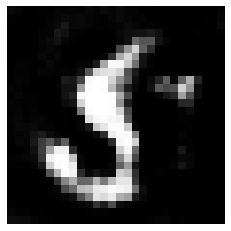

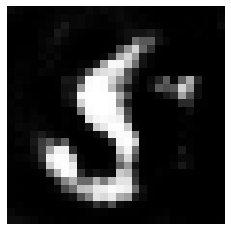

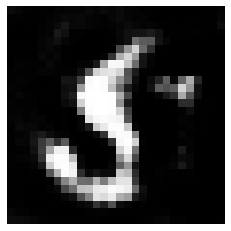

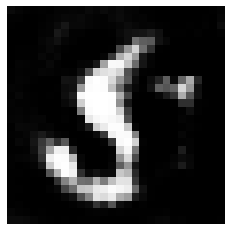

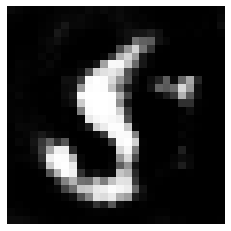

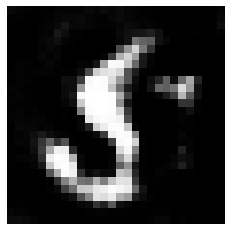

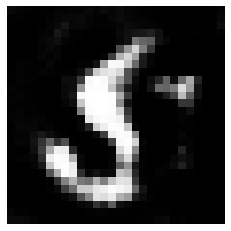

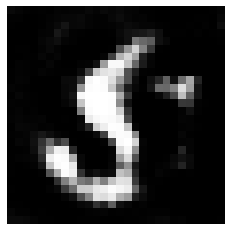

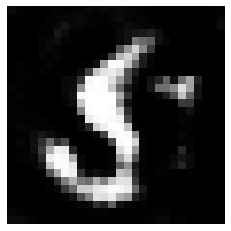

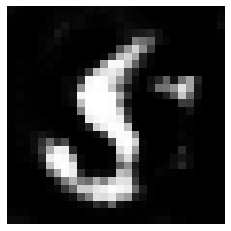

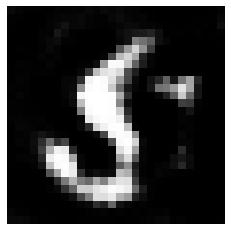

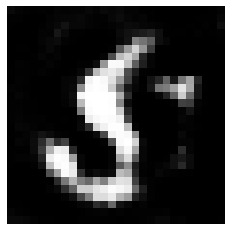

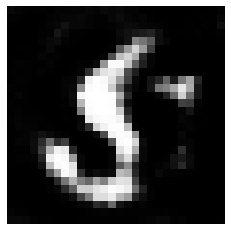

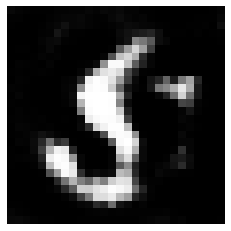

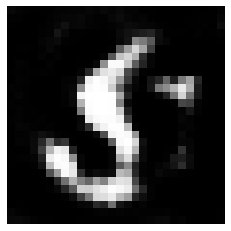

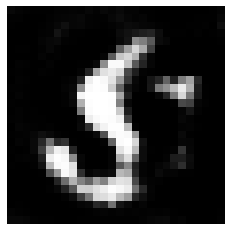

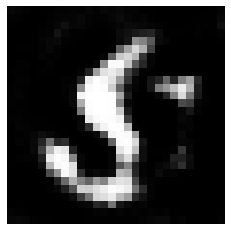

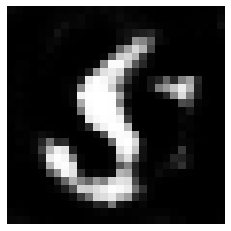

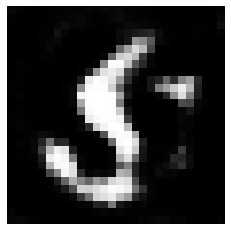

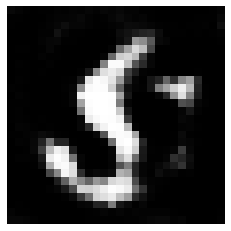

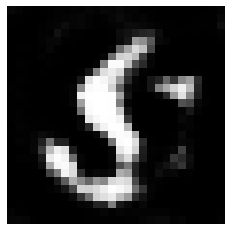

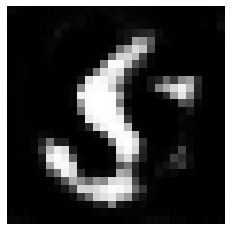

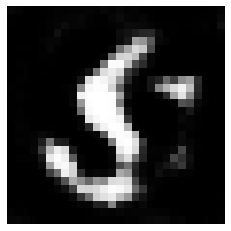

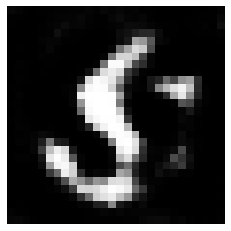

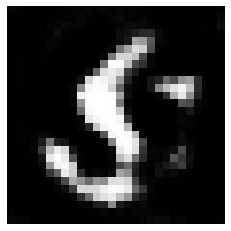

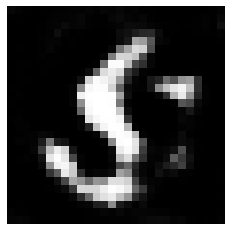

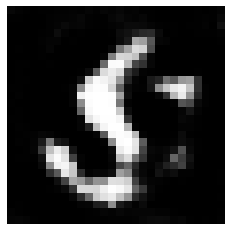

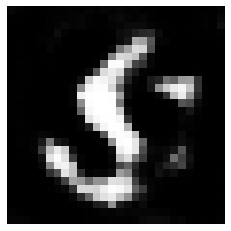

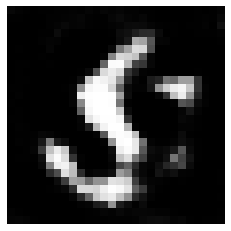

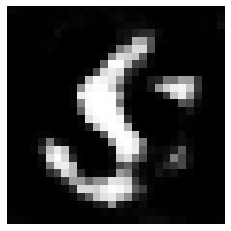

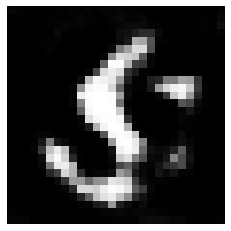

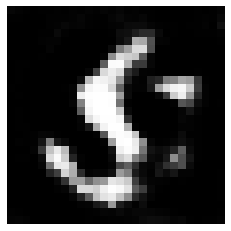

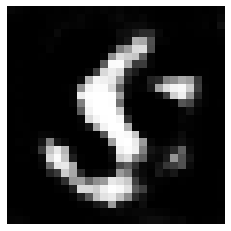

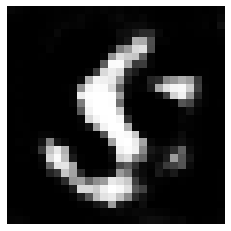

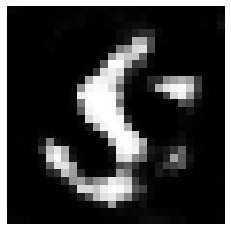

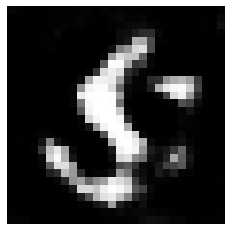

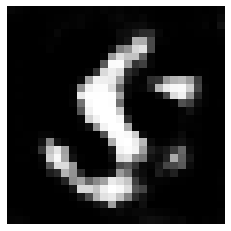

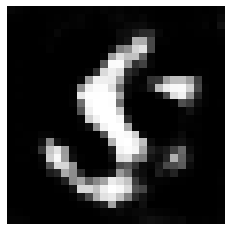

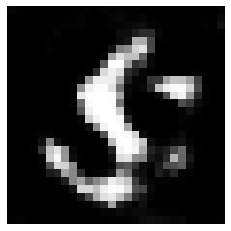

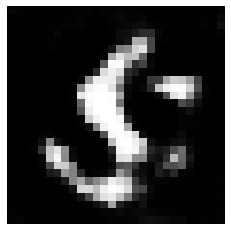

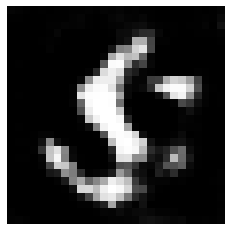

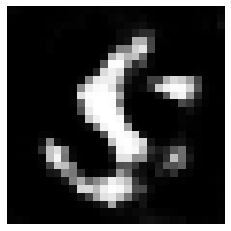

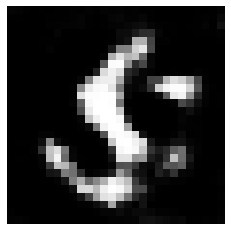

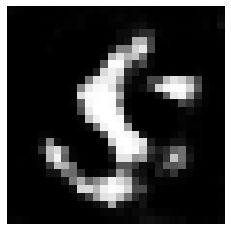

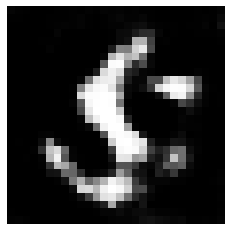

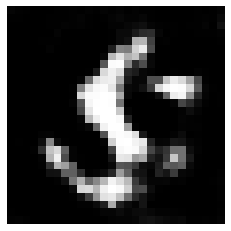

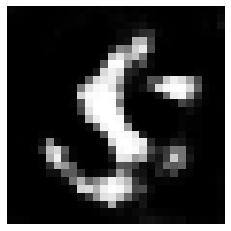

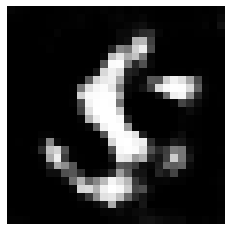

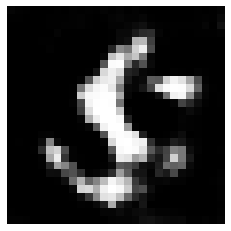

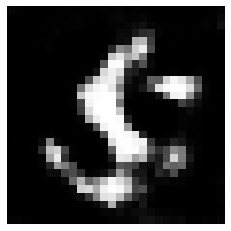

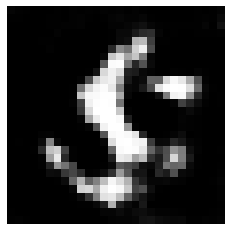

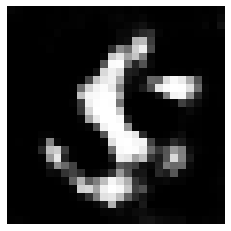

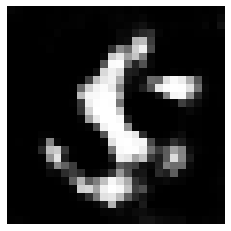

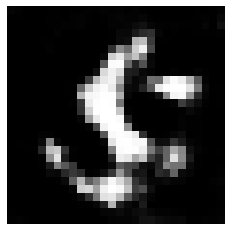

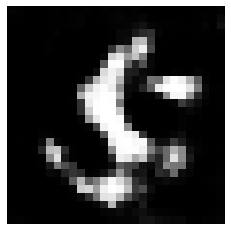

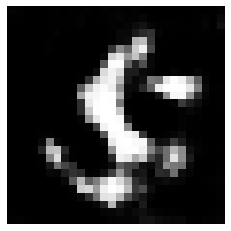

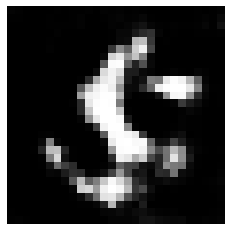

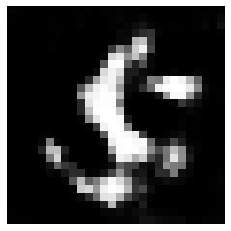

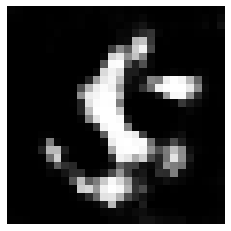

In [26]:
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

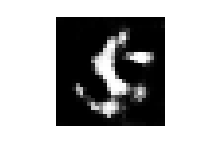

In [45]:
from PIL import Image  
im = Image.open('image_at_epoch_{:04d}.png'.format(50))
im=im.resize((int(im.size[0]/2),int(im.size[1]/2)), 0)
im

A very neat and detectable **5** has been generated from distribution of noise data .